<h2>Store 3266 OGP Associate Metric Analysis 12/20/2024 - 4/18/2025</h2>
<p>Saturday is set as start of a new week</p>
<p>Accounts for old style format from Report 3.0 and new style from new dashboard. Trains on market 178 data starting 3/17/2025.</p>

In [289]:
!pip install pandas
!pip install numpy
!pip install seaborn
!pip install torch torchvision torchaudio
!pip install scikit-learn
!pip install xgboost
!pip install lightgbm
!pip install tensorflow-macos
!pip install tensorflow-metal
!pip install keras-tuner


In [290]:
import warnings
warnings.filterwarnings("ignore", message=".*XGBoost is not compiled with CUDA support.*")
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning, module="xgboost")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import chardet
import seaborn as sns
from datetime import datetime, timedelta, date 
import glob
import os
import time
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import xgboost as xgb

notebook_start_time = time.time()
%matplotlib inline
print(f"Is CUDA available? {torch.cuda.is_available()}")

# Check if MPS is available
print("Is MPS available?", torch.backends.mps.is_available())

# Check if MPS is built into your PyTorch installation
print("Is MPS built?", torch.backends.mps.is_built())

device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
print(device)
#prevents text wrapping from output
pd.set_option('display.width', 1000)

Is CUDA available? False
Is MPS available? True
Is MPS built? True
mps


In [291]:
print(xgb.__version__)  # Ensure it shows the version with GPU support

from xgboost import XGBRegressor
model = XGBRegressor(tree_method="gpu_hist")
print(model.get_params())  # Check if tree_method is set to gpu_hist


2.1.3
{'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': None, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': None, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': None, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': 'gpu_hist', 'validate_parameters': None, 'verbosity': None}


In [292]:
file = "Data/ByAssociateView_12-20-2024_1-19-2025.csv"
file2 = "Data/ByAssociateView_1-20-2025_1-22-2025.csv"
files = [file, file2]
'''with open(file, "rb") as file:
        result = chardet.detect(file_name.read(10000))
        print(f"File: {file_name}")
        print(f"Detected Encoding: {result['encoding']}, Confidence: {result['confidence']}\n")'''
#df = pd.read_csv(file, encoding="utf-16", sep="\t", engine="python")
#df2 = pd.read_csv(file2, encoding="utf-16", sep="\t", engine="python")

test = False #flag for text files to csv 
delim_same = False #flag for same delimiter across files
market = False
# Specify the directory where your CSV files are located
csv_dir = "Data/"  # Update this to your folder path
if test == True:
    csv_dir = "Data/TestTextInput/"  # Update this to your folder path
if market == True:
    csv_dir = "Data/MarketData/"  # Update this to your folder path
# Use glob to get a list of all CSV files in the directory
csv_files = glob.glob(os.path.join(csv_dir, "ByAssociateView_*.csv"))
# Create an empty list to store DataFrames
dataframes = []
# Loop through each file, read it into a DataFrame, and append it to the list
# Process each file
for file_path in csv_files:
    print(f"File being processed: {file_path}") 
    # Detect encoding
    with open(file_path, "rb") as f:
        result = chardet.detect(f.read(10000))   
    encoding = result['encoding']
    print(f"Detected Encoding: {encoding}, Confidence: {result['confidence']}\n")   
    # Read the file into a DataFrame
    if test == True and delim_same == False:
        print("test == True and delim_same == False")
        try:
            df = pd.read_csv(file_path, encoding=encoding, engine="python")
            dataframes.append(df)
            df.head()
        except Exception as e:
            print(f"Error reading file {file_path}: {e}")
    if test == True and delim_same == True:
        print("test == True and delim_same == True")
        try:
            df = pd.read_csv(file_path, encoding=encoding, sep="\t", engine="python")
            dataframes.append(df)
            df.head()
        except Exception as e:
            print(f"Error reading file {file_path}: {e}")
    if market == True:
        print("market == True")
        try:
            df = pd.read_csv(file_path, encoding=encoding, sep="\t", engine="python")
            dataframes.append(df)
            df.head()
        except Exception as e:
            print(f"Error reading file {file_path}: {e}")
    else:
        print("test == False")
        try:
            df = pd.read_csv(file_path, encoding=encoding, sep="\t", engine="python")
            dataframes.append(df)
        except Exception as e:
            print(f"Error reading file {file_path}: {e}")

if len(dataframes) > 0:
    dataframes[0].head()
    # Combine the DataFrames row-wise
    combined_df = pd.concat(dataframes, ignore_index=True)
    #print(combined_df)
    print(f'df shape: {df.shape}\ncombined_df shape: {combined_df.shape}')
    df = combined_df
    if 'Store #,Associate,Day of Pick Date,FTPR,FTP Expected,FTP Actual,Pick Rate,Pick Hours,Picked As Req Qty,Substitution Qty,Ovrd Qty,Nil Pick Qty,Exception Qty Req to Pick,Exception Picked As Req Qty,Exception Substitution Qty,Exception Nil Pick Qty,SFS Pack Hours,SFS Packed Qty,SFS Pack Rate' in df.columns:
        df = df.drop('Store #,Associate,Day of Pick Date,FTPR,FTP Expected,FTP Actual,Pick Rate,Pick Hours,Picked As Req Qty,Substitution Qty,Ovrd Qty,Nil Pick Qty,Exception Qty Req to Pick,Exception Picked As Req Qty,Exception Substitution Qty,Exception Nil Pick Qty,SFS Pack Hours,SFS Packed Qty,SFS Pack Rate', axis=1)
    
    if "Associate ID" in df.columns:
        df = df.sort_values(by=["Associate ID", "Day of Pick Date"], ascending=[True,False])
    elif "Associate" in df.columns:
        df = df.sort_values(by=["Associate", "Day of Pick Date"], ascending=[True,False])
    else:
        print("No 'Associate ID' or 'Associate' column found for sorting.")
    #df.drop_duplicates(subset=["Associate ID", "Day of Pick Date"], keep='first', inplace=True)
    df.reset_index(drop=True)
    print(df.columns.unique())
    print(df.shape)
    df_unique = df.drop_duplicates()
    print(df_unique.shape)
    df = df_unique
else:
    print("No DataFrames to combine.")



File being processed: Data/ByAssociateView_3-25_3-26-2025.csv
Detected Encoding: UTF-16, Confidence: 1.0

test == False
File being processed: Data/ByAssociateView_3-1-_TO_3-12-2025.csv
Detected Encoding: UTF-16, Confidence: 1.0

test == False
File being processed: Data/ByAssociateView_3-4_3-5-2025.csv
Detected Encoding: UTF-16, Confidence: 1.0

test == False
File being processed: Data/ByAssociateView_2-24_2-26-2025.csv
Detected Encoding: UTF-16, Confidence: 1.0

test == False
File being processed: Data/ByAssociateView_4-7_4-11-2025.csv
Detected Encoding: UTF-16, Confidence: 1.0

test == False
File being processed: Data/ByAssociateView_3-27-2025.csv
Detected Encoding: UTF-16, Confidence: 1.0

test == False
File being processed: Data/ByAssociateView_1-28-2025.csv
Detected Encoding: UTF-16, Confidence: 1.0

test == False
File being processed: Data/ByAssociateView_1-29-2025.csv
Detected Encoding: UTF-16, Confidence: 1.0

test == False
File being processed: Data/ByAssociateView_3-19-2025.cs

In [293]:
#print(df.shape)
df.head(10)
df.sample(50)

,Store #,Associate,Day of Pick Date,FTPR,FTP Expected,FTP Actual,Pick Rate,Pick Hours,Picked As Req Qty,Substitution Qty,...,Exception Picked As Req Qty,Exception Substitution Qty,Exception Nil Pick Qty,SFS Pack Hours,SFS Packed Qty,SFS Pack Rate,First Pick Assgn Qty,First Disp Pick Qty,Qty Req to Pick,Associate ID
7010,5012.0,MAYKOL BAUTISTA,4/10/25,90.43%,115,104,38.5,2.83,104,5,...,13,8,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1709,1977.0,JESSIE MORALES,4/5/25,83.72%,43,36,69.1,0.54,37,0,...,6,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4093,3236.0,CHRISTINE TESORIERO,3/30/25,87.15%,646,563,134.8,4.49,572,33,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3557,2518.0,AMANDA MASON,4/11/25,94.46%,343,324,70.8,4.65,326,3,...,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4636,3236.0,RAFAEL GARCIA MONTEJANO,4/1/25,92.54%,402,372,86.8,4.46,374,13,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10514,3266.0,Total,Total,94.70%,"3,191","3,022",52.8,58.59,"3,043",51,...,4,3,22,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3785,2518.0,NICHOLAS TORRES,3/29/25,93.83%,227,213,49.9,4.37,214,4,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4940,3266.0,CHRISTINA CUCITRO,4/2/25,50.00%,4,2,20.9,0.10,2,0,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9026,5414.0,SERGIO SORRENTINO,Total,93.90%,213,200,49.1,4.22,201,6,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5658,3830.0,DELIA MAAT,3/22/25,95.14%,185,176,118.3,1.53,176,5,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [294]:
'''df = df.drop(df.columns[15], axis=1)
df = df.drop(df.columns[14], axis=1)
df = df.drop(df.columns[14], axis=1)
df = df.drop(df.columns[0], axis=1)
#df = df.set_index("Associate ID")'''
df = df.drop(['SFS Pack Hours', 'SFS Packed Qty', 'SFS Pack Rate'], axis=1)

In [295]:
df.head()
df.loc[df['Store #'] == 1977, :].head()

,Store #,Associate,Day of Pick Date,FTPR,FTP Expected,FTP Actual,Pick Rate,Pick Hours,Picked As Req Qty,Substitution Qty,Ovrd Qty,Nil Pick Qty,Exception Qty Req to Pick,Exception Picked As Req Qty,Exception Substitution Qty,Exception Nil Pick Qty,First Pick Assgn Qty,First Disp Pick Qty,Qty Req to Pick,Associate ID
1194,1977.0,AKILA RABBI,Total,85.00%,120,102,65.3,1.65,102,6,0.0,3,0,0,0,0,NaN,NaN,NaN,NaN
1205,1977.0,ALEJANDRO HIDALGO BETANCUR,Total,92.71%,"2,867","2,658",92.1,30.35,"2,708",87,0.0,44,0,0,0,0,NaN,NaN,NaN,NaN
1207,1977.0,AMANDA FARNKOPF,Total,78.20%,266,208,91.4,2.58,236,0,0.0,34,0,0,0,0,NaN,NaN,NaN,NaN
1210,1977.0,ANA CONFORTI,Total,92.99%,499,464,63.4,7.49,466,9,0.0,8,0,0,0,0,NaN,NaN,NaN,NaN
1234,1977.0,ANDREW SCHWARTZ,Total,90.00%,"6,000","5,400",89.5,63.33,"5,493",177,0.0,255,192,67,43,77,NaN,NaN,NaN,NaN


In [296]:
ids_to_drop = ["csp", "d0c0as3", "hkmanga", "dapanal", "nsm", "w0d03du", "jfmcken", "kdkheti", "c0c116s", "g0n018d", "azi0001", "r0s087j", "c0p07a7", "m0t03tx", "mdb00c8", "Total"]
ids_to_drop = ["csp", "Total", "nsm"]
#ids_to_drop = ["csp", "d0c0as3", "hkmanga", "dapanal", "nsm", "w0d03du", "jfmcken", "kdkheti", "c0c116s", "azi0001", "r0s087j", "c0p07a7", "m0t03tx", "Total"]
names_to_ids = {
    'a0b0ad9': 'Angela Baiori', 'a0c02mv': 'Aurora Compres', 'a0f0grp': 'Andrea Figueroa',
    'a0p0fc6': 'Andrew Plaza', 'a0s1jgx': 'Arpana Silumala', 'c0r0k4h': 'Ciana Ripa',
    'd0r0khi': 'Daniel Russo', 'e0e04sh': 'Erik Enriquez', 'e0m0abw': 'Esther Martinez',
    'e0s0frj': 'Ericka Suin', 'h0p01q8': 'Heena Patel', 'j0a0f5h': 'Jessica A',
    'j0p0vpl': 'Jesica Pugo', 'jrsigue': 'Julia Siguencia', 'l0l064x': 'Lucille Lawson',
    'm0g065v': 'Magdalena Grijalva', 'm0s0q17': 'Mirolla Said', 'mgs004k': 'Maria Sanchez',
    'n0v0359': 'Nathaniel Ventura', 'n0v03hh': 'Noelia Ventura de Santana',
    'n0w044f': 'Nicole Weaver', 's0m0uve': 'Shamima Haque Mitu', 's0p0hsd': 'Siddh Pandya',
    'stufano': 'Sharon Tufano', 't0b0hm5': 'Tierra Brown', 'g0n018d': 'Gabriel Nydick',
    'd0c0as3': 'Danielle Casiano', 'azi0001': 'Ammad Iqbal', 'm0t03tx': 'Milton Torres',
    'p0c096p': 'Pablo Chavez', 'i0s01rf': 'Ivet Saquicela', 's0m11qg': 'Shubhada Mengle',
    'mdb00c8': 'Matthew Bednarczuk', 'v0m07r6': 'Victoria Morales', 'jfmcken' : 'John Mckenna',
    'kdkheti' : 'Kishor Khetia', 'c0c116s' : 'Christina Cucitro', 'w0d03du' : 'Wijesiri Desilva',
    'hkmanga' : 'Harminder Mangat', 'dapanal' : 'Danilo Panales', 'c0p07a7' : 'Chetna Patel',
    'rsw000v' : 'Rasheed Wallace', 'r0s087j' : 'Renu Singh', 'slmorab' : 'Stephanie Morabito', 'Total': 'Total'
}
if "Associate ID" not in df.columns:
    # If Associate ID is missing but Associate Name exists, fill ID using the reverse of names_to_ids
    df['Associate ID'] = None

In [297]:

ids_to_names = {v.upper(): k for k, v in names_to_ids.items()}
names_to_ids = {v: k for k, v in ids_to_names.items()}  # lowercase keys

# IDs to exclude if needed
ids_to_drop = {"csp", "total", "nsm"}

# Separate 3266 and other stores
df_3266 = df[df['Store #'] == 3266].copy()
df_other = df[df['Store #'] != 3266].copy()

# Ensure Associate ID column exists
if "Associate ID" not in df_3266.columns:
    df_3266["Associate ID"] = None

# Fill missing Associate IDs for 3266
df_3266["Associate ID"] = df_3266.apply(
    lambda row: ids_to_names.get(str(row.get("Associate", "")).upper().strip(), row["Associate ID"])
    if pd.isna(row["Associate ID"]) or row["Associate ID"] is None else row["Associate ID"],
    axis=1
)

# Remove dropped IDs from 3266
df_3266 = df_3266[~df_3266["Associate ID"].str.lower().isin(ids_to_drop)]

# Add readable names
df_3266["Associate Name"] = df_3266["Associate ID"].map(names_to_ids).fillna("NA")

# Remove old Associate column from 3266
df_3266.drop(columns=["Associate"], inplace=True, errors="ignore")

# Reorder 3266 columns
for col in ["Associate ID", "Associate Name"]:
    vals = df_3266[col]
    df_3266.drop(columns=[col], inplace=True)
    df_3266.insert(0 if col == "Associate ID" else 1, col, vals)

# Combine 3266 and other stores back together
df = pd.concat([df_3266, df_other], ignore_index=True)

# Optional: Combine names cleanly into `Associate` if needed
def merge_names(row):
    name = row.get("Associate Name", "")
    original = row.get("Associate", "")

    if pd.isna(name) or name == "NA":
        return original
    elif pd.isna(original) or name.strip().lower() == original.strip().lower():
        return name
    else:
        return f"{name} ({original})"

if "Associate Name" in df.columns:
    df["Associate"] = df.apply(merge_names, axis=1)
else:
    df["Associate"] = df["Associate"]

# Final cleanup
df.dropna(subset=['Associate'], inplace=True)
print("Stores after filtering:", df["Store #"].unique())
print(df[df['Store #'] == 3266][['Associate ID', 'Associate Name']].drop_duplicates())



Stores after filtering: [3266. 1844. 1921. 1977. 2195. 2518. 3236. 3830. 5012. 5142. 5414.]
     Associate ID             Associate Name
0         a0b0ad9              ANGELA BAIORI
37        a0c02mv             AURORA COMPRES
53        a0f0grp            ANDREA FIGUEROA
89        a0p0fc6               ANDREW PLAZA
110       a0s1jgx            ARPANA SILUMALA
143       azi0001                AMMAD IQBAL
145       c0c116s          CHRISTINA CUCITRO
155       c0p07a7               CHETNA PATEL
157       c0r0k4h                 CIANA RIPA
180       d0c0as3           DANIELLE CASIANO
212       d0r0khi               DANIEL RUSSO
231       dapanal             DANILO PANALES
252       e0e04sh              ERIK ENRIQUEZ
284       e0m0abw            ESTHER MARTINEZ
325       e0s0frj                ERICKA SUIN
341       g0n018d             GABRIEL NYDICK
369       h0p01q8                HEENA PATEL
381       hkmanga           HARMINDER MANGAT
383       j0a0f5h                  JESSICA A
401     

In [298]:
#df.sample(50)

In [299]:
df_temp = df.loc[df['Store #'] == 3266, :]
print(df_temp['Associate'].unique())

['ANGELA BAIORI' 'AURORA COMPRES' 'ANDREA FIGUEROA' 'ANDREW PLAZA'
 'ARPANA SILUMALA' 'AMMAD IQBAL' 'CHRISTINA CUCITRO' 'CHETNA PATEL'
 'CIANA RIPA' 'DANIELLE CASIANO' 'DANIEL RUSSO' 'DANILO PANALES'
 'ERIK ENRIQUEZ' 'ESTHER MARTINEZ' 'ERICKA SUIN' 'GABRIEL NYDICK'
 'HEENA PATEL' 'HARMINDER MANGAT' 'JESSICA A' 'JESICA PUGO' 'JOHN MCKENNA'
 'JULIA SIGUENCIA' 'KISHOR KHETIA' 'LUCILLE LAWSON' 'MAGDALENA GRIJALVA'
 'MIROLLA SAID' 'MARIA SANCHEZ' 'NATHANIEL VENTURA'
 'NOELIA VENTURA DE SANTANA' 'NICOLE WEAVER' 'RENU SINGH'
 'SHAMIMA HAQUE MITU' 'SHUBHADA MENGLE' 'SIDDH PANDYA' 'SHARON TUFANO'
 'TIERRA BROWN' 'WIJESIRI DESILVA' 'MATTHEW BEDNARCZUK' 'VICTORIA MORALES'
 'IVET SAQUICELA' 'RASHEED WALLACE' 'STEPHANIE MORABITO' 'MILTON TORRES']


<H1>Cell below works for store 3266. Will filter out all other stores.</h1>

In [300]:
#df.loc[df['Associate Name'] == 0, :].head()

In [301]:
'''

print("Stores before filtering:", df["Store #"].unique())

#df = df[df["Associate ID"] != "csp"]
ids_to_drop = ["csp", "d0c0as3", "hkmanga", "dapanal", "nsm", "w0d03du", "jfmcken", "kdkheti", "c0c116s", "g0n018d", "azi0001", "r0s087j", "c0p07a7", "m0t03tx", "mdb00c8", "Total"]
ids_to_drop = ["csp", "Total", "nsm"]
#ids_to_drop = ["csp", "d0c0as3", "hkmanga", "dapanal", "nsm", "w0d03du", "jfmcken", "kdkheti", "c0c116s", "azi0001", "r0s087j", "c0p07a7", "m0t03tx", "Total"]
names_to_ids = {
    'a0b0ad9': 'Angela Baiori', 'a0c02mv': 'Aurora Compres', 'a0f0grp': 'Andrea Figueroa',
    'a0p0fc6': 'Andrew Plaza', 'a0s1jgx': 'Arpana Silumala', 'c0r0k4h': 'Ciana Ripa',
    'd0r0khi': 'Daniel Russo', 'e0e04sh': 'Erik Enriquez', 'e0m0abw': 'Esther Martinez',
    'e0s0frj': 'Ericka Suin', 'h0p01q8': 'Heena Patel', 'j0a0f5h': 'Jessica A',
    'j0p0vpl': 'Jesica Pugo', 'jrsigue': 'Julia Siguencia', 'l0l064x': 'Lucille Lawson',
    'm0g065v': 'Magdalena Grijalva', 'm0s0q17': 'Mirolla Said', 'mgs004k': 'Maria Sanchez',
    'n0v0359': 'Nathaniel Ventura', 'n0v03hh': 'Noelia Ventura de Santana',
    'n0w044f': 'Nicole Weaver', 's0m0uve': 'Shamima Haque Mitu', 's0p0hsd': 'Siddh Pandya',
    'stufano': 'Sharon Tufano', 't0b0hm5': 'Tierra Brown', 'g0n018d': 'Gabriel Nydick',
    'd0c0as3': 'Danielle Casiano', 'azi0001': 'Ammad Iqbal', 'm0t03tx': 'Milton Torres',
    'p0c096p': 'Pablo Chavez', 'i0s01rf': 'Ivet Saquicela', 's0m11qg': 'Shubhada Mengle',
    'mdb00c8': 'Matthew Bednarczuk', 'v0m07r6': 'Victoria Morales', 'jfmcken' : 'John Mckenna',
    'kdkheti' : 'Kishor Khetia', 'c0c116s' : 'Christina Cucitro', 'w0d03du' : 'Wijesiri Desilva',
    'hkmanga' : 'Harminder Mangat', 'dapanal' : 'Danilo Panales', 'c0p07a7' : 'Chetna Patel',
    'rsw000v' : 'Rasheed Wallace', 'r0s087j' : 'Renu Singh', 'slmorab' : 'Stephanie Morabito', 'Total': 'Total'
}


if "Associate ID" not in df.columns:
    # If Associate ID is missing but Associate Name exists, fill ID using the reverse of names_to_ids
    df['Associate ID'] = None

ids_to_names = {v.upper(): k for k, v in names_to_ids.items()}  # Reverse dictionary
ids_to_names["csp"] = "csp"
ids_to_names["Total"] = "Total"
print(ids_to_names)
# Fill missing Associate ID using Associate Name
df["Associate ID"] = df.apply(
    lambda row: ids_to_names.get(row["Associate"], row["Associate ID"]) 
    if pd.isna(row["Associate ID"]) or row["Associate ID"] is None else row["Associate ID"],
    axis=1
)
#df = df[~df["Associate ID"].isin(ids_to_drop)]
df['Associate Name'] = df['Associate ID'].map(names_to_ids).fillna("NA")
#df = df.reset_index()
df['Associate ID'].unique()
#df = df.drop(['Associate'], axis=1)

if "Associate ID" in df.columns:
    print("True")
    df = df[~df["Associate ID"].isin(ids_to_drop)]
    df['Associate Name'] = df['Associate ID'].map(names_to_ids).fillna("NA")

df["Associate ID"] = df["Associate ID"].replace({None: pd.NA})
df = df.dropna(subset=["Associate ID"])

col_to_move = "Associate ID"
col_vals = df["Associate ID"]
df.drop(col_to_move, axis=1, inplace=True)
df.insert(0, col_to_move, col_vals)

col_to_move = "Associate Name"
col_vals = df["Associate Name"]
df.drop(col_to_move, axis=1, inplace=True)
df.insert(1, col_to_move, col_vals)
print(f'\nAssociate Name: {df['Associate Name'].unique()}\n')
print(f'\nAssociate: {df['Associate'].unique()}\n')
df_3266 = df.loc[df['Store #'] == 3266, :]
print("Stores after filtering:", df["Store #"].unique())


'''

'\n\nprint("Stores before filtering:", df["Store #"].unique())\n\n#df = df[df["Associate ID"] != "csp"]\nids_to_drop = ["csp", "d0c0as3", "hkmanga", "dapanal", "nsm", "w0d03du", "jfmcken", "kdkheti", "c0c116s", "g0n018d", "azi0001", "r0s087j", "c0p07a7", "m0t03tx", "mdb00c8", "Total"]\nids_to_drop = ["csp", "Total", "nsm"]\n#ids_to_drop = ["csp", "d0c0as3", "hkmanga", "dapanal", "nsm", "w0d03du", "jfmcken", "kdkheti", "c0c116s", "azi0001", "r0s087j", "c0p07a7", "m0t03tx", "Total"]\nnames_to_ids = {\n    \'a0b0ad9\': \'Angela Baiori\', \'a0c02mv\': \'Aurora Compres\', \'a0f0grp\': \'Andrea Figueroa\',\n    \'a0p0fc6\': \'Andrew Plaza\', \'a0s1jgx\': \'Arpana Silumala\', \'c0r0k4h\': \'Ciana Ripa\',\n    \'d0r0khi\': \'Daniel Russo\', \'e0e04sh\': \'Erik Enriquez\', \'e0m0abw\': \'Esther Martinez\',\n    \'e0s0frj\': \'Ericka Suin\', \'h0p01q8\': \'Heena Patel\', \'j0a0f5h\': \'Jessica A\',\n    \'j0p0vpl\': \'Jesica Pugo\', \'jrsigue\': \'Julia Siguencia\', \'l0l064x\': \'Lucille Lawson

In [302]:
'''ids_to_drop = ["csp", "d0c0as3", "hkmanga", "dapanal", "nsm", "w0d03du", "jfmcken", "kdkheti", "c0c116s", "g0n018d", "azi0001", "r0s087j", "c0p07a7", "m0t03tx", "mdb00c8", "Total"]
ids_to_drop = ["csp", "Total", "nsm"]
#ids_to_drop = ["csp", "d0c0as3", "hkmanga", "dapanal", "nsm", "w0d03du", "jfmcken", "kdkheti", "c0c116s", "azi0001", "r0s087j", "c0p07a7", "m0t03tx", "Total"]
# Dictionary mapping IDs to Names
names_to_ids = {
    'a0b0ad9': 'Angela Baiori', 'a0c02mv': 'Aurora Compres', 'a0f0grp': 'Andrea Figueroa',
    'a0p0fc6': 'Andrew Plaza', 'a0s1jgx': 'Arpana Silumala', 'c0r0k4h': 'Ciana Ripa',
    'd0r0khi': 'Daniel Russo', 'e0e04sh': 'Erik Enriquez', 'e0m0abw': 'Esther Martinez',
    'e0s0frj': 'Ericka Suin', 'h0p01q8': 'Heena Patel', 'j0a0f5h': 'Jessica A',
    'j0p0vpl': 'Jesica Pugo', 'jrsigue': 'Julia Siguencia', 'l0l064x': 'Lucille Lawson',
    'm0g065v': 'Magdalena Grijalva', 'm0s0q17': 'Mirolla Said', 'mgs004k': 'Maria Sanchez',
    'n0v0359': 'Nathaniel Ventura', 'n0v03hh': 'Noelia Ventura de Santana',
    'n0w044f': 'Nicole Weaver', 's0m0uve': 'Shamima Haque Mitu', 's0p0hsd': 'Siddh Pandya',
    'stufano': 'Sharon Tufano', 't0b0hm5': 'Tierra Brown', 'g0n018d': 'Gabriel Nydick',
    'd0c0as3': 'Danielle Casiano', 'azi0001': 'Ammad Iqbal', 'm0t03tx': 'Milton Torres',
    'p0c096p': 'Pablo Chavez', 'i0s01rf': 'Ivet Saquicela', 's0m11qg': 'Shubhada Mengle',
    'mdb00c8': 'Matthew Bednarczuk', 'v0m07r6': 'Victoria Morales', 'jfmcken' : 'John Mckenna',
    'kdkheti' : 'Kishor Khetia', 'c0c116s' : 'Christina Cucitro', 'w0d03du' : 'Wijesiri Desilva',
    'hkmanga' : 'Harminder Mangat', 'dapanal' : 'Danilo Panales', 'c0p07a7' : 'Chatna Patel',
    'rsw000v' : 'Rasheed Wallace', 'r0s087j' : 'Renu Singh', 'slmorab' : 'Stephanie Morabito', 'Total': 'Total'
}

# Convert all dictionary keys to lowercase (for IDs) and uppercase (for Names)
names_to_ids = {k.lower().strip(): v.upper().strip() for k, v in names_to_ids.items()}
ids_to_names = {v.upper().strip(): k.lower().strip() for k, v in names_to_ids.items()}

# Ensure "Associate ID" and "Associate Name" columns exist
if "Associate ID" not in df.columns:
    df["Associate ID"] = None
if "Associate Name" not in df.columns:
    df["Associate Name"] = None

# Convert columns to string, strip spaces, and normalize case
df["Associate ID"] = df["Associate ID"].astype(str).str.lower().str.strip().replace("none", None)
df["Associate Name"] = df["Associate Name"].astype(str).str.upper().str.strip().replace("NONE", None)

# Preserve original columns
original_columns = df.columns.tolist()

# Fill missing Associate ID using Associate Name
df["Associate ID"] = df.apply(
    lambda row: ids_to_names.get(row["Associate Name"], row["Associate ID"]) 
    if pd.isna(row["Associate ID"]) or row["Associate ID"] is None else row["Associate ID"],
    axis=1
)

# Fill missing Associate Name using Associate ID
df["Associate Name"] = df.apply(
    lambda row: names_to_ids.get(row["Associate ID"], row["Associate Name"]) 
    if pd.isna(row["Associate Name"]) or row["Associate Name"] is None else row["Associate Name"],
    axis=1
)

# Ensure we are not accidentally dropping other columns
df = df[original_columns]

# Debugging: Print final columns to verify
print("Final columns in DataFrame:", df.columns.tolist())

# Print a preview of the DataFrame to check
print(df.head())
'''



'ids_to_drop = ["csp", "d0c0as3", "hkmanga", "dapanal", "nsm", "w0d03du", "jfmcken", "kdkheti", "c0c116s", "g0n018d", "azi0001", "r0s087j", "c0p07a7", "m0t03tx", "mdb00c8", "Total"]\nids_to_drop = ["csp", "Total", "nsm"]\n#ids_to_drop = ["csp", "d0c0as3", "hkmanga", "dapanal", "nsm", "w0d03du", "jfmcken", "kdkheti", "c0c116s", "azi0001", "r0s087j", "c0p07a7", "m0t03tx", "Total"]\n# Dictionary mapping IDs to Names\nnames_to_ids = {\n    \'a0b0ad9\': \'Angela Baiori\', \'a0c02mv\': \'Aurora Compres\', \'a0f0grp\': \'Andrea Figueroa\',\n    \'a0p0fc6\': \'Andrew Plaza\', \'a0s1jgx\': \'Arpana Silumala\', \'c0r0k4h\': \'Ciana Ripa\',\n    \'d0r0khi\': \'Daniel Russo\', \'e0e04sh\': \'Erik Enriquez\', \'e0m0abw\': \'Esther Martinez\',\n    \'e0s0frj\': \'Ericka Suin\', \'h0p01q8\': \'Heena Patel\', \'j0a0f5h\': \'Jessica A\',\n    \'j0p0vpl\': \'Jesica Pugo\', \'jrsigue\': \'Julia Siguencia\', \'l0l064x\': \'Lucille Lawson\',\n    \'m0g065v\': \'Magdalena Grijalva\', \'m0s0q17\': \'Mirolla 

In [303]:
df.head(75)
df.loc[df['Associate Name'] == 'NA', :]

,Associate ID,Associate Name,Store #,Day of Pick Date,FTPR,FTP Expected,FTP Actual,Pick Rate,Pick Hours,Picked As Req Qty,...,Ovrd Qty,Nil Pick Qty,Exception Qty Req to Pick,Exception Picked As Req Qty,Exception Substitution Qty,Exception Nil Pick Qty,First Pick Assgn Qty,First Disp Pick Qty,Qty Req to Pick,Associate


In [304]:
df.loc[df['Associate ID'] == "NA", :]

,Associate ID,Associate Name,Store #,Day of Pick Date,FTPR,FTP Expected,FTP Actual,Pick Rate,Pick Hours,Picked As Req Qty,...,Ovrd Qty,Nil Pick Qty,Exception Qty Req to Pick,Exception Picked As Req Qty,Exception Substitution Qty,Exception Nil Pick Qty,First Pick Assgn Qty,First Disp Pick Qty,Qty Req to Pick,Associate


In [305]:
df = df.loc[df["Day of Pick Date"] != "Total"] #keep total for other stores in market to have some baseline data starting from 3/17/2025
#df.head(10)

In [306]:
df.loc[df['Associate ID'] == 0, :]

,Associate ID,Associate Name,Store #,Day of Pick Date,FTPR,FTP Expected,FTP Actual,Pick Rate,Pick Hours,Picked As Req Qty,...,Ovrd Qty,Nil Pick Qty,Exception Qty Req to Pick,Exception Picked As Req Qty,Exception Substitution Qty,Exception Nil Pick Qty,First Pick Assgn Qty,First Disp Pick Qty,Qty Req to Pick,Associate


In [307]:
# Replace NaN values with 0
#df['Qty Req to Pick'] = df['Qty Req to Pick'].fillna(0)
# Ensure both columns are cleaned and converted to numeric
if 'Qty Req to Pick' in df.columns:
    df['Qty Req to Pick'] = df['Qty Req to Pick'].replace(',', '', regex=True).fillna(0).astype(int)
else:
    df['Qty Req to Pick'] = df['FTP Expected'].replace(',', '', regex=True).fillna(0).astype(int)
if 'FTP Expected' in df.columns:
    df['FTP Expected'] = df['FTP Expected'].replace(',', '', regex=True).fillna(0).astype(int)
else:
    df['FTP Expected'].fillna(0, inplace=True).astype(int)
if 'Picked As Req Qty' in df.columns:    
    df['Picked As Req Qty'] = df['Picked As Req Qty'].replace(',', '', regex=True).fillna(0).astype(int)
else:
    df['Picked As Req Qty'].fillna(0, inplace=True).astype(int)
if 'FTP Actual' in df.columns:
    df['FTP Actual'] = df['FTP Actual'].replace(',', '', regex=True).fillna(0).astype(int)
else:
    df['FTP Actual'].fillna(0, inplace=True).astype(int)
# Replace 0 values in 'Qty Req to Pick' with corresponding values from 'FTP Expected'
#df.loc[df['Qty Req to Pick'] == 0, 'Qty Req to Pick'] = df.loc[df['Qty Req to Pick'] == 0, 'FTP Expected']
df['Qty Req to Pick'] = df['Qty Req to Pick'].mask(df['Qty Req to Pick'] == 0, df['FTP Expected'])
df['FTP Expected'] = df['FTP Expected'].mask(df['FTP Expected'] == 0, df['Qty Req to Pick'])
df['Picked As Req Qty'] = df['Picked As Req Qty'].mask(df['Picked As Req Qty'] == 0, df['FTP Actual'])
df['FTP Actual'] = df['FTP Actual'].mask(df['FTP Actual'] == 0, df['Picked As Req Qty'])
df = df.loc[:,:].fillna(0)

# Ensure 'Qty Req to Pick' is numeric
df['Qty Req to Pick'] = pd.to_numeric(df['Qty Req to Pick'], errors='coerce')
df["FTPR"] = df["FTPR"].str.replace("%", "").astype(float)
df = df.dropna()
df.head()
df.loc[df['Store #'] == 1844, :].head(20)

,Associate ID,Associate Name,Store #,Day of Pick Date,FTPR,FTP Expected,FTP Actual,Pick Rate,Pick Hours,Picked As Req Qty,...,Ovrd Qty,Nil Pick Qty,Exception Qty Req to Pick,Exception Picked As Req Qty,Exception Substitution Qty,Exception Nil Pick Qty,First Pick Assgn Qty,First Disp Pick Qty,Qty Req to Pick,Associate
4182,0,0,1844.0,4/9/25,92.96,71,66,43.9,1.50,66,...,0.0,2,3,0,1,0,0,0,71,ETHAN PAWLING
4183,0,0,1844.0,4/9/25,89.66,29,26,77.3,0.38,27,...,0.0,0,0,0,0,0,0,0,29,IMAN OWENS
4184,0,0,1844.0,4/9/25,92.86,28,26,78.5,0.33,26,...,0.0,2,0,0,0,0,0,0,28,JAKE QUAGLIA
4185,0,0,1844.0,4/9/25,88.21,526,464,46.0,10.53,478,...,0.0,28,52,0,0,52,0,0,526,JOHNATHON OTTO
4186,0,0,1844.0,4/9/25,96.79,187,181,45.5,4.13,182,...,0.0,1,0,0,0,0,0,0,187,KIMBERLY EDGAR
4187,0,0,1844.0,4/9/25,93.09,246,229,85.1,2.69,229,...,0.0,5,0,0,0,0,0,0,246,MARINA MILLARES
4188,0,0,1844.0,4/9/25,94.37,231,218,66.2,3.30,218,...,0.0,12,1,1,0,0,0,0,231,MARYAM SHAFAI
4189,0,0,1844.0,4/9/25,98.97,194,192,65.1,2.95,192,...,0.0,2,0,0,0,0,0,0,194,STEPHEN CHILLEMI
4421,0,0,1844.0,4/8/25,93.43,137,128,85.0,1.53,130,...,0.0,9,0,0,0,0,0,0,137,AIDAN APJOHN
4422,0,0,1844.0,4/8/25,95.15,103,98,41.6,2.35,98,...,0.0,3,0,0,0,0,0,0,103,CHARLIE ORTIZ VILELA


In [308]:
#df.loc["a0b0ad9", :]
#df = df.loc[df["Day of Pick Date"] != "Total"]
df.loc[df["Associate ID"] == "a0b0ad9" ,:]

,Associate ID,Associate Name,Store #,Day of Pick Date,FTPR,FTP Expected,FTP Actual,Pick Rate,Pick Hours,Picked As Req Qty,...,Ovrd Qty,Nil Pick Qty,Exception Qty Req to Pick,Exception Picked As Req Qty,Exception Substitution Qty,Exception Nil Pick Qty,First Pick Assgn Qty,First Disp Pick Qty,Qty Req to Pick,Associate
10,a0b0ad9,ANGELA BAIORI,3266.0,2/5/25,97.01,233,227,60.0,3.86,227,...,0.0,3,0,0,0,0,0,0,233,ANGELA BAIORI
12,a0b0ad9,ANGELA BAIORI,3266.0,2/2/25,97.03,268,254,59.0,4.36,254,...,0.0,10,0,0,0,0,0,0,268,ANGELA BAIORI
13,a0b0ad9,ANGELA BAIORI,3266.0,12/29/24,92.92,214,199,42.0,4.88,199,...,0.0,4,0,0,0,0,0,0,214,ANGELA BAIORI
14,a0b0ad9,ANGELA BAIORI,3266.0,12/27/24,100.00,47,47,79.0,0.6,47,...,0.0,0,0,0,0,0,0,0,47,ANGELA BAIORI
15,a0b0ad9,ANGELA BAIORI,3266.0,12/26/24,92.66,223,212,51.0,4.18,212,...,0.0,5,2,0,0,2,0,0,223,ANGELA BAIORI
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2811,a0b0ad9,ANGELA BAIORI,3266.0,2/23/25,96.77,279,271,72.0,3.81,271,...,0.0,6,0,0,0,0,0,0,279,ANGELA BAIORI
2836,a0b0ad9,ANGELA BAIORI,3266.0,2/21/25,96.84,258,245,44.0,5.71,245,...,0.0,1,0,0,0,0,0,0,258,ANGELA BAIORI
2851,a0b0ad9,ANGELA BAIORI,3266.0,2/20/25,95.69,235,227,54.0,4.29,227,...,0.0,1,0,0,0,0,0,0,235,ANGELA BAIORI
2878,a0b0ad9,ANGELA BAIORI,3266.0,2/18/25,99.35,154,153,50.0,3.1,153,...,0.0,0,0,0,0,0,0,0,154,ANGELA BAIORI


In [309]:
df.loc[df['Associate ID'] == "rsw000v" , :]
#df.loc[df['Associate Name'] == "Victoria Morales", :]

,Associate ID,Associate Name,Store #,Day of Pick Date,FTPR,FTP Expected,FTP Actual,Pick Rate,Pick Hours,Picked As Req Qty,...,Ovrd Qty,Nil Pick Qty,Exception Qty Req to Pick,Exception Picked As Req Qty,Exception Substitution Qty,Exception Nil Pick Qty,First Pick Assgn Qty,First Disp Pick Qty,Qty Req to Pick,Associate
1724,rsw000v,RASHEED WALLACE,3266.0,4/4/25,84.62,39,33,53.7,0.62,33,...,0.0,6,0,0,0,0,0,0,39,RASHEED WALLACE
1740,rsw000v,RASHEED WALLACE,3266.0,4/4/25,84.62,39,33,53.7,0.62,33,...,0.0,6,0,0,0,0,0,0,39,RASHEED WALLACE
2114,rsw000v,RASHEED WALLACE,3266.0,3/5/25,83.04,0,94,110.0,0.97,94,...,0.0,5,2,1,1,0,112,93,0,RASHEED WALLACE
2483,rsw000v,RASHEED WALLACE,3266.0,3/20/25,100.00,2,2,300.0,0.01,2,...,0.0,0,0,0,0,0,0,0,2,RASHEED WALLACE
2499,rsw000v,RASHEED WALLACE,3266.0,3/20/25,100.00,2,2,300.0,0.01,2,...,0.0,0,0,0,0,0,0,0,2,RASHEED WALLACE
2977,rsw000v,RASHEED WALLACE,3266.0,2/11/25,91.18,34,31,63.0,0.5,31,...,0.0,0,0,0,0,0,0,0,34,RASHEED WALLACE


In [310]:
# Convert "Day of Pick Date" to datetime
df["Day of Pick Date"] = pd.to_datetime(df["Day of Pick Date"], format="%m/%d/%y")

# Adjust dates to align with Saturday as the start of the week
df["Custom Week Start"] = df["Day of Pick Date"] - pd.to_timedelta((df["Day of Pick Date"].dt.dayofweek + 2) % 7, unit="d")

# Calculate the end of the week (Friday)
df["Custom Week End"] = df["Custom Week Start"] + pd.Timedelta(days=6)

# Combine start and end dates into a single "Week" column as a range
df['Week'] = df["Custom Week Start"].dt.strftime('%Y-%m-%d') + " to " + df["Custom Week End"].dt.strftime('%Y-%m-%d')

oldest_pick_date = df["Day of Pick Date"].min()
last_pick_date = df["Day of Pick Date"].max()
oldest_pick_date = pd.to_datetime(oldest_pick_date).date()
last_pick_date = pd.to_datetime(last_pick_date).date()
print(f"start date: {oldest_pick_date}")
print(f"end date: {last_pick_date}")
def combine_data_to_csv():
    # Create the directory
    try:
        os.mkdir("Data/Combined/")
        print(f"Directory '{"Data/Combined/"}' created successfully.")
        df.to_csv(f"Data/Combined/ByAssociateView_{oldest_pick_date}_{last_pick_date}.csv", index=False)
    except FileExistsError:
        print(f"Directory '{"Data/Comnined/"}' already exists.")
        df.to_csv(f"Data/Combined/ByAssociateView_{oldest_pick_date}_{last_pick_date}.csv", index=False)
    except PermissionError:
        print(f"Permission denied: Unable to create '{directory_name}'.")
    except Exception as e:
        print(f"An error occurred: {e}")
#combine_data_to_csv()
#df.loc[df["Associate ID"] == "a0b0ad9", :]

start date: 2024-12-20
end date: 2025-04-18


In [311]:
def cols_to_convert_to_float(df):
    cols_to_convert = [
    'Picked As Req Qty',
    'Nil Pick Qty',
    'Qty Req to Pick',
    'Substitution Qty',
    'Exception Qty Req to Pick',
    'Exception Picked As Req Qty',
    'Exception Substitution Qty',
    'Exception Nil Pick Qty'
]

    for col in cols_to_convert:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    return df

In [312]:
print(df.info())
# Group by Associate ID and Week and apply aggregations
# Convert problematic columns to numeric, coercing errors to NaN
#df['Picked As Req Qty'] = pd.to_numeric(df['Picked As Req Qty'], errors='coerce')
#df['Nil Pick Qty'] = pd.to_numeric(df['Nil Pick Qty'], errors='coerce')
cols_to_convert = [
    'Picked As Req Qty',
    'Nil Pick Qty',
    'Qty Req to Pick',
    'Substitution Qty',
    'Exception Qty Req to Pick',
    'Exception Picked As Req Qty',
    'Exception Substitution Qty',
    'Exception Nil Pick Qty'
]

for col in cols_to_convert:
    df[col] = pd.to_numeric(df[col], errors='coerce')

df_3266 = df.loc[df['Store #'] == 3266, :].copy()
# Check for NaN values introduced after conversion
print("Null values after conversion:")
print(df_3266[['Picked As Req Qty', 'Nil Pick Qty']].isna().sum())
weekly_data = df_3266.groupby(['Week', 'Associate ID', "Associate Name"]).agg(
    total_qty_req_to_pick=('Qty Req to Pick', 'sum'),  # Ensure correct column name here
    total_picked_qty=('Picked As Req Qty', 'sum'),  # Added for reference
    avg_pick_rate=('Pick Rate', 'mean'),
    total_substitution_qty=('Substitution Qty', 'sum'),
    total_nil_pick_qty=('Nil Pick Qty', 'sum'),
    total_exception_qty_req=('Exception Qty Req to Pick', 'sum'),
    total_exception_picked_qty=('Exception Picked As Req Qty', 'sum'),
    total_exception_substitution_qty=('Exception Substitution Qty', 'sum'),
    total_exception_nil_pick_qty=('Exception Nil Pick Qty', 'sum')
).reset_index()
weekly_data.head()

<class 'pandas.core.frame.DataFrame'>
Index: 9332 entries, 10 to 12234
Data columns (total 24 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   Associate ID                 9332 non-null   object        
 1   Associate Name               9332 non-null   object        
 2   Store #                      9332 non-null   float64       
 3   Day of Pick Date             9332 non-null   datetime64[ns]
 4   FTPR                         9332 non-null   float64       
 5   FTP Expected                 9332 non-null   int64         
 6   FTP Actual                   9332 non-null   int64         
 7   Pick Rate                    9332 non-null   float64       
 8   Pick Hours                   9332 non-null   object        
 9   Picked As Req Qty            9332 non-null   int64         
 10  Substitution Qty             9332 non-null   object        
 11  Ovrd Qty                     9332 non-null   f

,Week,Associate ID,Associate Name,total_qty_req_to_pick,total_picked_qty,avg_pick_rate,total_substitution_qty,total_nil_pick_qty,total_exception_qty_req,total_exception_picked_qty,total_exception_substitution_qty,total_exception_nil_pick_qty
0,2024-12-14 to 2024-12-20,a0f0grp,ANDREA FIGUEROA,147,144,55.0,1,2,1,1,0,0
1,2024-12-14 to 2024-12-20,a0p0fc6,ANDREW PLAZA,50,49,36.0,0,0,0,0,0,0
2,2024-12-14 to 2024-12-20,c0c116s,CHRISTINA CUCITRO,4,4,46.0,0,0,0,0,0,0
3,2024-12-14 to 2024-12-20,d0r0khi,DANIEL RUSSO,34,32,81.0,2,0,0,0,0,0
4,2024-12-14 to 2024-12-20,e0e04sh,ERIK ENRIQUEZ,5,5,16.0,0,0,0,0,0,0


In [313]:
weekly_data.loc[weekly_data['Associate ID'] == 'a0p0fc6']

,Week,Associate ID,Associate Name,total_qty_req_to_pick,total_picked_qty,avg_pick_rate,total_substitution_qty,total_nil_pick_qty,total_exception_qty_req,total_exception_picked_qty,total_exception_substitution_qty,total_exception_nil_pick_qty
1,2024-12-14 to 2024-12-20,a0p0fc6,ANDREW PLAZA,50,49,36.000000,0,0,0,0,0,0
18,2024-12-21 to 2024-12-27,a0p0fc6,ANDREW PLAZA,217,194,33.750000,19,1,0,0,0,0
47,2024-12-28 to 2025-01-03,a0p0fc6,ANDREW PLAZA,171,168,48.333333,0,1,1,0,1,0
77,2025-01-04 to 2025-01-10,a0p0fc6,ANDREW PLAZA,131,130,45.000000,2,0,0,0,0,0
104,2025-01-11 to 2025-01-17,a0p0fc6,ANDREW PLAZA,39,37,43.000000,1,1,0,0,0,0
131,2025-01-18 to 2025-01-24,a0p0fc6,ANDREW PLAZA,130,120,38.000000,0,6,1,0,0,1
157,2025-01-25 to 2025-01-31,a0p0fc6,ANDREW PLAZA,42,42,51.000000,0,0,0,0,0,0
209,2025-02-08 to 2025-02-14,a0p0fc6,ANDREW PLAZA,64,64,44.000000,0,0,0,0,0,0
237,2025-02-15 to 2025-02-21,a0p0fc6,ANDREW PLAZA,76,69,55.000000,0,1,2,0,0,2
265,2025-02-22 to 2025-02-28,a0p0fc6,ANDREW PLAZA,64,80,66.000000,0,0,0,0,0,0


In [314]:
#df.loc[df['Associate ID'] == 'a0p0fc6']

In [315]:
unique_ids = df["Associate ID"].unique()
unique_ids_list = unique_ids.tolist()
#for a in unique_ids_list:
#    print(a)

In [316]:
#for a in unique_ids_list:
#    print(df.loc[df["Associate ID"] == a, : "Pick Hours"])

In [317]:
#df["FTPR"] = df["FTPR"].str.replace("%", "").astype(float)

In [318]:
avdf = df_3266.groupby(["Associate ID", "Associate Name"]).mean(numeric_only=True)

In [319]:
avdf.head()

,,Store #,FTPR,FTP Expected,FTP Actual,Pick Rate,Picked As Req Qty,Substitution Qty,Ovrd Qty,Nil Pick Qty,Exception Qty Req to Pick,Exception Picked As Req Qty,Exception Substitution Qty,Exception Nil Pick Qty,Qty Req to Pick
Associate ID,Associate Name,,,,,,,,,,,,,,
a0b0ad9,ANGELA BAIORI,3266.0,96.179620,159.607595,177.734177,54.010127,178.506329,3.164557,0.0,4.658228,0.670886,0.253165,0.063291,0.354430,159.607595
a0c02mv,AURORA COMPRES,3266.0,94.430833,71.583333,77.166667,44.454167,77.333333,2.541667,0.0,4.083333,0.416667,0.000000,0.416667,0.000000,71.583333
a0f0grp,ANDREA FIGUEROA,3266.0,96.477407,104.851852,105.592593,57.307407,105.648148,2.277778,0.0,2.092593,0.314815,0.166667,0.129630,0.018519,104.851852
a0p0fc6,ANDREW PLAZA,3266.0,91.055349,51.627907,52.976744,45.451163,53.906977,1.372093,0.0,1.813953,0.813953,0.093023,0.023256,0.697674,51.627907
a0s1jgx,ARPANA SILUMALA,3266.0,94.814821,144.428571,151.750000,43.378571,151.750000,2.660714,0.0,6.214286,0.267857,0.196429,0.017857,0.053571,144.428571


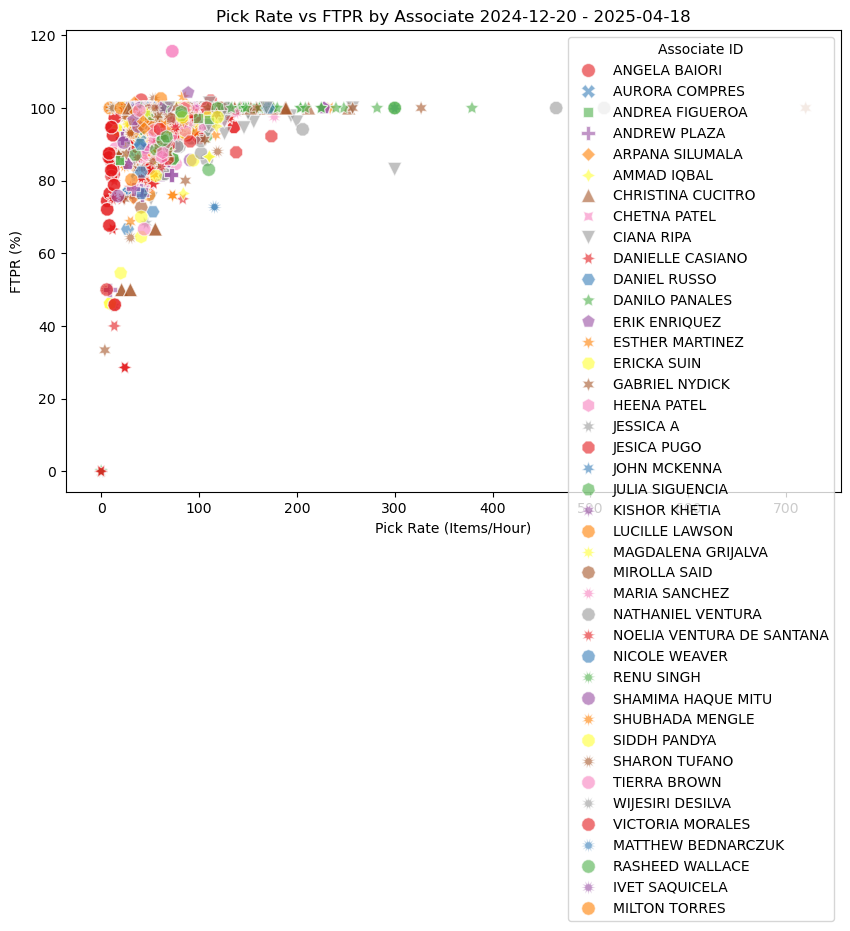

In [320]:
# Scatter plot with Pick Rate vs FTPR
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_3266, x='Pick Rate', y='FTPR', hue='Associate Name', palette='Set1', style='Associate Name', s=100, alpha=0.6)
plt.title(f'Pick Rate vs FTPR by Associate {oldest_pick_date} - {last_pick_date}')
plt.xlabel('Pick Rate (Items/Hour)')
plt.ylabel('FTPR (%)')
plt.legend(title='Associate ID')
plt.show()


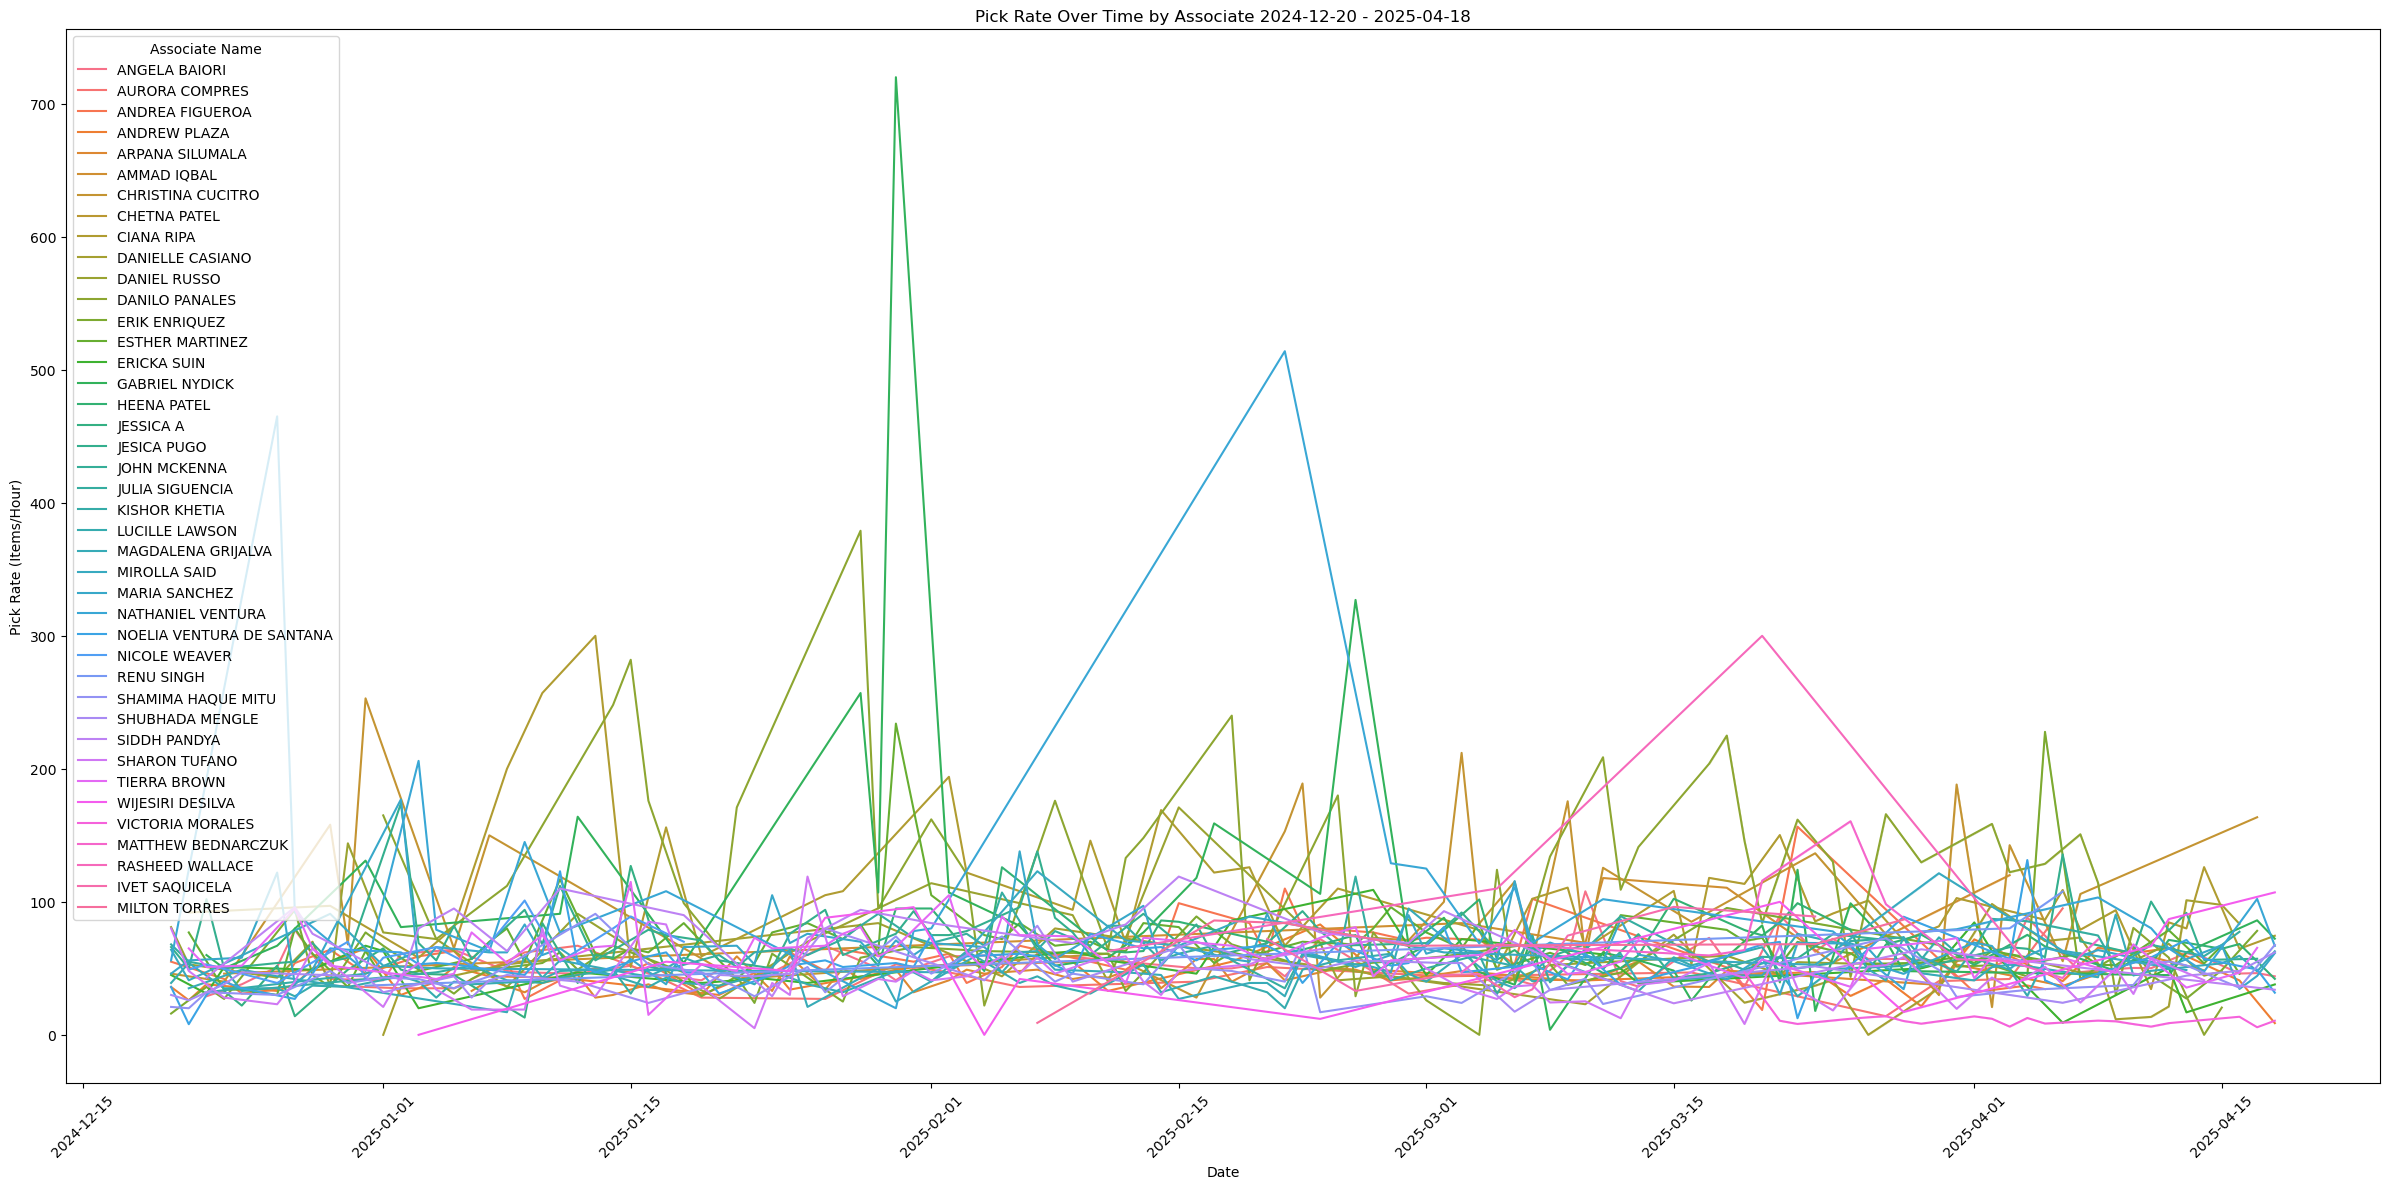

In [321]:
# Convert 'Day of Pick Date' to datetime format for time-based analysis
df['Day of Pick Date'] = pd.to_datetime(df['Day of Pick Date'], format='%m/%d/%y')
df_3266['Day of Pick Date'] = pd.to_datetime(df_3266['Day of Pick Date'], format='%m/%d/%y')
# Line plot of Pick Rate over time for each Associate
plt.figure(figsize=(24, 12))
sns.lineplot(data=df_3266, x='Day of Pick Date', y='Pick Rate', hue='Associate Name', markers=True)
plt.title(f'Pick Rate Over Time by Associate {oldest_pick_date} - {last_pick_date}')
plt.xlabel('Date')
plt.ylabel('Pick Rate (Items/Hour)')
plt.xticks(rotation=45)
plt.legend(title='Associate Name')
plt.tight_layout()
plt.show()


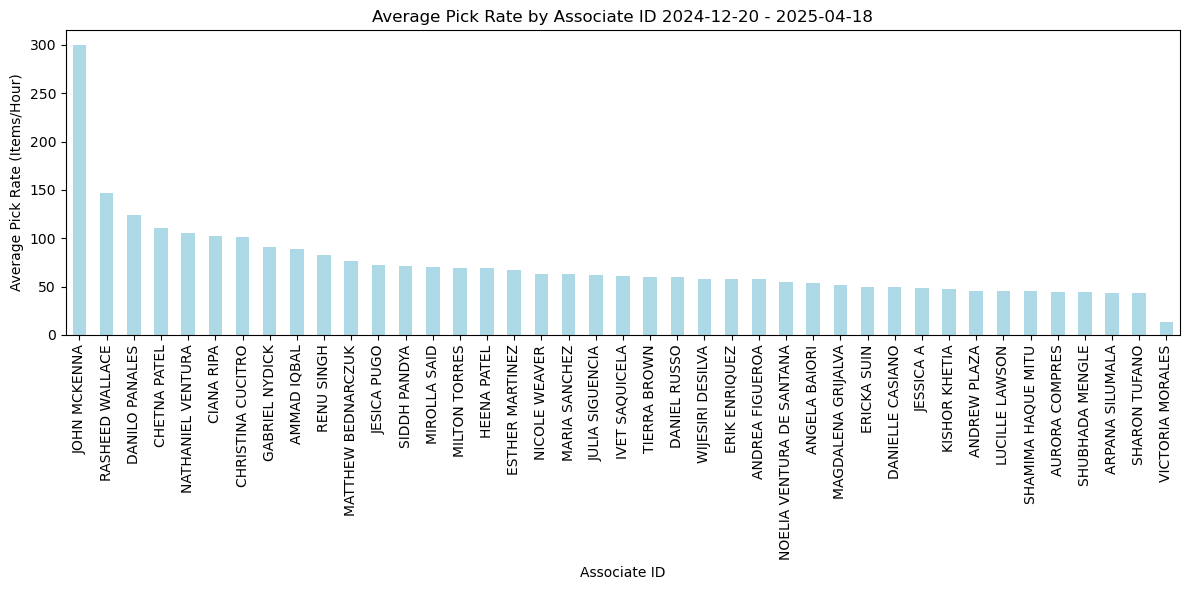

Associate Name
JOHN MCKENNA                 300.000000
RASHEED WALLACE              146.733333
DANILO PANALES               123.840580
CHETNA PATEL                 111.000000
NATHANIEL VENTURA            105.064865
CIANA RIPA                   102.296970
CHRISTINA CUCITRO            101.482051
GABRIEL NYDICK                91.164815
AMMAD IQBAL                   88.710000
RENU SINGH                    82.520000
MATTHEW BEDNARCZUK            75.965217
JESICA PUGO                   72.602273
SIDDH PANDYA                  70.948148
MIROLLA SAID                  69.957895
MILTON TORRES                 69.475000
HEENA PATEL                   69.187931
ESTHER MARTINEZ               66.668132
NICOLE WEAVER                 63.384615
MARIA SANCHEZ                 63.236458
JULIA SIGUENCIA               62.274713
IVET SAQUICELA                60.700000
TIERRA BROWN                  60.014286
DANIEL RUSSO                  59.614583
WIJESIRI DESILVA              58.229412
ERIK ENRIQUEZ            

In [322]:
# Grouping by Associate ID and calculating average Pick Rate
avg_pick_rate = df_3266.groupby('Associate Name')['Pick Rate'].mean().sort_values(ascending=False)

# Bar plot for average Pick Rate per Associate ID
plt.figure(figsize=(12, 6))
avg_pick_rate.plot(kind='bar', color='lightblue')
plt.title(f'Average Pick Rate by Associate ID {oldest_pick_date} - {last_pick_date}')
plt.xlabel('Associate ID')
plt.ylabel('Average Pick Rate (Items/Hour)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

avg_pick_rate

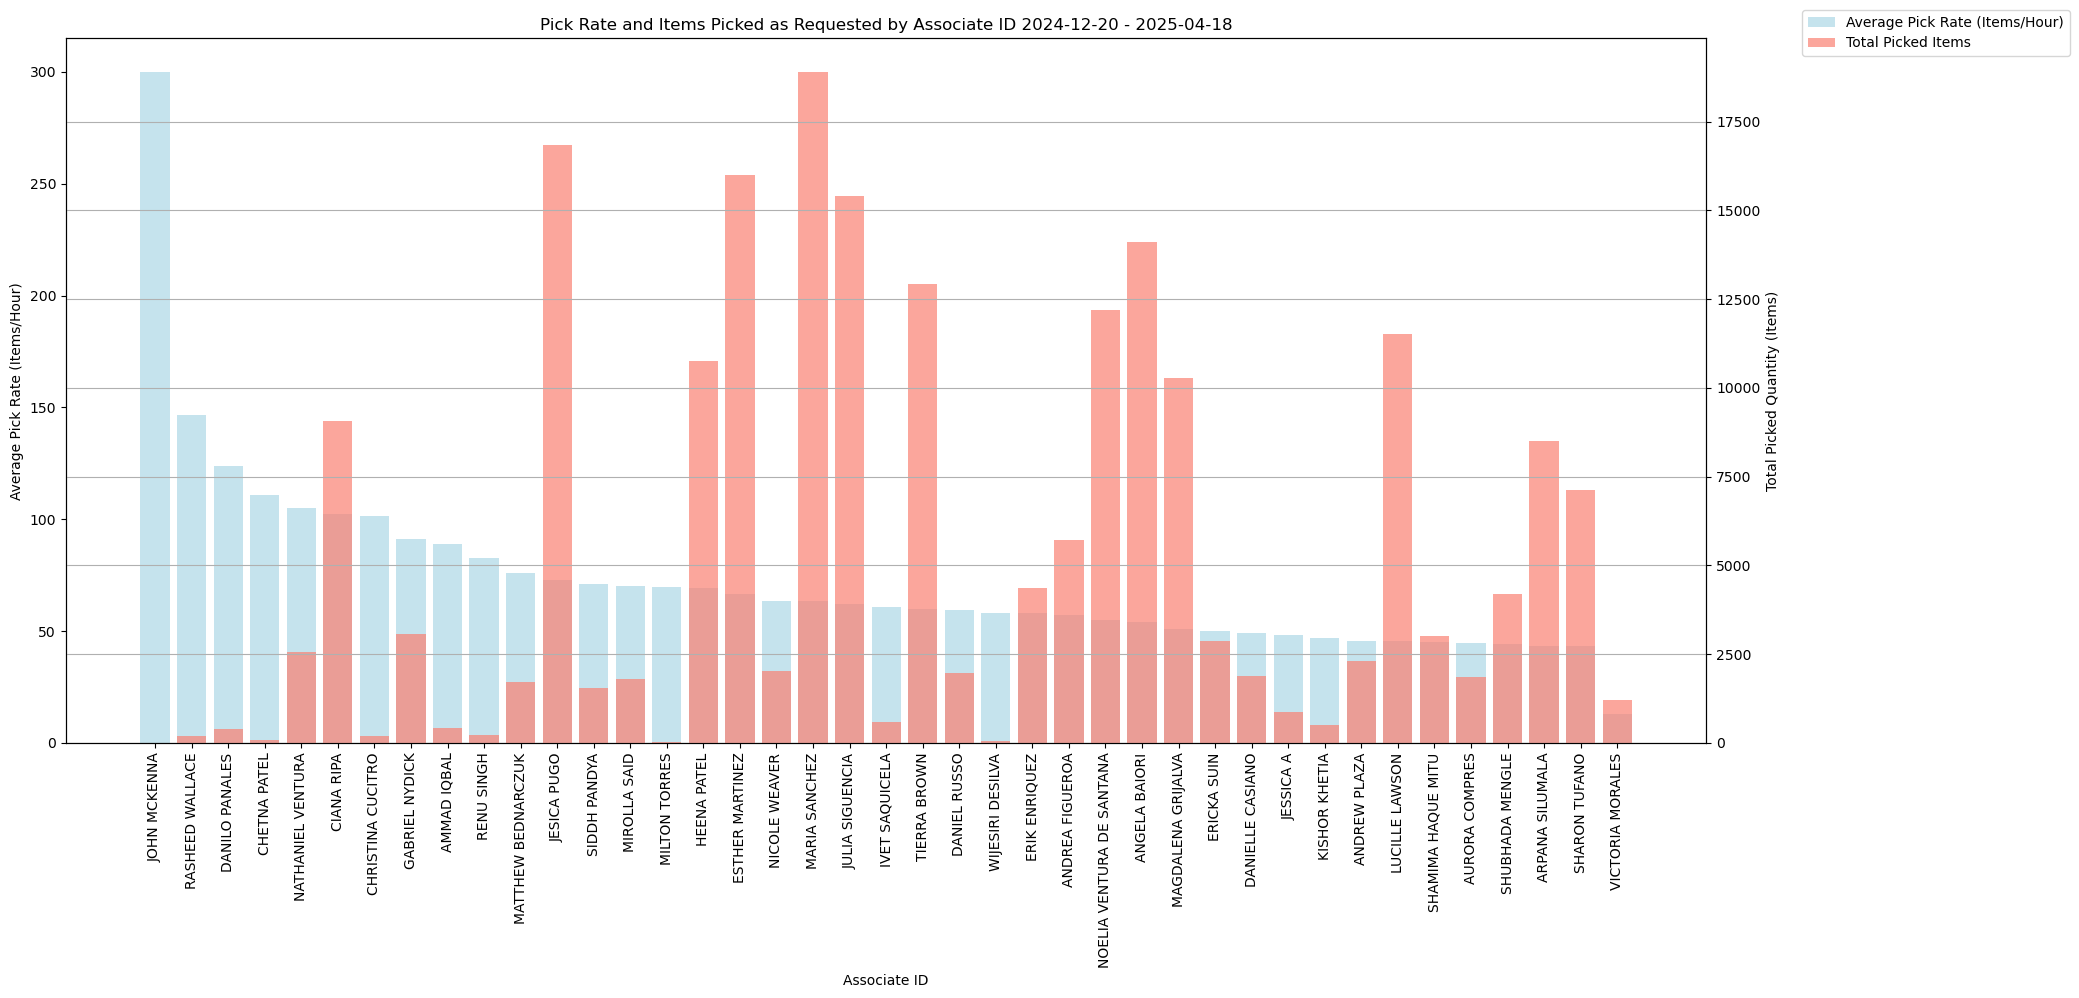

In [323]:
# Ensure columns like 'Picked As Req Qty' are numeric and handle any missing data
df['Picked As Req Qty'] = pd.to_numeric(df['Picked As Req Qty'], errors='coerce')  # Convert to numeric, coerce errors to NaN
df['Pick Rate'] = pd.to_numeric(df['Pick Rate'], errors='coerce')  # Convert to numeric, coerce errors to NaN
# Ensure columns like 'Picked As Req Qty' are numeric and handle any missing data
df_3266['Picked As Req Qty'] = pd.to_numeric(df_3266['Picked As Req Qty'], errors='coerce')  # Convert to numeric, coerce errors to NaN
df_3266['Pick Rate'] = pd.to_numeric(df_3266['Pick Rate'], errors='coerce')  # Convert to numeric, coerce errors to NaN

df_3266 = df_3266.loc[df_3266['Store #'] == 3266, :]

# Drop rows where the 'Picked As Req Qty' is NaN since we can't sum them
df_clean = df_3266.dropna(subset=['Picked As Req Qty', 'Pick Rate'])

# Grouping by Associate ID and calculating the average Pick Rate and total Picked As Req Qty
avg_pick_rate = df_clean.groupby('Associate')['Pick Rate'].mean().sort_values(ascending=False)
total_picked_qty = df_clean.groupby('Associate')['Picked As Req Qty'].sum()

# Plotting side-by-side bar plot for average Pick Rate and total Picked As Req Qty
fig, ax1 = plt.subplots(figsize=(18, 10))
avg_pick_rate.index = avg_pick_rate.index.astype(str)
total_picked_qty.index = total_picked_qty.index.astype(str)

# Bar plot for average Pick Rate (items per hour)
ax1.bar(avg_pick_rate.index, avg_pick_rate, color='lightblue', alpha=0.7, label='Average Pick Rate (Items/Hour)')
ax1.set_xlabel('Associate ID')
ax1.set_ylabel('Average Pick Rate (Items/Hour)')
ax1.set_title(f'Pick Rate and Items Picked as Requested by Associate ID {oldest_pick_date} - {last_pick_date}')

# Creating a second y-axis for total picked quantity (Items)
ax2 = ax1.twinx()
ax2.bar(total_picked_qty.index, total_picked_qty, color='salmon', alpha=0.7, label='Total Picked Items')
ax2.set_ylabel('Total Picked Quantity (Items)')

# Rotate x-tick labels for Associate ID on ax1
ax1.tick_params(axis='x', rotation=90)

# Adjust layout to prevent overlap
fig.tight_layout()

# Adding a legend for both bars
fig.legend(loc='upper left', bbox_to_anchor=(1, 1))

#Display grid over plot
plt.grid()
# Display the plot
plt.show()


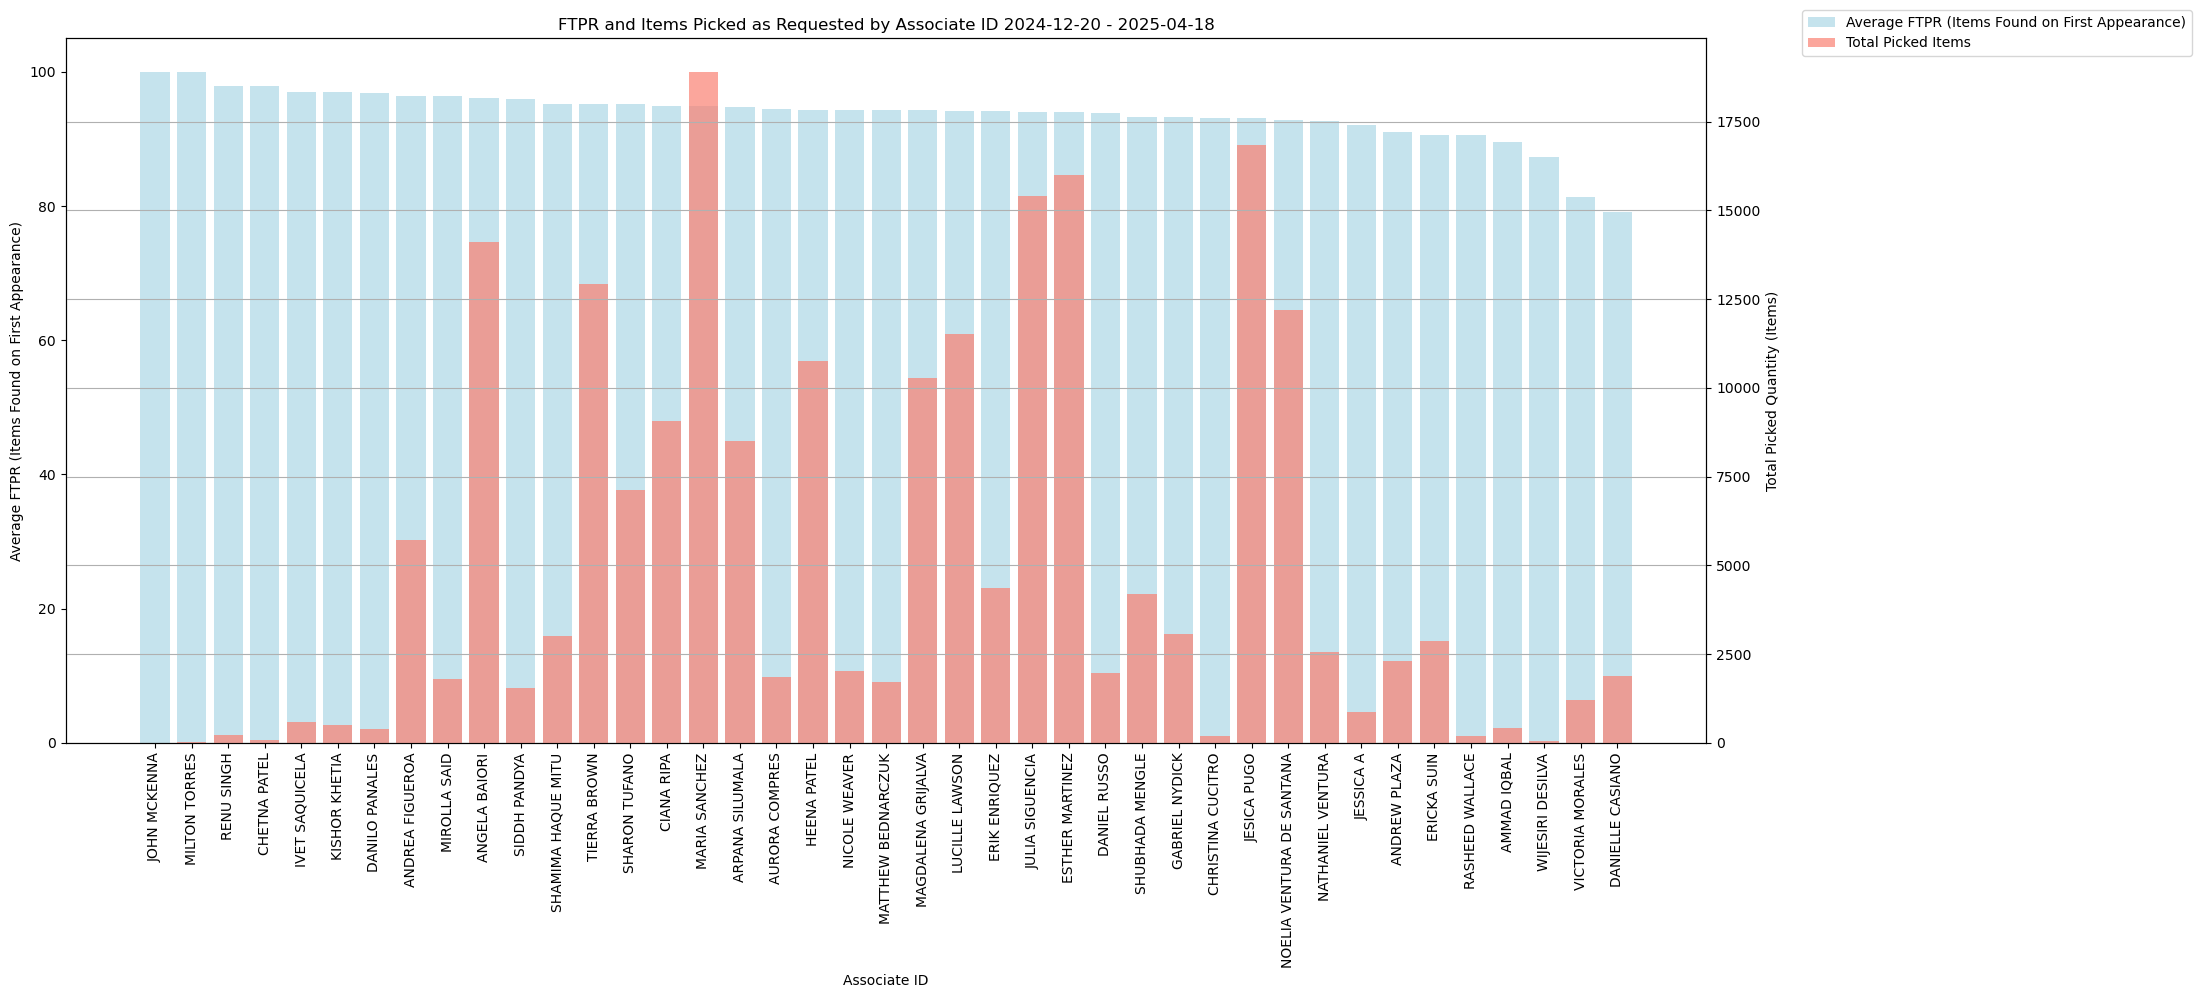

In [324]:
# Ensure columns like 'Picked As Req Qty' are numeric and handle any missing data
df['Picked As Req Qty'] = pd.to_numeric(df['Picked As Req Qty'], errors='coerce')  # Convert to numeric, coerce errors to NaN
df['FTPR'] = pd.to_numeric(df['FTPR'], errors='coerce')  # Convert to numeric, coerce errors to NaN
# Ensure columns like 'Picked As Req Qty' are numeric and handle any missing data
df_3266['Picked As Req Qty'] = pd.to_numeric(df_3266['Picked As Req Qty'], errors='coerce')  # Convert to numeric, coerce errors to NaN
df_3266['FTPR'] = pd.to_numeric(df_3266['FTPR'], errors='coerce')  # Convert to numeric, coerce errors to NaN

# Drop rows where the 'Picked As Req Qty' is NaN since we can't sum them
df_clean = df_3266.dropna(subset=['Picked As Req Qty', 'FTPR'])

# Grouping by Associate ID and calculating the average Pick Rate and total Picked As Req Qty
avg_ftpr = df_clean.groupby('Associate Name')['FTPR'].mean().astype(float).sort_values(ascending=False)
total_picked_qty = df_clean.groupby('Associate Name')['Picked As Req Qty'].sum()

# Plotting side-by-side bar plot for average Pick Rate and total Picked As Req Qty
fig, ax1 = plt.subplots(figsize=(18, 10))

avg_ftpr.index = avg_ftpr.index.astype(str)
total_picked_qty.index = total_picked_qty.index.astype(str)

# Bar plot for average Pick Rate (items per hour)
ax1.bar(avg_ftpr.index, avg_ftpr, color='lightblue', alpha=0.7, label='Average FTPR (Items Found on First Appearance)')
ax1.set_xlabel('Associate ID')
ax1.set_ylabel('Average FTPR (Items Found on First Appearance)')
ax1.set_title(f'FTPR and Items Picked as Requested by Associate ID {oldest_pick_date} - {last_pick_date}')

# Creating a second y-axis for total picked quantity (Items)
ax2 = ax1.twinx()
ax2.bar(total_picked_qty.index, total_picked_qty, color='salmon', alpha=0.7, label='Total Picked Items')
ax2.set_ylabel('Total Picked Quantity (Items)')

# Rotate x-tick labels for Associate ID on ax1
ax1.tick_params(axis='x', rotation=90)

# Adjust layout to prevent overlap
fig.tight_layout()

# Adding a legend for both bars
fig.legend(loc='upper left', bbox_to_anchor=(1, 1))

#Display grid over plot
plt.grid()
# Display the plot
plt.show()

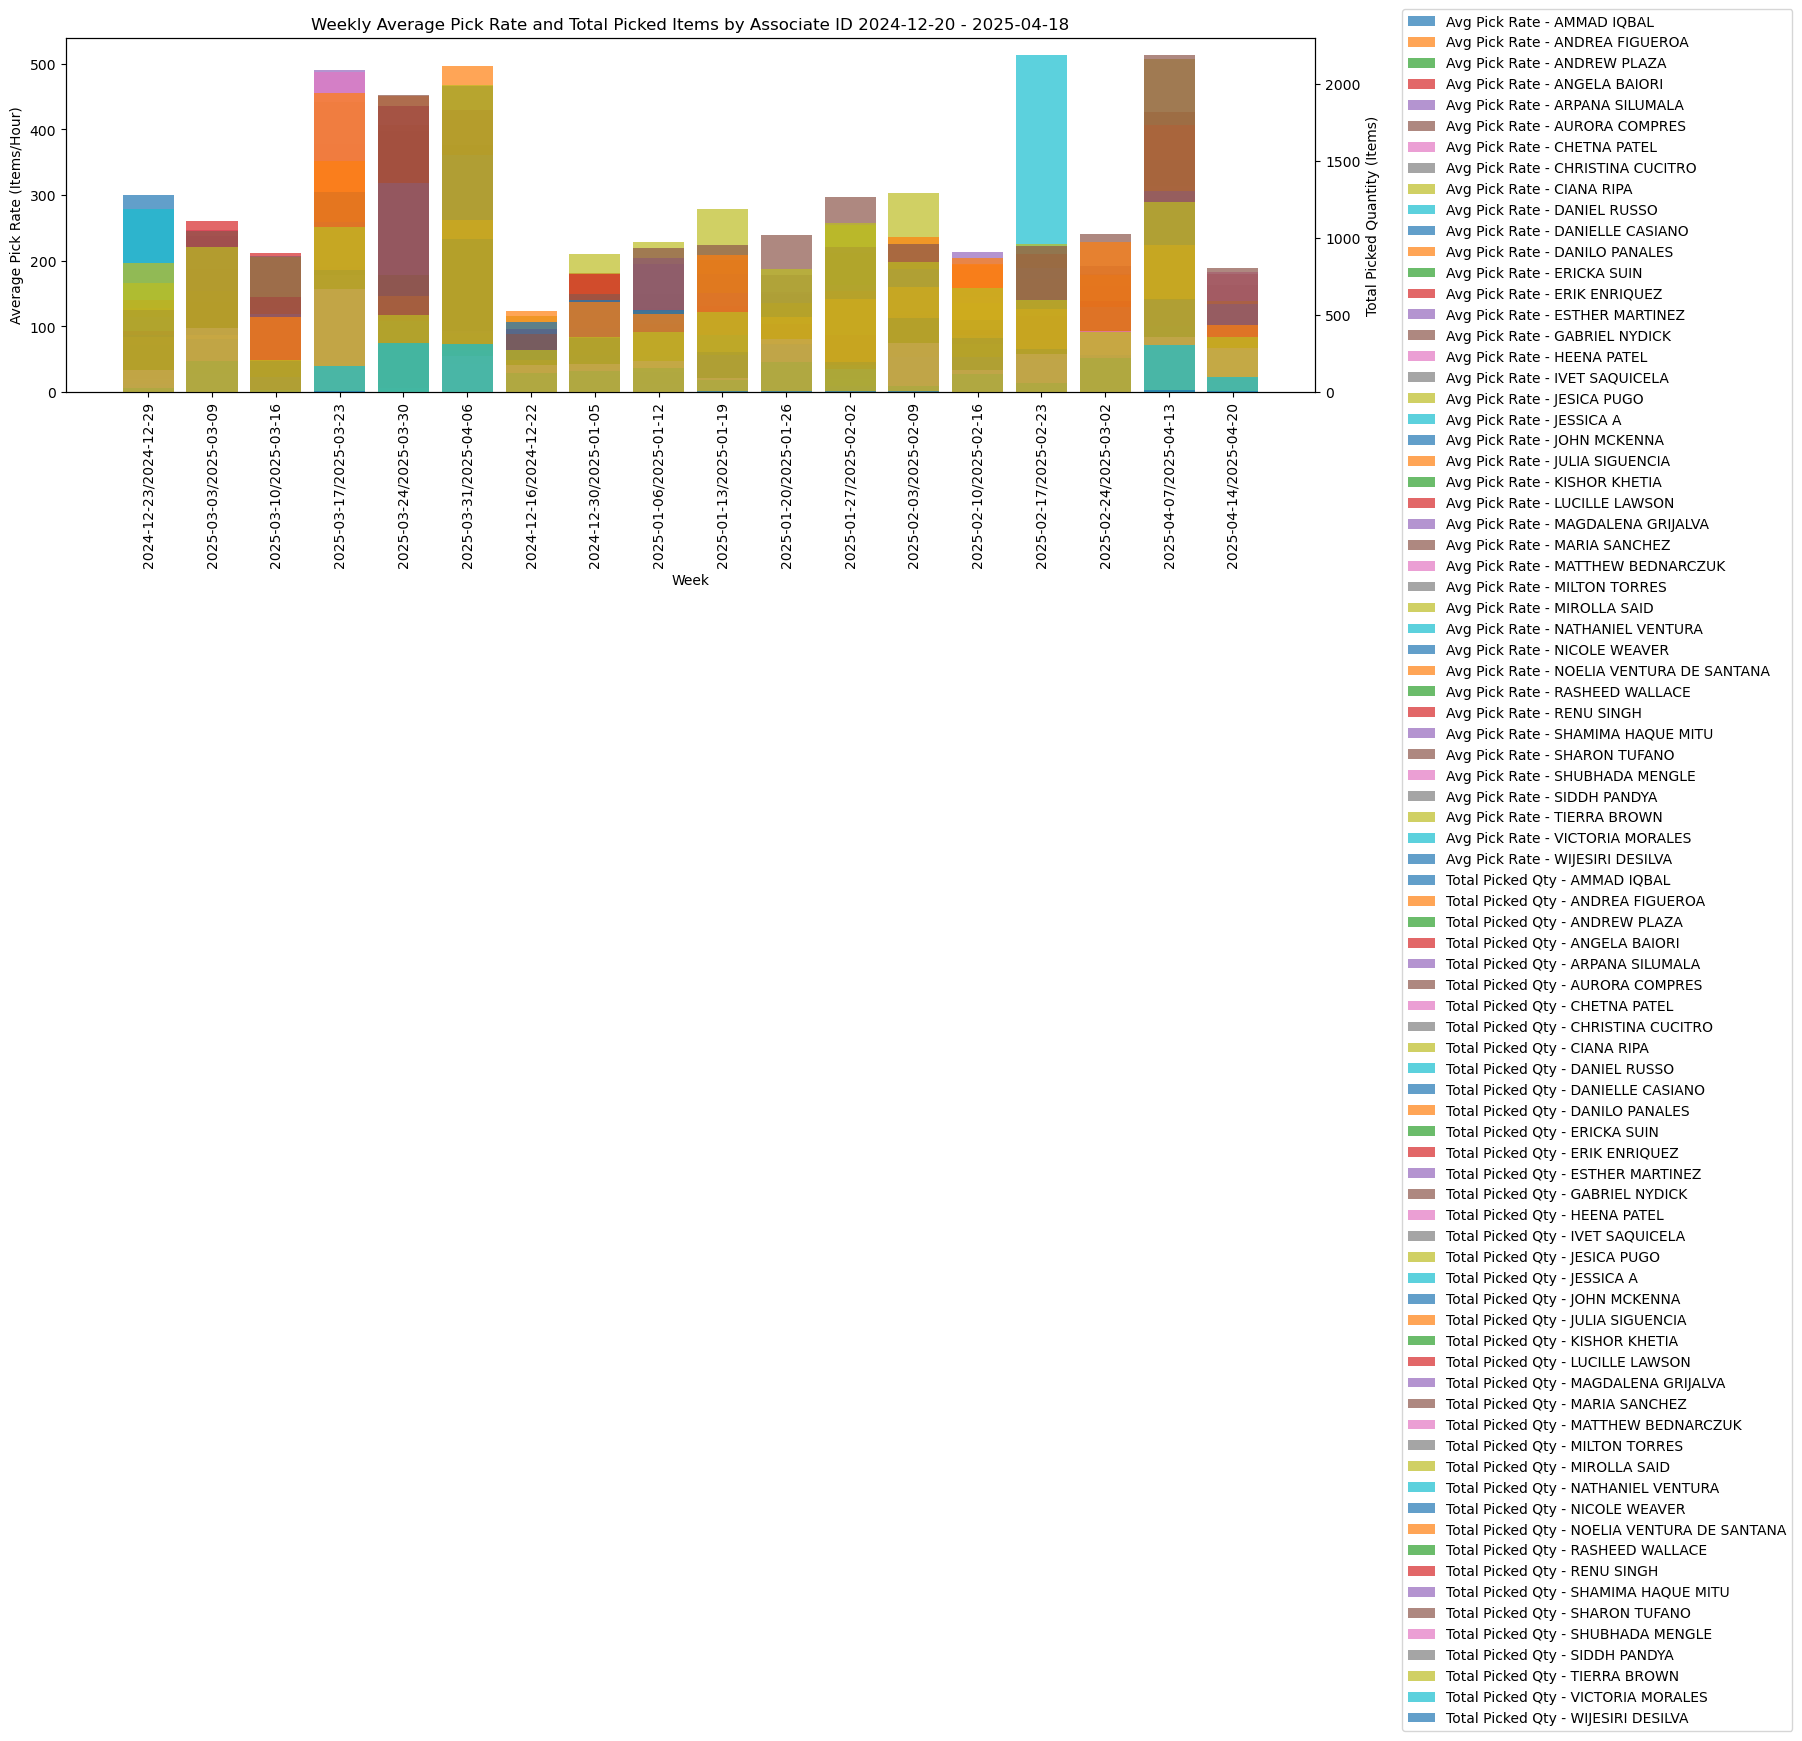

In [325]:
# Ensure columns like 'Picked As Req Qty' and 'Pick Rate' are numeric and handle any missing data
df['Picked As Req Qty'] = pd.to_numeric(df['Picked As Req Qty'], errors='coerce')  # Convert to numeric, coerce errors to NaN
df['Pick Rate'] = pd.to_numeric(df['Pick Rate'], errors='coerce')  # Convert to numeric, coerce errors to NaN
# Ensure columns like 'Picked As Req Qty' and 'Pick Rate' are numeric and handle any missing data
df_3266['Picked As Req Qty'] = pd.to_numeric(df_3266['Picked As Req Qty'], errors='coerce')  # Convert to numeric, coerce errors to NaN
df_3266['Pick Rate'] = pd.to_numeric(df_3266['Pick Rate'], errors='coerce')  # Convert to numeric, coerce errors to NaN

# Drop rows where the 'Picked As Req Qty' is NaN since we can't sum them
df_clean = df_3266.dropna(subset=['Picked As Req Qty', 'Pick Rate'])

# Grouping by Associate ID and week (using 'Day of Pick Date' for weekly grouping)
# We're using pd.Grouper to group by week and Associate ID
df_clean['Week'] = df_clean['Day of Pick Date'].dt.to_period('W')

# Group by Week and Associate ID to calculate the sum of 'Picked As Req Qty' and average 'Pick Rate'
weekly_data = df_clean.groupby(['Week', 'Associate Name']).agg(
    avg_pick_rate=('Pick Rate', 'mean'),
    total_picked_qty=('Picked As Req Qty', 'sum')
).reset_index()

# Plotting side-by-side bar plot for average Pick Rate and total Picked As Req Qty by Week
fig, ax1 = plt.subplots(figsize=(14, 6))

# Bar plot for average Pick Rate (items per hour) by Week
for label, data in weekly_data.groupby('Associate Name'):
    ax1.bar(data['Week'].astype(str), data['avg_pick_rate'], label=f'Avg Pick Rate - {label}', alpha=0.7)

ax1.set_xlabel('Week')
ax1.set_ylabel('Average Pick Rate (Items/Hour)')
ax1.set_title(f'Weekly Average Pick Rate and Total Picked Items by Associate ID {oldest_pick_date} - {last_pick_date}')

# Creating a second y-axis for total picked quantity (Items)
ax2 = ax1.twinx()

# Bar plot for total Picked As Req Qty by Week
for label, data in weekly_data.groupby('Associate Name'):
    ax2.bar(data['Week'].astype(str), data['total_picked_qty'], label=f'Total Picked Qty - {label}', alpha=0.7)

ax2.set_ylabel('Total Picked Quantity (Items)')

# Rotate x-tick labels for Week
ax1.tick_params(axis='x', rotation=90)

# Adjust layout to prevent overlap
fig.tight_layout()

# Adding a legend for both bars
fig.legend(loc='upper left', bbox_to_anchor=(1, 1))

# Display the plot
plt.show()


In [326]:
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from imblearn.over_sampling import RandomOverSampler

'''# Assuming X and y are your features and target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check class distribution in y_train
print("Class distribution in y_train:")
print(Counter(y_train))

# Check class distribution in y_test
print("\nClass distribution in y_test:")
print(Counter(y_test))

# Oversample the minority class
ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

# Initialize and train the model
model = RandomForestClassifier(random_state=42)
model.fit(X_train_resampled, y_train_resampled)

# Get probabilistic predictions (probabilities of the positive class)
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Convert probabilities to binary predictions for accuracy, precision, recall, and f1 score
threshold = 0.5  # You can adjust this threshold as needed
y_pred = (y_pred_proba >= threshold).astype(int)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)  # Use probabilistic predictions here

print(f"\nAccuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"ROC AUC Score: {roc_auc:.2f}")'''

'# Assuming X and y are your features and target variable\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)\n\n# Check class distribution in y_train\nprint("Class distribution in y_train:")\nprint(Counter(y_train))\n\n# Check class distribution in y_test\nprint("\nClass distribution in y_test:")\nprint(Counter(y_test))\n\n# Oversample the minority class\nros = RandomOverSampler(random_state=42)\nX_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)\n\n# Initialize and train the model\nmodel = RandomForestClassifier(random_state=42)\nmodel.fit(X_train_resampled, y_train_resampled)\n\n# Get probabilistic predictions (probabilities of the positive class)\ny_pred_proba = model.predict_proba(X_test)[:, 1]\n\n# Convert probabilities to binary predictions for accuracy, precision, recall, and f1 score\nthreshold = 0.5  # You can adjust this threshold as needed\ny_pred = (y_pred_proba >= threshold).astype(int)\n\n# Calculate metrics\n

In [327]:
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import GridSearchCV

# Assuming df is the DataFrame containing your data
threshold_pick_rate = 50
threshold_ftpr = 97.5
'''df['Handled_Exceptions'] = ((df['Pick Rate'] < threshold_pick_rate) | 
                            (df['FTPR'] > threshold_ftpr)).astype(int)'''
df['Handled_Exceptions'] = (
    (df['Pick Rate'] < threshold_pick_rate) | 
    (df['FTPR'] > threshold_ftpr) | 
    (df['Exception Qty Req to Pick'] > 0) | 
    (df['Exception Nil Pick Qty'] > 0)
).astype(int)

print(df['Handled_Exceptions'].value_counts())

features = ['FTPR', 'Pick Rate', 'Pick Hours', 'Qty Req to Pick', 'Picked As Req Qty']
target = 'Handled_Exceptions'
X = df[features]
y = df[target]

# Check if there are at least two classes in y
if len(np.unique(y)) < 2:
    print("Only one class present in the target variable. Cannot calculate ROC AUC score.")
else:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Check if there are at least two classes in both y_train and y_test
    if len(np.unique(y_train)) < 2 or len(np.unique(y_test)) < 2:
        print("Only one class present in either the training or test set. Cannot calculate ROC AUC score.")
    else:
        model = RandomForestClassifier(random_state=42)
        model.fit(X_train, y_train)
        
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        
        # Calculate ROC AUC score only if there are at least two classes in y_test
        roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
        
        print(f"Accuracy: {accuracy}")
        print(f"Precision: {precision}")
        print(f"Recall: {recall}")
        print(f"F1 Score: {f1}")
        print(f"ROC AUC: {roc_auc}")

# Perform grid search
param_grid = {
    'n_estimators': [10, 50, 100],
    'max_depth': [None, 5, 10]
}
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Score: {grid_search.best_score_}")

# Calculate cross-validation score
cross_val_scores = cross_val_score(grid_search.best_estimator_, X_train, y_train, cv=5, n_jobs=-1)
print(f"Cross-Validation Scores: {cross_val_scores}")

Handled_Exceptions
0    5559
1    3773
Name: count, dtype: int64
Accuracy: 0.8291376539903589
Precision: 0.8883248730964467
Recall: 0.6748071979434447
F1 Score: 0.7669831994156319
ROC AUC: 0.862231806260785
Best Parameters: {'max_depth': 5, 'n_estimators': 50}
Best Score: 0.853985264567984
Cross-Validation Scores: [0.85733423 0.85733423 0.8506363  0.85666443 0.84795713]


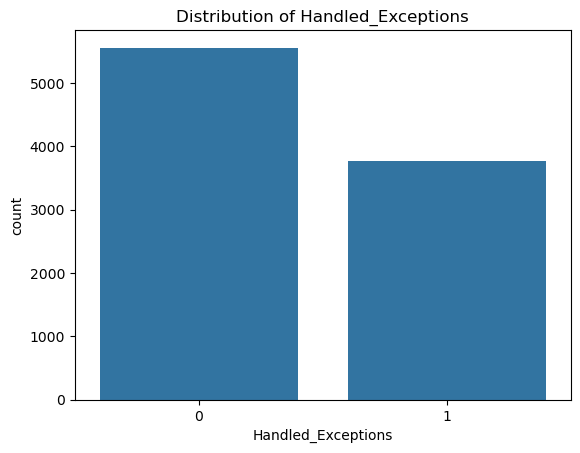

In [328]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='Handled_Exceptions', data=df)
plt.title('Distribution of Handled_Exceptions')
plt.show()


In [329]:
start_time = time.time()
# Threshold ranges to test
threshold_pick_rate_values = np.linspace(5, 500, 8)  # Adjusted range, 100 
#print(threshold_pick_rate_values)
threshold_ftpr_values = np.linspace(70, 105, 12)       # Adjusted range, 300

# Variables to store the best thresholds and corresponding F1 score
best_thresholds = None
best_f1_score = -np.inf  # Initialize to a very low value
results = []  # Store results for each threshold combination

# Debugging: Check initial conditions
#print("Initial Threshold Values:")
#print(f"Pick Rate Thresholds: {threshold_pick_rate_values}")
#print(f"FTPR Thresholds: {threshold_ftpr_values}")

# Iterate through threshold combinations
for threshold_pick_rate in threshold_pick_rate_values:
    for threshold_ftpr in threshold_ftpr_values:
        # Create target variable based on thresholds
        df['Handled_Exceptions'] = ((df['Pick Rate'] < threshold_pick_rate) |
                                    (df['FTPR'] > threshold_ftpr)).astype(int)
        y = df['Handled_Exceptions']
        X = df[['FTPR', 'Pick Rate', 'Pick Hours', 'Qty Req to Pick', 'Picked As Req Qty']]

        # Debugging: Check class distribution
        #print(f"Testing thresholds: Pick Rate={threshold_pick_rate}, FTPR={threshold_ftpr}")
        #print(f"Class distribution in 'y': {np.unique(y, return_counts=True)}")
        
        # Skip if there is only one class in the target variable
        if len(np.unique(y)) < 2:
            #print("Skipping: Only one class present in target variable")
            continue

        # Split data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # Skip if train/test split results in a single class
        if len(np.unique(y_train)) < 2 or len(np.unique(y_test)) < 2:
            #print("Skipping: Only one class present in train/test sets")
            continue

        # Train a Random Forest model
        model = RandomForestClassifier(random_state=42) ############### n_jobs
        model.fit(X_train, y_train)

        # Make predictions and calculate F1 score
        y_pred = model.predict(X_test)
        f1 = f1_score(y_test, y_pred)

        # Debugging: Print F1 score for the current thresholds
        #print(f"F1 Score for thresholds {threshold_pick_rate}, {threshold_ftpr}: {f1}")

        # Update the best thresholds if current F1 is higher
        if f1 > best_f1_score:
            best_f1_score = f1
            best_thresholds = (threshold_pick_rate, threshold_ftpr)
            #print(f"Updated Best Thresholds: {best_thresholds} with F1={best_f1_score}")

        # Store the results for analysis
        results.append({
            'Pick Rate Threshold': threshold_pick_rate,
            'FTPR Threshold': threshold_ftpr,
            'F1 Score': f1
        })

# Convert results to a DataFrame for easy analysis
results_df = pd.DataFrame(results)

# Display the best thresholds and their corresponding F1 score
if best_thresholds is None:
    print("No valid threshold combination was found. Adjust thresholds or data distribution.")
else:
    print(f"Best Thresholds: Pick Rate={best_thresholds[0]}, FTPR={best_thresholds[1]}")
    print(f"Best F1 Score: {best_f1_score}")

# Optional: Summarize all tested threshold combinations
if not results_df.empty:
    print("Summary of Top Threshold Combinations:")
    print(results_df.sort_values(by='F1 Score', ascending=False).head())
else:
    print("No valid results were generated.")
end_time = time.time()
print(f'time to run model for {threshold_pick_rate_values.size * threshold_ftpr_values.size} combinations: {end_time - start_time}')

Best Thresholds: Pick Rate=5.0, FTPR=70.0
Best F1 Score: 1.0
Summary of Top Threshold Combinations:
    Pick Rate Threshold  FTPR Threshold  F1 Score
0              5.000000       70.000000       1.0
21            75.714286       98.636364       1.0
28           146.428571       82.727273       1.0
30           146.428571       89.090909       1.0
31           146.428571       92.272727       1.0
time to run model for 96 combinations: 9.886743783950806


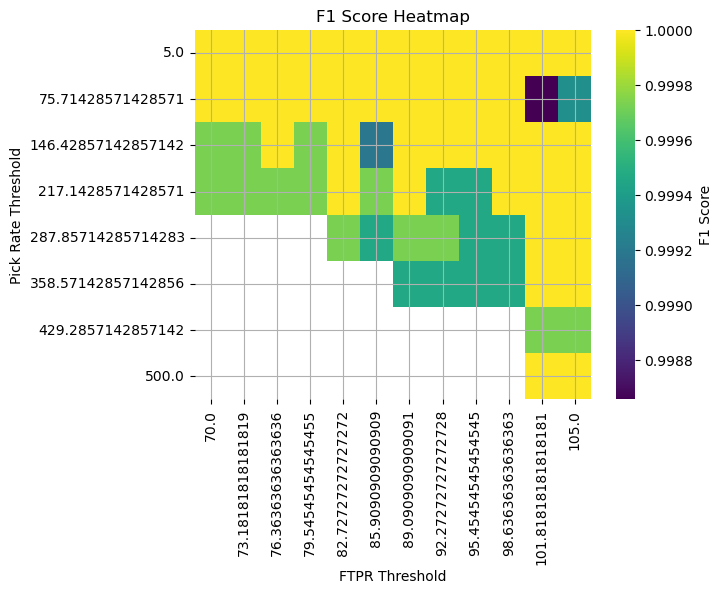

In [330]:
# Ensure results_df is not empty
if not results_df.empty:
    # Rename columns for compatibility with pivot (optional, just for consistency)
    results_df.rename(columns={
        'Pick Rate Threshold': 'pick_rate',
        'FTPR Threshold': 'ftpr',
        'F1 Score': 'f1'
    }, inplace=True)

    # Create pivot table
    pivot_table = results_df.pivot(index='pick_rate', columns='ftpr', values='f1')

    # Generate heatmap
    sns.heatmap(pivot_table, annot=False, fmt=".3f", cmap="viridis", cbar_kws={'label': 'F1 Score'})
    plt.title("F1 Score Heatmap")
    plt.xlabel("FTPR Threshold")
    plt.ylabel("Pick Rate Threshold")
    plt.grid()
    plt.show()
else:
    print("No data to plot. Ensure valid results are generated before creating a heatmap.")

In [331]:
print(df['Pick Rate'].describe())
print(df['FTPR'].describe())
print(df['Handled_Exceptions'].value_counts())
feature_importances = model.feature_importances_
for feature, importance in zip(features, feature_importances):
    print(f"{feature}: {importance}")


count    9332.000000
mean       90.910116
std        48.632321
min         0.000000
25%        59.400000
50%        86.500000
75%       114.300000
max       720.000000
Name: Pick Rate, dtype: float64
count    9332.000000
mean       90.857261
std         8.791980
min         0.000000
25%        88.560000
50%        92.150000
75%        95.240000
max       157.140000
Name: FTPR, dtype: float64
Handled_Exceptions
1    9317
0      15
Name: count, dtype: int64
FTPR: 0.002892847622199401
Pick Rate: 0.8918601724938187
Pick Hours: 0.0557558259260223
Qty Req to Pick: 0.021728974411223838
Picked As Req Qty: 0.02776217954673572


<h2>Composite Scoring Starts Here</h2>
<h4>Composite Scoring Modifiers for standardized evaluation throughtout notebook</h4>
<ul>pickrate_modifier</ul>
<ul>ftpr_modifier</ul>
<ul>picked_as_req_modifier</ul>

<h1>Composite Score Modifiers</h1>

In [332]:
pickrate_modifier = 0.6
ftpr_modifier = 0.2
picked_as_req_modifier = 0.2
picked_as_req_composite_threshold = 50

<h3>Weekly Averages (WTD)</h3>

In [333]:
import datetime as dt
today = dt.datetime.today()
today = today.strftime("%Y-%m-%d")
week_of_interest = df["Week"].max() #defaults to most recent week

# Filter the data for the specified week
df_week = df[df['Week'] == week_of_interest]
df_week = df_week.loc[df_week['Store #'] == 3266, :]

this_week_df = df_week
avdf = this_week_df.groupby(['Associate ID', 'Associate Name']).mean(numeric_only=True)
avdf['Week'] = week_of_interest
avdf['Custom Week Start'] = df_week['Custom Week Start'].max()
avdf['Custom Week End'] = df_week['Custom Week End'].max()
print(f'avdf columns: {avdf.columns}')
print(f'df columns: {df.columns}')
# Specify the week for analysis
#week_of_interest = '2025-01-18 to 2025-01-24' #manual range
#week_of_interest = df["Week"].max() #defaults to most recent week

# Filter the data for the specified week
#avdf_week = avdf[avdf['Week'] == week_of_interest]
print(f'avdf rows: {avdf.shape[0]}')
avdf.head(avdf.shape[0])

avdf columns: Index(['Store #', 'FTPR', 'FTP Expected', 'FTP Actual', 'Pick Rate', 'Picked As Req Qty', 'Substitution Qty', 'Ovrd Qty', 'Nil Pick Qty', 'Exception Qty Req to Pick', 'Exception Picked As Req Qty', 'Exception Substitution Qty', 'Exception Nil Pick Qty', 'Qty Req to Pick', 'Handled_Exceptions', 'Week', 'Custom Week Start', 'Custom Week End'], dtype='object')
df columns: Index(['Associate ID', 'Associate Name', 'Store #', 'Day of Pick Date', 'FTPR', 'FTP Expected', 'FTP Actual', 'Pick Rate', 'Pick Hours', 'Picked As Req Qty', 'Substitution Qty', 'Ovrd Qty', 'Nil Pick Qty', 'Exception Qty Req to Pick', 'Exception Picked As Req Qty', 'Exception Substitution Qty', 'Exception Nil Pick Qty', 'First Pick Assgn Qty', 'First Disp Pick Qty', 'Qty Req to Pick', 'Associate', 'Custom Week Start', 'Custom Week End', 'Week', 'Handled_Exceptions'], dtype='object')
avdf rows: 27


,,Store #,FTPR,FTP Expected,FTP Actual,Pick Rate,Picked As Req Qty,Substitution Qty,Ovrd Qty,Nil Pick Qty,Exception Qty Req to Pick,Exception Picked As Req Qty,Exception Substitution Qty,Exception Nil Pick Qty,Qty Req to Pick,Handled_Exceptions,Week,Custom Week Start,Custom Week End
Associate ID,Associate Name,,,,,,,,,,,,,,,,,,
a0b0ad9,ANGELA BAIORI,3266.0,94.048333,242.000000,225.833333,52.950000,232.666667,5.333333,0.0,7.666667,0.333333,0.166667,0.000000,0.166667,242.000000,1.0,2025-04-12 to 2025-04-18,2025-04-12,2025-04-18
a0p0fc6,ANDREW PLAZA,3266.0,80.740000,64.500000,58.750000,45.025000,61.750000,1.000000,0.0,1.500000,0.250000,0.250000,0.000000,0.000000,64.500000,1.0,2025-04-12 to 2025-04-18,2025-04-12,2025-04-18
a0s1jgx,ARPANA SILUMALA,3266.0,93.990000,233.000000,219.000000,48.500000,219.000000,0.000000,0.0,13.000000,1.000000,1.000000,0.000000,0.000000,233.000000,1.0,2025-04-12 to 2025-04-18,2025-04-12,2025-04-18
c0c116s,CHRISTINA CUCITRO,3266.0,100.000000,4.000000,4.000000,163.600000,4.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,1.0,2025-04-12 to 2025-04-18,2025-04-12,2025-04-18
c0r0k4h,CIANA RIPA,3266.0,93.307143,160.714286,149.714286,84.928571,153.285714,4.142857,0.0,2.714286,1.000000,0.142857,0.000000,0.857143,160.714286,1.0,2025-04-12 to 2025-04-18,2025-04-12,2025-04-18
d0c0as3,DANIELLE CASIANO,3266.0,87.500000,23.333333,22.000000,71.016667,22.000000,0.000000,0.0,0.000000,16.000000,4.666667,0.000000,11.333333,23.333333,1.0,2025-04-12 to 2025-04-18,2025-04-12,2025-04-18
d0r0khi,DANIEL RUSSO,3266.0,92.485000,64.500000,60.500000,57.250000,61.500000,2.250000,0.0,1.000000,1.500000,0.250000,0.000000,1.250000,64.500000,1.0,2025-04-12 to 2025-04-18,2025-04-12,2025-04-18
dapanal,DANILO PANALES,3266.0,75.000000,1.250000,0.750000,34.175000,0.750000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.250000,1.0,2025-04-12 to 2025-04-18,2025-04-12,2025-04-18
e0e04sh,ERIK ENRIQUEZ,3266.0,88.835000,103.500000,92.500000,45.375000,96.000000,2.250000,0.0,8.750000,0.250000,0.000000,0.000000,0.250000,103.500000,1.0,2025-04-12 to 2025-04-18,2025-04-12,2025-04-18


<h3>Weekly Averages (LW)</h3>

In [334]:
today = dt.datetime.today()
today = today.strftime("%Y-%m-%d")

df_3266 = df.loc[df['Store #'] == 3266, :]
# Find the last full week's end date (before today)
last_full_week_end = df['Custom Week End'][df['Custom Week End'] < today].max()

# Get the corresponding start date for that week
last_full_week_start = df['Custom Week Start'][df['Custom Week End'] == last_full_week_end].max()

df_lw = df[(df['Custom Week End'] == last_full_week_end) | (df['Custom Week Start'] == last_full_week_start)] #All stores in market 178
df_lw = df_3266[(df_3266['Custom Week End'] == last_full_week_end) | (df_3266['Custom Week Start'] == last_full_week_start)]

avdf = df_lw.groupby(['Associate ID', 'Associate Name']).mean(numeric_only=True)
avdf['Week'] = last_full_week_start.strftime('%Y-%m-%d') + " to " + last_full_week_end.strftime('%Y-%m-%d')
avdf['Custom Week Start'] = last_full_week_start
avdf['Custom Week End'] = last_full_week_end
print(f'avdf row count: {avdf.shape[0]}')
avdf.head(avdf.shape[0])


avdf row count: 27


,,Store #,FTPR,FTP Expected,FTP Actual,Pick Rate,Picked As Req Qty,Substitution Qty,Ovrd Qty,Nil Pick Qty,Exception Qty Req to Pick,Exception Picked As Req Qty,Exception Substitution Qty,Exception Nil Pick Qty,Qty Req to Pick,Handled_Exceptions,Week,Custom Week Start,Custom Week End
Associate ID,Associate Name,,,,,,,,,,,,,,,,,,
a0b0ad9,ANGELA BAIORI,3266.0,94.048333,242.000000,225.833333,52.950000,232.666667,5.333333,0.0,7.666667,0.333333,0.166667,0.000000,0.166667,242.000000,1.0,2025-04-12 to 2025-04-18,2025-04-12,2025-04-18
a0p0fc6,ANDREW PLAZA,3266.0,80.740000,64.500000,58.750000,45.025000,61.750000,1.000000,0.0,1.500000,0.250000,0.250000,0.000000,0.000000,64.500000,1.0,2025-04-12 to 2025-04-18,2025-04-12,2025-04-18
a0s1jgx,ARPANA SILUMALA,3266.0,93.990000,233.000000,219.000000,48.500000,219.000000,0.000000,0.0,13.000000,1.000000,1.000000,0.000000,0.000000,233.000000,1.0,2025-04-12 to 2025-04-18,2025-04-12,2025-04-18
c0c116s,CHRISTINA CUCITRO,3266.0,100.000000,4.000000,4.000000,163.600000,4.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,1.0,2025-04-12 to 2025-04-18,2025-04-12,2025-04-18
c0r0k4h,CIANA RIPA,3266.0,93.307143,160.714286,149.714286,84.928571,153.285714,4.142857,0.0,2.714286,1.000000,0.142857,0.000000,0.857143,160.714286,1.0,2025-04-12 to 2025-04-18,2025-04-12,2025-04-18
d0c0as3,DANIELLE CASIANO,3266.0,87.500000,23.333333,22.000000,71.016667,22.000000,0.000000,0.0,0.000000,16.000000,4.666667,0.000000,11.333333,23.333333,1.0,2025-04-12 to 2025-04-18,2025-04-12,2025-04-18
d0r0khi,DANIEL RUSSO,3266.0,92.485000,64.500000,60.500000,57.250000,61.500000,2.250000,0.0,1.000000,1.500000,0.250000,0.000000,1.250000,64.500000,1.0,2025-04-12 to 2025-04-18,2025-04-12,2025-04-18
dapanal,DANILO PANALES,3266.0,75.000000,1.250000,0.750000,34.175000,0.750000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.250000,1.0,2025-04-12 to 2025-04-18,2025-04-12,2025-04-18
e0e04sh,ERIK ENRIQUEZ,3266.0,88.835000,103.500000,92.500000,45.375000,96.000000,2.250000,0.0,8.750000,0.250000,0.000000,0.000000,0.250000,103.500000,1.0,2025-04-12 to 2025-04-18,2025-04-12,2025-04-18


In [335]:
# Define a composite score for each row (or use one metric like 'Pick Rate' directly)
df['Composite Score'] = (
    picked_as_req_modifier * df['Picked As Req Qty'] +  # Weight for Items Picked
    pickrate_modifier * df['Pick Rate'] +       # Weight for Pick Rate
    ftpr_modifier * df['FTPR']              # Weight for FTPR
)

# Find the best day for each associate
#best_days = df.loc[df.groupby('Associate Name')['Composite Score'].idxmax()] #all stores in market 178
df_3266 = df.loc[df['Store #'] == 3266, :]
best_days = df_3266.loc[df_3266.groupby('Associate Name')['Composite Score'].idxmax()]

# Sort associates by their best day's composite score unfiltered
top_associates = best_days.sort_values(by=['Composite Score', 'Day of Pick Date'], ascending=[False, False])

# Display the top associates and their best day
print(top_associates[['Associate Name', 'Day of Pick Date', 'Picked As Req Qty', 'Pick Rate', 'FTPR', 'Composite Score']].head(10))

# Filter out associates with fewer than a certain number of items picked
best_days_filtered = best_days[best_days['Picked As Req Qty'] > picked_as_req_composite_threshold]

# Sort associates by their best day's composite score filtered
top_associates_filtered = best_days_filtered.sort_values(by=['Composite Score', 'Day of Pick Date'], ascending=[False, False])

# Display the top associates and their best day after pick qty filtered
print(f'\nAfter filtering out Associates with < 50 Picked As Req Qty')
print(top_associates_filtered[['Associate Name', 'Day of Pick Date', 'Picked As Req Qty', 'Pick Rate', 'FTPR', 'Composite Score']].head(10))

         Associate Name Day of Pick Date  Picked As Req Qty  Pick Rate    FTPR  Composite Score
359      GABRIEL NYDICK       2025-01-30                  2      720.0  100.00          452.400
2846  NATHANIEL VENTURA       2025-02-21                  1      514.0  100.00          328.600
244      DANILO PANALES       2025-01-28                  4      379.0  100.00          248.200
177          CIANA RIPA       2025-01-13                192      300.0   83.12          235.024
444        JOHN MCKENNA       2024-12-24                  6      300.0  100.00          201.200
2483    RASHEED WALLACE       2025-03-20                  2      300.0  100.00          200.400
2611        HEENA PATEL       2025-03-15                522      102.3   97.56          185.292
810        TIERRA BROWN       2025-02-02                469      105.0   99.79          176.758
147   CHRISTINA CUCITRO       2024-12-31                  4      253.0  100.00          172.600
309     ESTHER MARTINEZ       2025-01-30

In [336]:
#df.loc[df["Associate ID"] == 'n0v0359']

<h2>Top Composite Score of the Week</h2>

In [337]:
#Top Associate Per Week
# Aggregate metrics for each associate per week
df_picked_as_req_qty_filter = df_3266[df_3266['Picked As Req Qty'] > picked_as_req_composite_threshold]
cols_to_convert = ['Picked As Req Qty', 'Pick Rate', 'FTPR', 'Pick Hours']
df_picked_as_req_qty_filter[cols_to_convert] = df_picked_as_req_qty_filter[cols_to_convert].apply(pd.to_numeric, errors='coerce')

weekly_performance = df_picked_as_req_qty_filter.groupby(['Custom Week Start', 'Associate Name'], as_index=False).agg({
    'Picked As Req Qty': 'sum',  # Total items picked in the week
    'Pick Rate': 'mean',       # Average pick rate for the week
    'FTPR': 'mean',            # Average FTPR for the week
    'Pick Hours': 'sum'        # Total hours worked in the week (optional)
})

# Add a composite score to rank performance in each week
weekly_performance['Composite Score'] = (
    picked_as_req_modifier * weekly_performance['Picked As Req Qty'] +
    pickrate_modifier * weekly_performance['Pick Rate'] +
    ftpr_modifier * weekly_performance['FTPR']
)

# Sort associates within each week by Composite Score
weekly_performance = weekly_performance.sort_values(by=['Custom Week Start', 'Composite Score'], ascending=[True, False])

# Add a rank column within each week
weekly_performance['Rank'] = weekly_performance.groupby('Custom Week Start')['Composite Score'].rank(method='dense', ascending=False)

# Get the top associate for each week
top_associates_per_week = weekly_performance[weekly_performance['Rank'] == 1]

# Display the results
#print(top_associates_per_week[['Custom Week Start', 'Associate Name', 'Picked As Req Qty', 'Pick Rate', 'FTPR', 'Composite Score']])
top_associates_per_week[['Custom Week Start', 'Associate Name', 'Picked As Req Qty', 'Pick Rate', 'FTPR', 'Composite Score']]


/var/folders/2j/nzc_1qtn5cqfxtll2x7hdpnm0000gn/T/ipykernel_28826/2655115012.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_picked_as_req_qty_filter[cols_to_convert] = df_picked_as_req_qty_filter[cols_to_convert].apply(pd.to_numeric, errors='coerce')


,Custom Week Start,Associate Name,Picked As Req Qty,Pick Rate,FTPR,Composite Score
2,2024-12-14,JULIA SIGUENCIA,336,68.000000,92.020000,126.404000
19,2024-12-21,JESICA PUGO,771,62.200000,92.556000,210.031200
45,2024-12-28,JESICA PUGO,921,85.000000,93.254000,253.850800
69,2025-01-04,MARIA SANCHEZ,896,62.500000,95.310000,235.762000
81,2025-01-11,CIANA RIPA,368,228.000000,89.645000,228.329000
110,2025-01-18,MARIA SANCHEZ,1048,72.000000,96.088000,272.017600
128,2025-01-25,MARIA SANCHEZ,916,65.250000,97.060000,241.762000
144,2025-02-01,JESICA PUGO,1216,81.000000,95.465000,310.893000
163,2025-02-08,JESICA PUGO,936,79.000000,93.292500,253.258500
188,2025-02-15,MARIA SANCHEZ,990,66.600000,95.292000,257.018400


<h2>WTD Composite Score Rankings</h2>

In [338]:
# Calculate Composite Score (can modify the weights here as needed)
df['Composite Score'] = (df['Pick Rate'] * pickrate_modifier) + (df['FTPR'] * ftpr_modifier) + (df['Picked As Req Qty'] * picked_as_req_modifier)

# Filter rows where Picked As Req Qty is less than num
df_3266 = df.loc[df['Store #'] == 3266, :]
num = 1
df_filtered = df[df['Picked As Req Qty'] >= num] #all stores in market 178
df_filtered = df_3266[df_3266['Picked As Req Qty'] >= num]

# Specify the week for analysis
week_of_interest = '2025-01-18 to 2025-01-24' #manual range
week_of_interest = df["Week"].max() #defaults to most recent week

# Filter the data for the specified week
df_week = df_filtered[df_filtered['Week'] == week_of_interest]

# Get the best day per associate within the week based on Composite Score
best_day_of_week = df_week.loc[df_week.groupby('Associate Name')['Composite Score'].idxmax()]
best_day_of_week = best_day_of_week.loc[best_day_of_week['Picked As Req Qty'] >= picked_as_req_composite_threshold]

# Rank the associates based on Composite Score within the week
best_day_of_week['Rank'] = best_day_of_week['Composite Score'].rank(ascending=False, method='min')

# Sort by rank (ascending gives top performer first)
best_day_of_week_sorted = best_day_of_week.sort_values(by='Rank')

# Display the results
print('WTD Composite Scores')
print(f'Week: {week_of_interest}')
#print(best_day_of_week_sorted[['Associate Name', 'Day of Pick Date', 'Pick Rate', 'FTPR', 'Picked As Req Qty', 'Composite Score', 'Rank']])
best_day_of_week_printdf = best_day_of_week_sorted[['Associate Name', 'Day of Pick Date', 'Pick Rate', 'FTPR', 'Picked As Req Qty', 'Composite Score', 'Rank']]
best_day_of_week_printdf.head(30)

WTD Composite Scores
Week: 2025-04-12 to 2025-04-18


,Associate Name,Day of Pick Date,Pick Rate,FTPR,Picked As Req Qty,Composite Score,Rank
1862,MARIA SANCHEZ,2025-04-15,67.4,97.49,349,129.738,1.0
1921,JESICA PUGO,2025-04-12,78.5,91.51,306,126.602,2.0
1859,HEENA PATEL,2025-04-15,64.7,91.61,310,119.142,3.0
1881,ANGELA BAIORI,2025-04-13,61.5,91.44,315,118.188,4.0
1860,JULIA SIGUENCIA,2025-04-15,67.6,91.99,275,113.958,5.0
1812,CIANA RIPA,2025-04-18,74.5,93.51,245,112.402,6.0
1858,ESTHER MARTINEZ,2025-04-15,67.1,93.80,243,107.620,7.0
1837,TIERRA BROWN,2025-04-17,65.4,94.55,243,106.750,8.0
1877,NOELIA VENTURA DE SANTANA,2025-04-14,57.1,92.93,263,105.446,9.0
1835,NATHANIEL VENTURA,2025-04-17,102.2,87.60,120,102.840,10.0


<h2>Composite Score Rankings LW</h2>

In [339]:
# Calculate Composite Score
df['Composite Score'] = (
    (df['Pick Rate'] * pickrate_modifier) + 
    (df['FTPR'] * ftpr_modifier) + 
    (df['Picked As Req Qty'] * picked_as_req_modifier)
)

df_3266 = df.loc[df['Store #'] == 3266, :]
# Set today’s date
today = datetime.now()

# Find the last full week's end date (before today)
last_full_week_end = df_3266['Custom Week End'][df_3266['Custom Week End'] < today].max()

# Get the corresponding start date for that week
last_full_week_start = df_3266['Custom Week Start'][df_3266['Custom Week End'] == last_full_week_end].max()

# Filter data for the last full week
df_week = df_3266[(df_3266['Custom Week Start'] == last_full_week_start) & (df_3266['Custom Week End'] == last_full_week_end)]

# Get the best day per associate within the last full week based on Composite Score
best_day_of_week = df_week.loc[df_week.groupby('Associate Name')['Composite Score'].idxmax()].copy()

# Filter out associates with fewer than the composite threshold
best_day_of_week = best_day_of_week.loc[best_day_of_week['Picked As Req Qty'] >= picked_as_req_composite_threshold]
# Rank associates by Composite Score (descending order)
best_day_of_week['Rank'] = best_day_of_week['Composite Score'].rank(ascending=False, method='min')

# Sort by rank
best_day_of_week_sorted = best_day_of_week.sort_values(by='Rank')

# Display results
print('LW Composite Scores')
print(f'Week: {last_full_week_start.date()} - {last_full_week_end.date()}')
#print(best_day_of_week_sorted[['Associate Name', 'Day of Pick Date', 'Pick Rate', 'FTPR', 'Picked As Req Qty', 'Composite Score', 'Rank']].head(15))
best_day_of_week_sorted[['Associate Name', 'Day of Pick Date', 'Pick Rate', 'FTPR', 'Picked As Req Qty', 'Composite Score', 'Rank']].head(30)

LW Composite Scores
Week: 2025-04-12 - 2025-04-18


,Associate Name,Day of Pick Date,Pick Rate,FTPR,Picked As Req Qty,Composite Score,Rank
1862,MARIA SANCHEZ,2025-04-15,67.4,97.49,349,129.738,1.0
1921,JESICA PUGO,2025-04-12,78.5,91.51,306,126.602,2.0
1859,HEENA PATEL,2025-04-15,64.7,91.61,310,119.142,3.0
1881,ANGELA BAIORI,2025-04-13,61.5,91.44,315,118.188,4.0
1860,JULIA SIGUENCIA,2025-04-15,67.6,91.99,275,113.958,5.0
1812,CIANA RIPA,2025-04-18,74.5,93.51,245,112.402,6.0
1858,ESTHER MARTINEZ,2025-04-15,67.1,93.80,243,107.620,7.0
1837,TIERRA BROWN,2025-04-17,65.4,94.55,243,106.750,8.0
1877,NOELIA VENTURA DE SANTANA,2025-04-14,57.1,92.93,263,105.446,9.0
1835,NATHANIEL VENTURA,2025-04-17,102.2,87.60,120,102.840,10.0


<h2>Lowest Performing Associates by Day LW (Composite Score)</h2>

In [340]:
# Get the best day per associate within the last full week based on Composite Score
worst_day_of_week = df_week.loc[df_week.groupby('Associate Name')['Composite Score'].idxmin()].copy()

# Rank associates by Composite Score (descending order)
worst_day_of_week['Rank'] = worst_day_of_week['Composite Score'].rank(ascending=False, method='min')

# Sort by rank
worst_day_of_week_sorted = worst_day_of_week.sort_values(by='Rank', ascending=False)

# Display results
print('Lowest Performing Associates by Day LW (Composite Score)')
print(f'Week: {last_full_week_start.date()} - {last_full_week_end.date()}')
#print(best_day_of_week_sorted[['Associate Name', 'Day of Pick Date', 'Pick Rate', 'FTPR', 'Picked As Req Qty', 'Composite Score', 'Rank']].head(15))
worst_day_of_week_sorted[['Associate Name', 'Day of Pick Date', 'Pick Rate', 'FTPR', 'Picked As Req Qty', 'Composite Score', 'Rank']].head(15)

Lowest Performing Associates by Day LW (Composite Score)
Week: 2025-04-12 - 2025-04-18


,Associate Name,Day of Pick Date,Pick Rate,FTPR,Picked As Req Qty,Composite Score,Rank
1871,DANILO PANALES,2025-04-14,0.0,0.00,0,0.000,27.0
1838,VICTORIA MORALES,2025-04-17,5.7,50.00,9,15.220,26.0
1810,ANDREW PLAZA,2025-04-18,8.8,50.00,1,15.480,25.0
1915,DANIELLE CASIANO,2025-04-12,21.3,75.00,6,28.980,24.0
1885,ERICKA SUIN,2025-04-13,16.9,93.94,31,35.128,23.0
1848,MARIA SANCHEZ,2025-04-16,34.5,78.26,18,39.952,22.0
1824,SIDDH PANDYA,2025-04-18,33.9,100.00,8,41.940,21.0
1850,SHAMIMA HAQUE MITU,2025-04-16,35.4,88.89,24,43.818,20.0
1919,GABRIEL NYDICK,2025-04-12,44.9,91.67,22,49.674,19.0
1886,ERIK ENRIQUEZ,2025-04-13,27.3,84.62,83,49.904,18.0


<h2>Lowest FTPR Associates for LW</h2>

In [341]:
lowest_ftpr = df_week.loc[df_week.groupby('Associate Name')['FTPR'].idxmin()].copy()
#lowest_ftpr = df_week.loc[df_week.groupby('Associate Name')['FTPR'] <= 90.0].copy()

lowest_ftpr = lowest_ftpr.loc[lowest_ftpr['FTPR'] <= 90.0]
# Rank associates by Composite Score (descending order)
lowest_ftpr['Rank'] = lowest_ftpr['Composite Score'].rank(ascending=True, method='min')
lowest_ftpr = lowest_ftpr.sort_values(by='FTPR', ascending=True)
# Display results
print('Lowest FTPR WTD <= 90.0 %')
print(f'Week: {last_full_week_start.date()} - {last_full_week_end.date()}')
#print(best_day_of_week_sorted[['Associate Name', 'Day of Pick Date', 'Pick Rate', 'FTPR', 'Picked As Req Qty', 'Composite Score', 'Rank']].head(15))
lowest_ftpr[['Associate Name', 'Day of Pick Date', 'Pick Rate', 'FTPR', 'Picked As Req Qty', 'Composite Score', 'Rank']]


Lowest FTPR WTD <= 90.0 %
Week: 2025-04-12 - 2025-04-18


,Associate Name,Day of Pick Date,Pick Rate,FTPR,Picked As Req Qty,Composite Score,Rank
1871,DANILO PANALES,2025-04-14,0.0,0.00,0,0.000,1.0
1810,ANDREW PLAZA,2025-04-18,8.8,50.00,1,15.480,3.0
1838,VICTORIA MORALES,2025-04-17,5.7,50.00,9,15.220,2.0
1842,DANIELLE CASIANO,2025-04-16,83.4,75.00,12,67.440,10.0
1848,MARIA SANCHEZ,2025-04-16,34.5,78.26,18,39.952,4.0
1831,GABRIEL NYDICK,2025-04-17,86.1,80.00,112,90.060,16.0
1924,NATHANIEL VENTURA,2025-04-12,65.0,81.82,77,70.764,11.0
1886,ERIK ENRIQUEZ,2025-04-13,27.3,84.62,83,49.904,5.0
1875,JULIA SIGUENCIA,2025-04-14,59.2,85.11,235,99.542,17.0
1917,ERICKA SUIN,2025-04-12,50.4,85.54,142,75.748,14.0


<h2>Model to Predict FTPR and Pick Rate</h2>

In [342]:
'''
WORKS, BUT DOES NOT HAVE ALL 3 METRICS. USE FURTHER CELL FOR MODELS
'''

'''
# Import necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

start_time = time.time()
# Define features (X) and target variables (y)
X = df[['Pick Hours', 'Qty Req to Pick', 'Picked As Req Qty', 
        'Substitution Qty', 'Nil Pick Qty', 'Exception Qty Req to Pick', 
        'Exception Picked As Req Qty', 'Exception Substitution Qty', 'Exception Nil Pick Qty']]
y_ftpr = df['FTPR']
y_pick_rate = df['Pick Rate']

# Split data into training and testing sets
X_train, X_test, y_train_ftpr, y_test_ftpr = train_test_split(X, y_ftpr, test_size=0.2, random_state=42)
_, _, y_train_pick_rate, y_test_pick_rate = train_test_split(X, y_pick_rate, test_size=0.2, random_state=42)

# Scale features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train a Random Forest Regressor model for FTPR prediction
model_ftpr = RandomForestRegressor(random_state=42)

# Define hyperparameter tuning space for GridSearchCV
param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Perform hyperparameter tuning using GridSearchCV for FTPR prediction
grid_search_ftpr = GridSearchCV(model_ftpr, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_ftpr.fit(X_train_scaled, y_train_ftpr)

# Print best parameters and corresponding score for FTPR prediction
print("Best Parameters for FTPR:", grid_search_ftpr.best_params_)
print("Best Score for FTPR:", -grid_search_ftpr.best_score_)

# Train a model with the best parameters and evaluate on test data for FTPR prediction
best_model_ftpr = grid_search_ftpr.best_estimator_
y_pred_ftpr = best_model_ftpr.predict(X_test_scaled)
ftpr_mse = mean_squared_error(y_test_ftpr, y_pred_ftpr)
ftpr_r2 = r2_score(y_test_ftpr, y_pred_ftpr)

# Print evaluation metrics for FTPR prediction
print("FTPR Prediction Metrics:")
print(f"MSE: {ftpr_mse}")
print(f"R2 Score: {ftpr_r2}")

# Train a Random Forest Regressor model for Pick Rate prediction
model_pick_rate = RandomForestRegressor(random_state=42)

# Perform hyperparameter tuning using GridSearchCV for Pick Rate prediction
grid_search_pick_rate = GridSearchCV(model_pick_rate, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_pick_rate.fit(X_train_scaled, y_train_pick_rate)

# Print best parameters and corresponding score for Pick Rate prediction
print("Best Parameters for Pick Rate:", grid_search_pick_rate.best_params_)
print("Best Score for Pick Rate:", -grid_search_pick_rate.best_score_)

# Train a model with the best parameters and evaluate on test data for Pick Rate prediction
best_model_pick_rate = grid_search_pick_rate.best_estimator_
y_pred_pick_rate = best_model_pick_rate.predict(X_test_scaled)
pick_rate_mse = mean_squared_error(y_test_pick_rate, y_pred_pick_rate)
pick_rate_r2 = r2_score(y_test_pick_rate, y_pred_pick_rate)

# Print evaluation metrics for Pick Rate prediction
print("Pick Rate Prediction Metrics:")
print(f"MSE: {pick_rate_mse}")
print(f"R2 Score: {pick_rate_r2}")

# Use the trained models to predict performance for each associate in df
df['Predicted FTPR'] = best_model_ftpr.predict(scaler.transform(X))
df['Predicted Pick Rate'] = best_model_pick_rate.predict(scaler.transform(X))

end_time = time.time()
print(f'Total time: {end_time - start_time}')
# Print predicted metrics for each associate
for associate_id in df['Associate ID'].unique():
    associate_df = df[df['Associate ID'] == associate_id]
    print(f"Associate ID: {associate_id}")
    print("Predicted Metrics:")
    print(associate_df[['FTPR', 'Pick Rate', 'Predicted FTPR', 'Predicted Pick Rate']])
    print()
df.head(10)
'''

'\n# Import necessary libraries\nfrom sklearn.model_selection import train_test_split\nfrom sklearn.ensemble import RandomForestRegressor\nfrom sklearn.metrics import mean_squared_error, r2_score\nfrom sklearn.preprocessing import StandardScaler\nfrom sklearn.model_selection import GridSearchCV\n\nstart_time = time.time()\n# Define features (X) and target variables (y)\nX = df[[\'Pick Hours\', \'Qty Req to Pick\', \'Picked As Req Qty\', \n        \'Substitution Qty\', \'Nil Pick Qty\', \'Exception Qty Req to Pick\', \n        \'Exception Picked As Req Qty\', \'Exception Substitution Qty\', \'Exception Nil Pick Qty\']]\ny_ftpr = df[\'FTPR\']\ny_pick_rate = df[\'Pick Rate\']\n\n# Split data into training and testing sets\nX_train, X_test, y_train_ftpr, y_test_ftpr = train_test_split(X, y_ftpr, test_size=0.2, random_state=42)\n_, _, y_train_pick_rate, y_test_pick_rate = train_test_split(X, y_pick_rate, test_size=0.2, random_state=42)\n\n# Scale features using StandardScaler\nscaler = Stan

<h2>Predicts Team Average values based on all Historical Data</h2>

In [343]:
'''
WORKS, BUT DOES NOT HAVE ALL 3 METRICS. USE FURTHER CELL FOR MODELS
'''

'''

# Adds Picked as Req Qty to predictions

start_time = time.time()
# Define features (X) and target variables (y)
X = df[['Pick Hours', 'Qty Req to Pick', 'Substitution Qty', 
        'Nil Pick Qty', 'Exception Qty Req to Pick', 
        'Exception Picked As Req Qty', 'Exception Substitution Qty', 'Exception Nil Pick Qty']]
y_ftpr = df['FTPR']
y_pick_rate = df['Pick Rate']
y_picked_as_req_qty = df['Picked As Req Qty']

# Split data into training and testing sets
X_train, X_test, y_train_ftpr, y_test_ftpr = train_test_split(X, y_ftpr, test_size=0.2, random_state=42)
_, _, y_train_pick_rate, y_test_pick_rate = train_test_split(X, y_pick_rate, test_size=0.2, random_state=42)
_, _, y_train_picked_as_req_qty, y_test_picked_as_req_qty = train_test_split(X, y_picked_as_req_qty, test_size=0.2, random_state=42)

# Scale features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train a Random Forest Regressor model for FTPR prediction
model_ftpr = RandomForestRegressor(random_state=42)

# Define hyperparameter tuning space for GridSearchCV
param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Perform hyperparameter tuning using GridSearchCV for FTPR prediction
grid_search_ftpr = GridSearchCV(model_ftpr, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_ftpr.fit(X_train_scaled, y_train_ftpr)

# Print best parameters and corresponding score for FTPR prediction
print("Best Parameters for FTPR:", grid_search_ftpr.best_params_)
print("Best Score for FTPR:", -grid_search_ftpr.best_score_)

# Train a model with the best parameters and evaluate on test data for FTPR prediction
best_model_ftpr = grid_search_ftpr.best_estimator_
y_pred_ftpr = best_model_ftpr.predict(X_test_scaled)
ftpr_mse = mean_squared_error(y_test_ftpr, y_pred_ftpr)
ftpr_r2 = r2_score(y_test_ftpr, y_pred_ftpr)

# Print evaluation metrics for FTPR prediction
print("FTPR Prediction Metrics:")
print(f"MSE: {ftpr_mse}")
print(f"R2 Score: {ftpr_r2}")

# Train a Random Forest Regressor model for Pick Rate prediction
model_pick_rate = RandomForestRegressor(random_state=42)

# Perform hyperparameter tuning using GridSearchCV for Pick Rate prediction
grid_search_pick_rate = GridSearchCV(model_pick_rate, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_pick_rate.fit(X_train_scaled, y_train_pick_rate)

# Print best parameters and corresponding score for Pick Rate prediction
print("Best Parameters for Pick Rate:", grid_search_pick_rate.best_params_)
print("Best Score for Pick Rate:", -grid_search_pick_rate.best_score_)

# Train a model with the best parameters and evaluate on test data for Pick Rate prediction
best_model_pick_rate = grid_search_pick_rate.best_estimator_
y_pred_pick_rate = best_model_pick_rate.predict(X_test_scaled)
pick_rate_mse = mean_squared_error(y_test_pick_rate, y_pred_pick_rate)
pick_rate_r2 = r2_score(y_test_pick_rate, y_pred_pick_rate)

# Print evaluation metrics for Pick Rate prediction
print("Pick Rate Prediction Metrics:")
print(f"MSE: {pick_rate_mse}")
print(f"R2 Score: {pick_rate_r2}")

# Train a Random Forest Regressor model for Picked As Req Qty prediction
model_picked_as_req_qty = RandomForestRegressor(random_state=42)

# Perform hyperparameter tuning using GridSearchCV for Picked As Req Qty prediction
grid_search_picked_as_req_qty = GridSearchCV(model_picked_as_req_qty, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_picked_as_req_qty.fit(X_train_scaled, y_train_picked_as_req_qty)

# Print best parameters and corresponding score for Picked As Req Qty prediction
print("Best Parameters for Picked As Req Qty:", grid_search_picked_as_req_qty.best_params_)
print("Best Score for Picked As Req Qty:", -grid_search_picked_as_req_qty.best_score_)

# Train a model with the best parameters and evaluate on test data for Picked As Req Qty prediction
best_model_picked_as_req_qty = grid_search_picked_as_req_qty.best_estimator_
y_pred_picked_as_req_qty = best_model_picked_as_req_qty.predict(X_test_scaled)
picked_as_req_qty_mse = mean_squared_error(y_test_picked_as_req_qty, y_pred_picked_as_req_qty)
picked_as_req_qty_r2 = r2_score(y_test_picked_as_req_qty, y_pred_picked_as_req_qty)

# Print evaluation metrics for Picked As Req Qty prediction
print("Picked As Req Qty Prediction Metrics:")
print(f"MSE: {picked_as_req_qty_mse}")
print(f"R2 Score: {picked_as_req_qty_r2}")

# Use the trained models to predict performance for each associate
predicted_df = pd.DataFrame({
    'FTPR': y_pred_ftpr,
    'Pick Rate': y_pred_pick_rate,
    'Picked As Req Qty': y_pred_picked_as_req_qty
})

print(predicted_df.head())

# Calculate overall metrics
overall_mse = (ftpr_mse + pick_rate_mse + picked_as_req_qty_mse) / 3
overall_r2 = (ftpr_r2 + pick_rate_r2 + picked_as_req_qty_r2) / 3

end_time = time.time()
print(f"Overall MSE: {overall_mse}")
print(f"Overall R2 Score: {overall_r2}")
print(f'Total time: {end_time - start_time}')
######before n_jobs=-1, total time = 85.37645697593689 M4 Max

'''

'\n\n# Adds Picked as Req Qty to predictions\n\nstart_time = time.time()\n# Define features (X) and target variables (y)\nX = df[[\'Pick Hours\', \'Qty Req to Pick\', \'Substitution Qty\', \n        \'Nil Pick Qty\', \'Exception Qty Req to Pick\', \n        \'Exception Picked As Req Qty\', \'Exception Substitution Qty\', \'Exception Nil Pick Qty\']]\ny_ftpr = df[\'FTPR\']\ny_pick_rate = df[\'Pick Rate\']\ny_picked_as_req_qty = df[\'Picked As Req Qty\']\n\n# Split data into training and testing sets\nX_train, X_test, y_train_ftpr, y_test_ftpr = train_test_split(X, y_ftpr, test_size=0.2, random_state=42)\n_, _, y_train_pick_rate, y_test_pick_rate = train_test_split(X, y_pick_rate, test_size=0.2, random_state=42)\n_, _, y_train_picked_as_req_qty, y_test_picked_as_req_qty = train_test_split(X, y_picked_as_req_qty, test_size=0.2, random_state=42)\n\n# Scale features using StandardScaler\nscaler = StandardScaler()\nX_train_scaled = scaler.fit_transform(X_train)\nX_test_scaled = scaler.transf

In [344]:
df.head()

,Associate ID,Associate Name,Store #,Day of Pick Date,FTPR,FTP Expected,FTP Actual,Pick Rate,Pick Hours,Picked As Req Qty,...,Exception Nil Pick Qty,First Pick Assgn Qty,First Disp Pick Qty,Qty Req to Pick,Associate,Custom Week Start,Custom Week End,Week,Handled_Exceptions,Composite Score
10,a0b0ad9,ANGELA BAIORI,3266.0,2025-02-05,97.01,233,227,60.0,3.86,227,...,0,0,0,233,ANGELA BAIORI,2025-02-01,2025-02-07,2025-02-01 to 2025-02-07,1,100.802
12,a0b0ad9,ANGELA BAIORI,3266.0,2025-02-02,97.03,268,254,59.0,4.36,254,...,0,0,0,268,ANGELA BAIORI,2025-02-01,2025-02-07,2025-02-01 to 2025-02-07,1,105.606
13,a0b0ad9,ANGELA BAIORI,3266.0,2024-12-29,92.92,214,199,42.0,4.88,199,...,0,0,0,214,ANGELA BAIORI,2024-12-28,2025-01-03,2024-12-28 to 2025-01-03,1,83.584
14,a0b0ad9,ANGELA BAIORI,3266.0,2024-12-27,100.00,47,47,79.0,0.6,47,...,0,0,0,47,ANGELA BAIORI,2024-12-21,2024-12-27,2024-12-21 to 2024-12-27,1,76.800
15,a0b0ad9,ANGELA BAIORI,3266.0,2024-12-26,92.66,223,212,51.0,4.18,212,...,2,0,0,223,ANGELA BAIORI,2024-12-21,2024-12-27,2024-12-21 to 2024-12-27,1,91.532


In [345]:
'''



was commented out section
'''
'''
# Import necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
import time

start_time = time.time()

# Define features (X) and target variables (y)
X = df[['Pick Hours', 'Qty Req to Pick', 
        'Substitution Qty', 'Nil Pick Qty', 'Exception Qty Req to Pick',
        'Exception Picked As Req Qty', 'Exception Substitution Qty', 'Exception Nil Pick Qty']]
y_ftpr = df['FTPR']
y_pick_rate = df['Pick Rate']
y_picked_as_req_qty = df['Picked As Req Qty']

# Split data into training and testing sets
X_train, X_test, y_train_ftpr, y_test_ftpr = train_test_split(X, y_ftpr, test_size=0.2, random_state=42)
_, _, y_train_pick_rate, y_test_pick_rate = train_test_split(X, y_pick_rate, test_size=0.2, random_state=42)
_, _, y_train_picked_as_req_qty, y_test_picked_as_req_qty = train_test_split(X, y_picked_as_req_qty, test_size=0.2, random_state=42)

# Scale features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train a Random Forest Regressor model for FTPR prediction
model_ftpr = RandomForestRegressor(random_state=42)

# Define hyperparameter tuning space for GridSearchCV
param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Perform hyperparameter tuning using GridSearchCV for FTPR prediction
grid_search_ftpr = GridSearchCV(model_ftpr, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_ftpr.fit(X_train_scaled, y_train_ftpr)

# Print best parameters and corresponding score for FTPR prediction
print("Best Parameters for FTPR:", grid_search_ftpr.best_params_)
print("Best Score for FTPR:", -grid_search_ftpr.best_score_)

# Train a model with the best parameters and evaluate on test data for FTPR prediction
best_model_ftpr = grid_search_ftpr.best_estimator_
y_pred_ftpr = best_model_ftpr.predict(X_test_scaled)
ftpr_mse = mean_squared_error(y_test_ftpr, y_pred_ftpr)
ftpr_r2 = r2_score(y_test_ftpr, y_pred_ftpr)

# Print evaluation metrics for FTPR prediction
print("FTPR Prediction Metrics:")
print(f"MSE: {ftpr_mse}")
print(f"R2 Score: {ftpr_r2}")

# Train a Random Forest Regressor model for Pick Rate prediction
model_pick_rate = RandomForestRegressor(random_state=42)

# Perform hyperparameter tuning using GridSearchCV for Pick Rate prediction
grid_search_pick_rate = GridSearchCV(model_pick_rate, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_pick_rate.fit(X_train_scaled, y_train_pick_rate)

# Print best parameters and corresponding score for Pick Rate prediction
print("Best Parameters for Pick Rate:", grid_search_pick_rate.best_params_)
print("Best Score for Pick Rate:", -grid_search_pick_rate.best_score_)

# Train a model with the best parameters and evaluate on test data for Pick Rate prediction
best_model_pick_rate = grid_search_pick_rate.best_estimator_
y_pred_pick_rate = best_model_pick_rate.predict(X_test_scaled)
pick_rate_mse = mean_squared_error(y_test_pick_rate, y_pred_pick_rate)
pick_rate_r2 = r2_score(y_test_pick_rate, y_pred_pick_rate)

# Print evaluation metrics for Pick Rate prediction
print("Pick Rate Prediction Metrics:")
print(f"MSE: {pick_rate_mse}")
print(f"R2 Score: {pick_rate_r2}")

# Train a Random Forest Regressor model for Picked As Req Qty prediction
model_picked_as_req_qty = RandomForestRegressor(random_state=42)

# Perform hyperparameter tuning using GridSearchCV for Picked As Req Qty prediction
grid_search_picked_as_req_qty = GridSearchCV(model_picked_as_req_qty, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_picked_as_req_qty.fit(X_train_scaled, y_train_picked_as_req_qty)

# Print best parameters and corresponding score for Picked As Req Qty prediction
print("Best Parameters for Picked As Req Qty:", grid_search_picked_as_req_qty.best_params_)
print("Best Score for Picked As Req Qty:", -grid_search_picked_as_req_qty.best_score_)

# Train a model with the best parameters and evaluate on test data for Picked As Req Qty prediction
best_model_picked_as_req_qty = grid_search_picked_as_req_qty.best_estimator_
y_pred_picked_as_req_qty = best_model_picked_as_req_qty.predict(X_test_scaled)
picked_as_req_qty_mse = mean_squared_error(y_test_picked_as_req_qty, y_pred_picked_as_req_qty)
picked_as_req_qty_r2 = r2_score(y_test_picked_as_req_qty, y_pred_picked_as_req_qty)

# Print evaluation metrics for Picked As Req Qty prediction
print("Picked As Req Qty Prediction Metrics:")
print(f"MSE: {picked_as_req_qty_mse}")
print(f"R2 Score: {picked_as_req_qty_r2}")

# Use the trained models to make predictions on the original data
df_predictions = df.copy()
df_predictions['Predicted_FTPR'] = best_model_ftpr.predict(scaler.fit_transform(X))
df_predictions['Predicted_Pick_Rate'] = best_model_pick_rate.predict(scaler.fit_transform(X))
df_predictions['Predicted_Picked_As_Req_Qty'] = best_model_picked_as_req_qty.predict(scaler.fit_transform(X))

end_time = time.time()
print(f"Time taken to execute the script: {end_time - start_time} seconds")'''

'\n# Import necessary libraries\nfrom sklearn.model_selection import train_test_split\nfrom sklearn.ensemble import RandomForestRegressor\nfrom sklearn.metrics import mean_squared_error, r2_score\nfrom sklearn.preprocessing import StandardScaler\nfrom sklearn.model_selection import GridSearchCV\nimport time\n\nstart_time = time.time()\n\n# Define features (X) and target variables (y)\nX = df[[\'Pick Hours\', \'Qty Req to Pick\', \n        \'Substitution Qty\', \'Nil Pick Qty\', \'Exception Qty Req to Pick\',\n        \'Exception Picked As Req Qty\', \'Exception Substitution Qty\', \'Exception Nil Pick Qty\']]\ny_ftpr = df[\'FTPR\']\ny_pick_rate = df[\'Pick Rate\']\ny_picked_as_req_qty = df[\'Picked As Req Qty\']\n\n# Split data into training and testing sets\nX_train, X_test, y_train_ftpr, y_test_ftpr = train_test_split(X, y_ftpr, test_size=0.2, random_state=42)\n_, _, y_train_pick_rate, y_test_pick_rate = train_test_split(X, y_pick_rate, test_size=0.2, random_state=42)\n_, _, y_train_

In [346]:
df.columns

Index(['Associate ID', 'Associate Name', 'Store #', 'Day of Pick Date', 'FTPR', 'FTP Expected', 'FTP Actual', 'Pick Rate', 'Pick Hours', 'Picked As Req Qty', 'Substitution Qty', 'Ovrd Qty', 'Nil Pick Qty', 'Exception Qty Req to Pick', 'Exception Picked As Req Qty', 'Exception Substitution Qty', 'Exception Nil Pick Qty', 'First Pick Assgn Qty', 'First Disp Pick Qty', 'Qty Req to Pick', 'Associate', 'Custom Week Start', 'Custom Week End', 'Week', 'Handled_Exceptions', 'Composite Score'], dtype='object')

<h1>Xgboost Accurate Models</h1>

In [347]:
use_cpu_models = False
if use_cpu_models == False:
    #seems to be accuate
    warnings.filterwarnings("ignore", message=".*XGBoost is not compiled with CUDA support.*")
    warnings.filterwarnings("ignore", category=UserWarning)
    from xgboost import XGBRegressor
    from sklearn.model_selection import train_test_split, GridSearchCV
    from sklearn.metrics import mean_squared_error, r2_score
    from sklearn.preprocessing import StandardScaler
    import joblib, time, os
    import warnings


    start_time = time.time()

    '''X = df[['Pick Hours', 'Qty Req to Pick', 'Picked As Req Qty', 
            'Substitution Qty', 'Nil Pick Qty', 'Exception Qty Req to Pick', 
            'Exception Picked As Req Qty', 'Exception Substitution Qty', 'Exception Nil Pick Qty',
            'First Disp Pick Qty', 'First Pick Assgn Qty']]
    '''
    df['Day of Week'] = pd.to_datetime(df['Day of Pick Date']).dt.dayofweek
    df['IsWeekend'] = df['Day of Week'].isin([5, 6]).astype(int)
    # Optional log transforms
    df['Log Pick Rate'] = np.log1p(df['Pick Rate'])
    df['Log FTPR'] = np.log1p(df['FTPR'])
    df['ExceptionRate'] = (
        df['Exception Qty Req to Pick'] + 
        df['Exception Picked As Req Qty'] + 
        df['Exception Substitution Qty'] + 
        df['Exception Nil Pick Qty']
    ) / (df['Qty Req to Pick'] + 1e-6)

    # -----------------------
    # Feature and Target Setup
    # -----------------------
    feature_cols = [
        'Pick Hours', 'Qty Req to Pick', 'Picked As Req Qty', 
        'Substitution Qty', 'Nil Pick Qty', 'Exception Qty Req to Pick', 
        'Exception Picked As Req Qty', 'Exception Substitution Qty', 
        'Exception Nil Pick Qty', 'First Disp Pick Qty', 'First Pick Assgn Qty',
        'Day of Week', 'IsWeekend', 'Log Pick Rate', 'Log FTPR', 'ExceptionRate'
    ]

    X = df[feature_cols].values.astype(np.float32)
    y_ftpr = df['FTPR']
    y_pick_rate = df['Pick Rate']
    y_picked_as_req_qty = df['Picked As Req Qty']

    # Split and scale
    X_train, X_test, y_train_ftpr, y_test_ftpr = train_test_split(X, y_ftpr, test_size=0.2, random_state=42)
    _, _, y_train_pick_rate, y_test_pick_rate = train_test_split(X, y_pick_rate, test_size=0.2, random_state=42)
    _, _, y_train_picked_as_req_qty, y_test_picked_as_req_qty = train_test_split(X, y_picked_as_req_qty, test_size=0.2, random_state=42)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # GPU-friendly hyperparams
    param_grid = {
        'n_estimators': [100, 300],
        'max_depth': [4, 6, 10],
        'learning_rate': [0.05, 0.1],
        'subsample': [0.7, 1.0],
        'colsample_bytree': [0.7, 1.0]
    }

    # Set base model config with GPU
    base_params = {
        'tree_method': 'hist',  # For GPU (Metal) support on Apple Silicon
        'device': 'cpu',        # Only applies if Metal backend is detected
        'objective': 'reg:squarederror',
        'random_state': 42,
        'verbosity': 1
    }

    # Wrapper function for training
    def train_model(X_train, y_train, X_test, y_test, label):
        model = XGBRegressor(**base_params)
        grid = GridSearchCV(model, param_grid, scoring='neg_mean_squared_error', cv=3, n_jobs=-1)
        grid.fit(X_train, y_train)
        best_model = grid.best_estimator_
        preds = best_model.predict(X_test)
        print(f"{label} MSE: {mean_squared_error(y_test, preds):.4f}")
        print(f"{label} R2: {r2_score(y_test, preds):.4f}")
        return best_model

    best_model_ftpr = train_model(X_train_scaled, y_train_ftpr, X_test_scaled, y_test_ftpr, "FTPR")
    best_model_pick_rate = train_model(X_train_scaled, y_train_pick_rate, X_test_scaled, y_test_pick_rate, "Pick Rate")
    best_model_picked_as_req_qty = train_model(X_train_scaled, y_train_picked_as_req_qty, X_test_scaled, y_test_picked_as_req_qty, "Picked As Req Qty")

    # Add predictions to df
    df['Predicted FTPR'] = best_model_ftpr.predict(scaler.transform(X))
    df['Predicted Pick Rate'] = best_model_pick_rate.predict(scaler.transform(X))
    df['Predicted Picked As Req Qty'] = best_model_picked_as_req_qty.predict(scaler.transform(X))

    # Merge into df_3266
    df_3266 = df_3266.merge(
        df[['Associate ID', 'Predicted FTPR', 'Predicted Pick Rate', 'Predicted Picked As Req Qty']],
        on='Associate ID',
        how='left'
    )

    # Print results per associate
    for name in df_3266['Associate Name'].unique():
        adf = df_3266[df_3266['Associate Name'] == name]
        aid = adf['Associate ID'].iloc[0] if not adf['Associate ID'].isna().all() else "Unknown"
        print(f"Associate ID: {aid} | Associate Name: {name}")
        print(adf[['FTPR', 'Pick Rate', 'Picked As Req Qty', 
                'Predicted FTPR', 'Predicted Pick Rate', 'Predicted Picked As Req Qty']])
        print()

    # Create the directory
    try:
        directory_name = "Models/"
        os.mkdir(directory_name)
        print(f"Directory '{"Models/"}' created successfully.")
        joblib.dump(best_model_ftpr, f'Models/best_model_ftpr_{oldest_pick_date}_{last_pick_date}.pkl')
        joblib.dump(best_model_pick_rate, f'Models/best_model_pick_rate_{oldest_pick_date}_{last_pick_date}.pkl')
        joblib.dump(best_model_picked_as_req_qty, f'Models/best_model_picked_as_req_qty_{oldest_pick_date}_{last_pick_date}.pkl')
    except FileExistsError:
        print(f"Directory '{"Models/"}' already exists.")
        joblib.dump(best_model_ftpr, f'Models/best_model_ftpr_{oldest_pick_date}_{last_pick_date}.pkl')
        joblib.dump(best_model_pick_rate, f'Models/best_model_pick_rate_{oldest_pick_date}_{last_pick_date}.pkl')
        joblib.dump(best_model_picked_as_req_qty, f'Models/best_model_picked_as_req_qty_{oldest_pick_date}_{last_pick_date}.pkl')
    except PermissionError:
        print(f"Permission denied: Unable to create '{directory_name}'.")
    except Exception as e:
        print(f"An error occurred: {e}")

    print(f'Total time: {time.time() - start_time:.2f} seconds')


FTPR MSE: 1.3369
FTPR R2: 0.9824
Pick Rate MSE: 91.3404
Pick Rate R2: 0.9656
Picked As Req Qty MSE: 6.0569
Picked As Req Qty R2: 0.9998
Associate ID: a0b0ad9 | Associate Name: ANGELA BAIORI
         FTPR  Pick Rate  Picked As Req Qty  Predicted FTPR  Predicted Pick Rate  Predicted Picked As Req Qty
0       97.01       60.0                227       96.971092            60.620251                   226.427261
1       97.01       60.0                227       96.958344            58.953705                   254.818878
2       97.01       60.0                227       92.911469            42.227650                   198.594849
3       97.01       60.0                227      100.110924            79.320595                    46.527225
4       97.01       60.0                227       92.704437            50.870476                   211.948212
...       ...        ...                ...             ...                  ...                          ...
111146  98.15       50.0                

In [348]:
if test:

    import numpy as np
    import pandas as pd
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import StandardScaler
    from sklearn.metrics import mean_squared_error, r2_score
    from pytorch_tabnet.tab_model import TabNetRegressor
    import torch
    import os, time, joblib

    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    print(f"Using device: {device}")

    start_time = time.time()

    # Features and targets
    '''X = df[['Pick Hours', 'Qty Req to Pick', 'Picked As Req Qty', 
            'Substitution Qty', 'Nil Pick Qty', 'Exception Qty Req to Pick', 
            'Exception Picked As Req Qty', 'Exception Substitution Qty', 'Exception Nil Pick Qty',
            'First Disp Pick Qty', 'First Pick Assgn Qty']].values
    '''
    df['Day of Week'] = pd.to_datetime(df['Day of Pick Date']).dt.dayofweek
    df['IsWeekend'] = df['Day of Week'].isin([5, 6]).astype(int)
    # Optional log transforms
    df['Log Pick Rate'] = np.log1p(df['Pick Rate'])
    df['Log FTPR'] = np.log1p(df['FTPR'])
    df['ExceptionRate'] = (
        df['Exception Qty Req to Pick'] + 
        df['Exception Picked As Req Qty'] + 
        df['Exception Substitution Qty'] + 
        df['Exception Nil Pick Qty']
    ) / (df['Qty Req to Pick'] + 1e-6)

    # -----------------------
    # Feature and Target Setup
    # -----------------------
    feature_cols = [
        'Pick Hours', 'Qty Req to Pick', 'Picked As Req Qty', 
        'Substitution Qty', 'Nil Pick Qty', 'Exception Qty Req to Pick', 
        'Exception Picked As Req Qty', 'Exception Substitution Qty', 
        'Exception Nil Pick Qty', 'First Disp Pick Qty', 'First Pick Assgn Qty',
        'Day of Week', 'IsWeekend', 'Log Pick Rate', 'Log FTPR', 'ExceptionRate'
    ]

    X = df[feature_cols].values.astype(np.float32)
    targets = {
        "FTPR": df['FTPR'].astype(np.float32).values,
        "Pick Rate": df['Pick Rate'].astype(np.float32).values,
        "Picked As Req Qty": df['Picked As Req Qty'].astype(np.float32).values
    }


    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X).astype(np.float32)
    joblib.dump(scaler, "Models/scaler.pkl")

    def train_tabnet(X, y, label):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        model = TabNetRegressor(
            device_name=device.type,
            seed=42,
            verbose=0
        )

        model.fit(
            X_train=X_train, y_train=y_train.reshape(-1, 1),
            eval_set=[(X_test, y_test.reshape(-1, 1))],
            eval_metric=['rmse'],
            max_epochs=200,
            patience=20,
            batch_size=512,
            virtual_batch_size=64,
            num_workers=0
        )

        preds = model.predict(X_test).flatten()
        print(f"{label} MSE: {mean_squared_error(y_test, preds):.4f}")
        print(f"{label} R2: {r2_score(y_test, preds):.4f}")
        return model

    # Train models
    models = {}
    for label, y in targets.items():
        model = train_tabnet(X_scaled, y, label)
        models[label] = model

    # Add predictions to df
    df['Predicted FTPR'] = models["FTPR"].predict(X_scaled).flatten()
    df['Predicted Pick Rate'] = models["Pick Rate"].predict(X_scaled).flatten()
    df['Predicted Picked As Req Qty'] = models["Picked As Req Qty"].predict(X_scaled).flatten()


    df_3266 = df.loc[df['Store #'] == 3266, :]

    # Print predicted metrics for each associate
    for associate_name in df_3266['Associate Name'].unique():
        associate_df = df_3266[df_3266['Associate Name'] == associate_name]
        associate_id = associate_df['Associate ID'].iloc[0] if not associate_df['Associate ID'].isna().all() else "Unknown"
        
        print(f"Associate ID: {associate_id} | Associate Name: {associate_name}")
        print("Predicted Metrics:")
        print(associate_df[['FTPR', 'Pick Rate', 'Picked As Req Qty', 
                            'Predicted FTPR', 'Predicted Pick Rate', 'Predicted Picked As Req Qty']])
        print()

    # Print results per associate
    '''for name in df_3266['Associate Name'].unique():
        adf = df_3266[df_3266['Associate Name'] == name]
        aid = adf['Associate ID'].iloc[0] if not adf['Associate ID'].isna().all() else "Unknown"
        print(f"Associate ID: {aid} | Associate Name: {name}")
        print(adf[['FTPR', 'Pick Rate', 'Picked As Req Qty', 
                'Predicted FTPR', 'Predicted Pick Rate', 'Predicted Picked As Req Qty']])
        print()
    '''

    # Save models
    os.makedirs("Models/", exist_ok=True)
    for label, model in models.items():
        model.save_model(f'Models/tabnet_model_{label.replace(" ", "_").lower()}_{oldest_pick_date}_{last_pick_date}.zip')

    print(f"Total time: {time.time() - start_time:.2f} seconds")


In [349]:
if test:
    import numpy as np
    import pandas as pd
    import torch
    import os, time, joblib
    from sklearn.model_selection import train_test_split, KFold
    from sklearn.preprocessing import StandardScaler
    from sklearn.metrics import mean_squared_error, r2_score
    from pytorch_tabnet.tab_model import TabNetRegressor

    # Set device
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    print(f"Using device: {device}")
    start_time = time.time()

    # -----------------------
    # Feature Engineering
    # -----------------------
    df['Day of Week'] = pd.to_datetime(df['Day of Pick Date']).dt.dayofweek
    df['IsWeekend'] = df['Day of Week'].isin([5, 6]).astype(int)
    # Optional log transforms
    df['Log Pick Rate'] = np.log1p(df['Pick Rate'])
    df['Log FTPR'] = np.log1p(df['FTPR'])
    df['ExceptionRate'] = (
        df['Exception Qty Req to Pick'] + 
        df['Exception Picked As Req Qty'] + 
        df['Exception Substitution Qty'] + 
        df['Exception Nil Pick Qty']
    ) / (df['Qty Req to Pick'] + 1e-6)

    # -----------------------
    # Feature and Target Setup
    # -----------------------
    feature_cols = [
        'Pick Hours', 'Qty Req to Pick', 'Picked As Req Qty', 
        'Substitution Qty', 'Nil Pick Qty', 'Exception Qty Req to Pick', 
        'Exception Picked As Req Qty', 'Exception Substitution Qty', 
        'Exception Nil Pick Qty', 'First Disp Pick Qty', 'First Pick Assgn Qty',
        'Day of Week', 'IsWeekend', 'Log Pick Rate', 'Log FTPR', 'ExceptionRate'
    ]

    X = df[feature_cols].values.astype(np.float32)

    targets = {
        "FTPR": df['Log FTPR'].astype(np.float32).values,  # using log-transformed
        "Pick Rate": df['Log Pick Rate'].astype(np.float32).values,  # using log-transformed
        "Picked As Req Qty": df['Picked As Req Qty'].astype(np.float32).values
    }

    # Standardization
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X).astype(np.float32)
    joblib.dump(scaler, "Models/scaler.pkl")

    # -----------------------
    # TabNet Training Function
    # -----------------------
    def train_tabnet(X, y, label):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        model = TabNetRegressor(
            n_d=32,
            n_a=32,
            n_steps=5,
            gamma=1.5,
            lambda_sparse=1e-4,
            optimizer_params=dict(lr=2e-2),
            device_name=device.type,
            seed=42,
            verbose=0
        )

        model.fit(
            X_train=X_train, y_train=y_train.reshape(-1, 1),
            eval_set=[(X_test, y_test.reshape(-1, 1))],
            eval_metric=['rmse'],
            max_epochs=500,
            patience=50,
            batch_size=256,
            virtual_batch_size=32,
            num_workers=0
        )

        preds = model.predict(X_test).flatten()

        if "Log" in label:
            preds = np.expm1(preds)
            y_test = np.expm1(y_test)

        print(f"{label} MSE: {mean_squared_error(y_test, preds):.4f}")
        print(f"{label} R2: {r2_score(y_test, preds):.4f}")
        return model

    # -----------------------
    # Train Models
    # -----------------------
    models = {}
    for label, y in targets.items():
        model = train_tabnet(X_scaled, y, label)
        models[label] = model

    # -----------------------
    # Predict on Full Dataset
    # -----------------------
    df['Predicted FTPR'] = np.expm1(models["FTPR"].predict(X_scaled).flatten())  # exp back
    df['Predicted Pick Rate'] = np.expm1(models["Pick Rate"].predict(X_scaled).flatten())
    df['Predicted Picked As Req Qty'] = models["Picked As Req Qty"].predict(X_scaled).flatten()

    # -----------------------
    # Store-Level Breakdown
    # -----------------------
    df_3266 = df[df['Store #'] == 3266]

    for name in df_3266['Associate Name'].unique():
        adf = df_3266[df_3266['Associate Name'] == name]
        aid = adf['Associate ID'].iloc[0] if not adf['Associate ID'].isna().all() else "Unknown"
        print(f"Associate ID: {aid} | Associate Name: {name}")
        print("Predicted Metrics:")
        print(adf[['FTPR', 'Pick Rate', 'Picked As Req Qty',
                'Predicted FTPR', 'Predicted Pick Rate', 'Predicted Picked As Req Qty']])
        print()

    # -----------------------
    # Save Models
    # -----------------------
    os.makedirs("Models/", exist_ok=True)
    for label, model in models.items():
        filename = f'Models/tabnet_model_{label.replace(" ", "_").lower()}_{oldest_pick_date}_{last_pick_date}.zip'
        model.save_model(filename)

    print(f"Total time: {time.time() - start_time:.2f} seconds")


<h2>Use these models to predict Metrics</h2>

In [350]:
# Import necessary libraries
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import time
import joblib


if use_cpu_models:
    start_time = time.time()
    
    added_features = ['First Disp Pick Qty', 'First Pick Assgn Qty']
    # Define features (X) and target variables (y)
    '''X = df[['Pick Hours', 'Qty Req to Pick', 'Picked As Req Qty', 
            'Substitution Qty', 'Nil Pick Qty', 'Exception Qty Req to Pick', 
            'Exception Picked As Req Qty', 'Exception Substitution Qty', 'Exception Nil Pick Qty',
            'First Disp Pick Qty', 'First Pick Assgn Qty']]
            '''
    df['Day of Week'] = pd.to_datetime(df['Day of Pick Date']).dt.dayofweek
    df['IsWeekend'] = df['Day of Week'].isin([5, 6]).astype(int)
    # Optional log transforms
    df['Log Pick Rate'] = np.log1p(df['Pick Rate'])
    df['Log FTPR'] = np.log1p(df['FTPR'])
    df['ExceptionRate'] = (
        df['Exception Qty Req to Pick'] + 
        df['Exception Picked As Req Qty'] + 
        df['Exception Substitution Qty'] + 
        df['Exception Nil Pick Qty']
    ) / (df['Qty Req to Pick'] + 1e-6)

    # -----------------------
    # Feature and Target Setup
    # -----------------------
    feature_cols = [
        'Pick Hours', 'Qty Req to Pick', 'Picked As Req Qty', 
        'Substitution Qty', 'Nil Pick Qty', 'Exception Qty Req to Pick', 
        'Exception Picked As Req Qty', 'Exception Substitution Qty', 
        'Exception Nil Pick Qty', 'First Disp Pick Qty', 'First Pick Assgn Qty',
        'Day of Week', 'IsWeekend', 'Log Pick Rate', 'Log FTPR', 'ExceptionRate'
    ]
    features_list = feature_cols

    X = df[feature_cols].values.astype(np.float32)
    y_ftpr = df['FTPR']
    y_pick_rate = df['Pick Rate']
    y_picked_as_req_qty = df['Picked As Req Qty']  # New target variable

    #use model from above instead of training
    # Split data into training and testing sets
    X_train, X_test, y_train_ftpr, y_test_ftpr = train_test_split(X, y_ftpr, test_size=0.2, random_state=42)
    _, _, y_train_pick_rate, y_test_pick_rate = train_test_split(X, y_pick_rate, test_size=0.2, random_state=42)
    _, _, y_train_picked_as_req_qty, y_test_picked_as_req_qty = train_test_split(X, y_picked_as_req_qty, test_size=0.2, random_state=42)

    # Scale features using StandardScaler
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Define hyperparameter tuning space for GridSearchCV
    param_grid = {
        'n_estimators': [10, 50, 100, 500], #The number of decision trees in the forest. More trees = potentially better accuracy, but slower training.
        'max_depth': [None, 5, 10, 15], #means trees grow until all leaves are pure or contain fewer than min_samples_split. Smaller values prevent overfitting.
        'min_samples_split': [2, 5, 10, 15], # Minimum number of samples required to split a node
        'min_samples_leaf': [1, 2, 4, 20, 50] #Minimum number of samples required in a leaf node (i.e., final nodes). Larger values create smoother, more generalized models
    }

    # Train a Random Forest Regressor model for FTPR prediction
    model_ftpr = RandomForestRegressor(random_state=42)
    grid_search_ftpr = GridSearchCV(model_ftpr, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search_ftpr.fit(X_train_scaled, y_train_ftpr)

    best_model_ftpr = grid_search_ftpr.best_estimator_
    y_pred_ftpr = best_model_ftpr.predict(X_test_scaled)
    ftpr_mse = mean_squared_error(y_test_ftpr, y_pred_ftpr)
    ftpr_r2 = r2_score(y_test_ftpr, y_pred_ftpr)

    print("FTPR Prediction Metrics:")
    print(f"MSE: {ftpr_mse}")
    print(f"R2 Score: {ftpr_r2}")

    # Train a Random Forest Regressor model for Pick Rate prediction
    model_pick_rate = RandomForestRegressor(random_state=42)
    grid_search_pick_rate = GridSearchCV(model_pick_rate, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search_pick_rate.fit(X_train_scaled, y_train_pick_rate)

    best_model_pick_rate = grid_search_pick_rate.best_estimator_
    y_pred_pick_rate = best_model_pick_rate.predict(X_test_scaled)
    pick_rate_mse = mean_squared_error(y_test_pick_rate, y_pred_pick_rate)
    pick_rate_r2 = r2_score(y_test_pick_rate, y_pred_pick_rate)

    print("Pick Rate Prediction Metrics:")
    print(f"MSE: {pick_rate_mse}")
    print(f"R2 Score: {pick_rate_r2}")

    # Train a Random Forest Regressor model for Picked As Req Qty prediction
    model_picked_as_req_qty = RandomForestRegressor(random_state=42)
    grid_search_picked_as_req_qty = GridSearchCV(model_picked_as_req_qty, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search_picked_as_req_qty.fit(X_train_scaled, y_train_picked_as_req_qty)

    best_model_picked_as_req_qty = grid_search_picked_as_req_qty.best_estimator_
    y_pred_picked_as_req_qty = best_model_picked_as_req_qty.predict(X_test_scaled)
    picked_as_req_qty_mse = mean_squared_error(y_test_picked_as_req_qty, y_pred_picked_as_req_qty)
    picked_as_req_qty_r2 = r2_score(y_test_picked_as_req_qty, y_pred_picked_as_req_qty)

    print("Picked As Req Qty Prediction Metrics:")
    print(f"MSE: {picked_as_req_qty_mse}")
    print(f"R2 Score: {picked_as_req_qty_r2}")

    # Use the trained models to predict performance for each associate in df
    df['Predicted FTPR'] = best_model_ftpr.predict(scaler.transform(X))
    df['Predicted Pick Rate'] = best_model_pick_rate.predict(scaler.transform(X))
    df['Predicted Picked As Req Qty'] = best_model_picked_as_req_qty.predict(scaler.transform(X))

    # Ensure df_3266 includes the predicted columns by merging from df
    '''df_3266 = df_3266.merge(
        df[['Associate ID', 'Predicted FTPR', 'Predicted Pick Rate', 'Predicted Picked As Req Qty']],
        on='Associate ID',
        how='left'
    )'''
    df_3266 = df.loc[df['Store #'] == 3266, :]

    # Print predicted metrics for each associate
    for associate_name in df_3266['Associate Name'].unique():
        associate_df = df_3266[df_3266['Associate Name'] == associate_name]
        associate_id = associate_df['Associate ID'].iloc[0] if not associate_df['Associate ID'].isna().all() else "Unknown"
        
        print(f"Associate ID: {associate_id} | Associate Name: {associate_name}")
        print("Predicted Metrics:")
        print(associate_df[['FTPR', 'Pick Rate', 'Picked As Req Qty', 
                            'Predicted FTPR', 'Predicted Pick Rate', 'Predicted Picked As Req Qty']])
        print()

    # Create the directory
    try:
        directory_name = "Models/"
        os.mkdir(directory_name)
        print(f"Directory '{"Models/"}' created successfully.")
        joblib.dump(best_model_ftpr, f'Models/best_model_ftpr_{oldest_pick_date}_{last_pick_date}.pkl')
        joblib.dump(best_model_pick_rate, f'Models/best_model_pick_rate_{oldest_pick_date}_{last_pick_date}.pkl')
        joblib.dump(best_model_picked_as_req_qty, f'Models/best_model_picked_as_req_qty_{oldest_pick_date}_{last_pick_date}.pkl')
    except FileExistsError:
        print(f"Directory '{"Models/"}' already exists.")
        joblib.dump(best_model_ftpr, f'Models/best_model_ftpr_{oldest_pick_date}_{last_pick_date}.pkl')
        joblib.dump(best_model_pick_rate, f'Models/best_model_pick_rate_{oldest_pick_date}_{last_pick_date}.pkl')
        joblib.dump(best_model_picked_as_req_qty, f'Models/best_model_picked_as_req_qty_{oldest_pick_date}_{last_pick_date}.pkl')
    except PermissionError:
        print(f"Permission denied: Unable to create '{directory_name}'.")
    except Exception as e:
        print(f"An error occurred: {e}")

    end_time = time.time()
    print(f'Total time: {end_time - start_time}\n')

    ''''
    # Print predicted metrics for each associate
    for associate_name in df_3266['Associate Name'].unique():
        associate_df = df_3266[df_3266['Associate Name'] == associate_name]
        # Retrieve the Associate ID (assuming it's consistent across rows)
        associate_id = associate_df['Associate ID'].iloc[0] if not associate_df['Associate ID'].isna().all() else "Unknown"
        print(f"Associate ID: {associate_id} | Associate Name: {associate_name}")
        print("Predicted Metrics:")
        print(associate_df[['FTPR', 'Pick Rate', 'Picked As Req Qty', 'Predicted FTPR', 'Predicted Pick Rate', 'Predicted Picked As Req Qty']])
        print()
    '''

    #df.head(10)
else:
    print("Using GPU or CPU (with XGboost) models")


Using GPU or CPU (with XGboost) models


In [351]:
#df.loc[df['Store #'] != 3266, :].head(10)

In [352]:
'''if use_cpu_models == False:
    import pandas as pd
    import numpy as np
    import time
    from sklearn.model_selection import train_test_split, GridSearchCV
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.preprocessing import StandardScaler
    from sklearn.metrics import mean_squared_error, r2_score
    from xgboost import XGBRegressor

    start_time = time.time()

    # Step 1: Convert Date Column
    df['Day of Pick Date'] = pd.to_datetime(df['Day of Pick Date'])
    df = df.sort_values('Day of Pick Date')

    # Step 2: Add Temporal Features
    df['Day of Week'] = df['Day of Pick Date'].dt.dayofweek
    df['Week of Year'] = df['Day of Pick Date'].dt.isocalendar().week
    df['Is Weekend'] = (df['Day of Week'] >= 5).astype(int)
    numeric_features = ['Pick Hours', 'Qty Req to Pick', 'Picked As Req Qty', 'Is Weekend']

    for col in numeric_features:
        df[col] = pd.to_numeric(df[col], errors='coerce')


    # Step 3: Time-Based Split (Train on Past, Predict Future)
    split_date = df['Day of Pick Date'].quantile(0.8)
    train_df = df[df['Day of Pick Date'] < split_date]
    test_df = df[df['Day of Pick Date'] >= split_date]

    # Step 4: Define Features
    X_train = train_df[['Pick Hours', 'Qty Req to Pick', 'Picked As Req Qty', 'Day of Week', 'Is Weekend']]
    y_train_ftpr = train_df['FTPR']
    X_test = test_df[['Pick Hours', 'Qty Req to Pick', 'Picked As Req Qty', 'Day of Week', 'Is Weekend']]
    y_test_ftpr = test_df['FTPR']

    # Step 5: Train XGBoost Model
    model_xgb = XGBRegressor(n_estimators=500, learning_rate=0.05, max_depth=6)
    model_xgb.fit(X_train, y_train_ftpr)
    y_pred_xgb = model_xgb.predict(X_test)

    # Step 6: Evaluate Performance
    print(f"XGBoost R2 Score: {r2_score(y_test_ftpr, y_pred_xgb)}")

    end_time = time.time()
    print(f'Total time: {end_time - start_time:.2f} seconds')
'''

'if use_cpu_models == False:\n    import pandas as pd\n    import numpy as np\n    import time\n    from sklearn.model_selection import train_test_split, GridSearchCV\n    from sklearn.ensemble import RandomForestRegressor\n    from sklearn.preprocessing import StandardScaler\n    from sklearn.metrics import mean_squared_error, r2_score\n    from xgboost import XGBRegressor\n\n    start_time = time.time()\n\n    # Step 1: Convert Date Column\n    df[\'Day of Pick Date\'] = pd.to_datetime(df[\'Day of Pick Date\'])\n    df = df.sort_values(\'Day of Pick Date\')\n\n    # Step 2: Add Temporal Features\n    df[\'Day of Week\'] = df[\'Day of Pick Date\'].dt.dayofweek\n    df[\'Week of Year\'] = df[\'Day of Pick Date\'].dt.isocalendar().week\n    df[\'Is Weekend\'] = (df[\'Day of Week\'] >= 5).astype(int)\n    numeric_features = [\'Pick Hours\', \'Qty Req to Pick\', \'Picked As Req Qty\', \'Is Weekend\']\n\n    for col in numeric_features:\n        df[col] = pd.to_numeric(df[col], errors=\'co

<h2>Predict Team's Entire Performance Based on Historical Averages</h2>

In [353]:
if use_cpu_models:
        # Calculate historical averages for feature inputs
        '''average_features = df[['Pick Hours', 'Qty Req to Pick', 'Picked As Req Qty', 
                        'Substitution Qty', 'Nil Pick Qty', 'Exception Qty Req to Pick', 
                        'Exception Picked As Req Qty', 'Exception Substitution Qty', 'Exception Nil Pick Qty', 'First Disp Pick Qty', 'First Pick Assgn Qty']].apply(pd.to_numeric, errors='coerce').mean()
        '''
        '''average_features = df[['Pick Hours', 'Qty Req to Pick', 'Picked As Req Qty', 
                'Substitution Qty', 'Nil Pick Qty', 'Exception Qty Req to Pick', 
                'Exception Picked As Req Qty', 'Exception Substitution Qty', 'Exception Nil Pick Qty',
                'First Disp Pick Qty', 'First Pick Assgn Qty']].apply(pd.to_numeric, errors='coerce').mean()

        # Create a DataFrame with historical averages for a "typical" day
        example_data = {
        'Pick Hours': [average_features['Pick Hours']],
        'Qty Req to Pick': [average_features['Qty Req to Pick']],
        'Picked As Req Qty': [average_features['Picked As Req Qty']],
        'Substitution Qty': [average_features['Substitution Qty']],
        'Nil Pick Qty': [average_features['Nil Pick Qty']],
        'Exception Qty Req to Pick': [average_features['Exception Qty Req to Pick']],
        'Exception Picked As Req Qty': [average_features['Exception Picked As Req Qty']],
        'Exception Substitution Qty': [average_features['Exception Substitution Qty']],
        'Exception Nil Pick Qty': [average_features['Exception Nil Pick Qty']],
        'First Disp Pick Qty': [average_features['First Disp Pick Qty']],
        'First Pick Assgn Qty': [average_features['First Pick Assgn Qty']]
        }

        # Convert to DataFrame
        example_df = pd.DataFrame(example_data)

        # Scale the features using the previously fitted scaler
        example_scaled = scaler.transform(example_df)

        # Use the trained models to predict performance
        predicted_ftpr = best_model_ftpr.predict(example_scaled)[0]
        predicted_pick_rate = best_model_pick_rate.predict(example_scaled)[0]
        predicted_picked_as_req_qty = best_model_picked_as_req_qty.predict(example_scaled)[0]

        # Display the results
        print("Predicted Performance for a Typical Day (Based on Historical Averages):")
        print(f"Predicted FTPR: {predicted_ftpr:.2f}")
        print(f"Predicted Pick Rate: {predicted_pick_rate:.2f}")
        print(f"Predicted Picked As Req Qty: {predicted_picked_as_req_qty:.2f}")
        '''
        feature_columns = feature_cols
        features_list = ['Pick Hours', 'Qty Req to Pick', 'Picked As Req Qty', 
                'Substitution Qty', 'Nil Pick Qty', 'Exception Qty Req to Pick', 
                'Exception Picked As Req Qty', 'Exception Substitution Qty', 'Exception Nil Pick Qty',
                'First Disp Pick Qty', 'First Pick Assgn Qty']

        # Calculate historical averages for feature inputs
        average_features = df[['Pick Hours', 'Qty Req to Pick', 'Picked As Req Qty', 
                'Substitution Qty', 'Nil Pick Qty', 'Exception Qty Req to Pick', 
                'Exception Picked As Req Qty', 'Exception Substitution Qty', 'Exception Nil Pick Qty',
                'First Disp Pick Qty', 'First Pick Assgn Qty']].apply(pd.to_numeric, errors='coerce').mean()

        # Define the feature list in the exact order used during training
        '''feature_columns = ['Pick Hours', 'Qty Req to Pick', 'Picked As Req Qty', 
                'Substitution Qty', 'Nil Pick Qty', 'Exception Qty Req to Pick', 
                'Exception Picked As Req Qty', 'Exception Substitution Qty', 'Exception Nil Pick Qty', 'Nil Pick Qty',
                'First Disp Pick Qty', 'First Pick Assgn Qty']'''

        # Get the feature names from the scaler (ensures perfect match)
        '''feature_columns = scaler.feature_names_in_

        # Calculate historical averages for feature inputs
        average_features = df[feature_columns].apply(pd.to_numeric, errors='coerce').mean() #all stores in market 178
        average_features = df_3266[feature_columns].apply(pd.to_numeric, errors='coerce').mean()

        # Create a DataFrame with the correct feature names and order
        example_data = {col: [average_features[col]] for col in feature_columns}
        example_df = pd.DataFrame(example_data)

        # Scale the features using the previously fitted scaler
        example_scaled = scaler.transform(example_df)

        # Use the trained models to predict performance
        predicted_ftpr = best_model_ftpr.predict(example_scaled)[0]
        predicted_pick_rate = best_model_pick_rate.predict(example_scaled)[0]
        predicted_picked_as_req_qty = best_model_picked_as_req_qty.predict(example_scaled)[0]

        # Display the results
        print("Predicted Performance for a Typical Day (Based on Historical Averages):")
        print(f"Predicted FTPR: {predicted_ftpr:.2f}")
        print(f"Predicted Pick Rate: {predicted_pick_rate:.2f}")
        print(f"Predicted Picked As Req Qty: {predicted_picked_as_req_qty:.2f}")'''
        # Historical averages — all stores or single store
        average_features = df_3266[feature_columns].apply(pd.to_numeric, errors='coerce').mean()

        # Create DataFrame for prediction
        example_df = pd.DataFrame({col: [average_features[col]] for col in feature_columns})

        # Scale and predict
        example_scaled = scaler.transform(example_df)
        predicted_ftpr = best_model_ftpr.predict(example_scaled)[0]
        predicted_pick_rate = best_model_pick_rate.predict(example_scaled)[0]
        predicted_picked_as_req_qty = best_model_picked_as_req_qty.predict(example_scaled)[0]

        # Show results
        print("Predicted Performance for a Typical Day (Based on Historical Averages):")
        print(f"Predicted FTPR: {predicted_ftpr:.2f}")
        print(f"Predicted Pick Rate: {predicted_pick_rate:.2f}")
        print(f"Predicted Picked As Req Qty: {predicted_picked_as_req_qty:.2f}")

else:
        df_3266 = df[df['Store #'] == 3266]
        # Get historical averages (entire dataset or a specific market like 3266)
        average_features = df_3266[feature_cols].apply(pd.to_numeric, errors='coerce').mean()

        # Build a single-row DataFrame with averages
        example_data = {col: [average_features[col]] for col in feature_cols}
        example_df = pd.DataFrame(example_data)

        # Scale using the same scaler used during training
        example_scaled = scaler.transform(example_df)

        # Make predictions
        predicted_ftpr = best_model_ftpr.predict(example_scaled)[0]
        predicted_pick_rate = best_model_pick_rate.predict(example_scaled)[0]
        predicted_picked_as_req_qty = best_model_picked_as_req_qty.predict(example_scaled)[0]

        # Output results
        print("\nPredicted Performance for a Typical Day (Historical Averages):")
        print(f"Predicted FTPR: {predicted_ftpr:.2f}")
        print(f"Predicted Pick Rate: {predicted_pick_rate:.2f}")
        print(f"Predicted Picked As Req Qty: {predicted_picked_as_req_qty:.2f}")


Predicted Performance for a Typical Day (Historical Averages):
Predicted FTPR: 91.97
Predicted Pick Rate: 54.73
Predicted Picked As Req Qty: 114.27


In [354]:
df.head()

,Associate ID,Associate Name,Store #,Day of Pick Date,FTPR,FTP Expected,FTP Actual,Pick Rate,Pick Hours,Picked As Req Qty,...,Handled_Exceptions,Composite Score,Day of Week,IsWeekend,Log Pick Rate,Log FTPR,ExceptionRate,Predicted FTPR,Predicted Pick Rate,Predicted Picked As Req Qty
10,a0b0ad9,ANGELA BAIORI,3266.0,2025-02-05,97.01,233,227,60.0,3.86,227,...,1,100.802,2,0,4.110874,4.585070,0.000000,96.971092,60.620251,226.427261
12,a0b0ad9,ANGELA BAIORI,3266.0,2025-02-02,97.03,268,254,59.0,4.36,254,...,1,105.606,6,1,4.094345,4.585274,0.000000,96.958344,58.953705,254.818878
13,a0b0ad9,ANGELA BAIORI,3266.0,2024-12-29,92.92,214,199,42.0,4.88,199,...,1,83.584,6,1,3.761200,4.542443,0.000000,92.911469,42.227650,198.594849
14,a0b0ad9,ANGELA BAIORI,3266.0,2024-12-27,100.00,47,47,79.0,0.6,47,...,1,76.800,4,0,4.382027,4.615121,0.000000,100.110924,79.320595,46.527225
15,a0b0ad9,ANGELA BAIORI,3266.0,2024-12-26,92.66,223,212,51.0,4.18,212,...,1,91.532,3,0,3.951244,4.539671,0.017937,92.704437,50.870476,211.948212


<h2>Predict Team's Entire Performance Based on Last Week's Averages</h2>

In [355]:
import pandas as pd
import numpy as np
from datetime import datetime

# Step 1: Sort the DataFrame by date (Day of Pick Date) to ensure chronological order
df['Day of Pick Date'] = pd.to_datetime(df['Day of Pick Date'])  # Ensure correct datetime format
df = df.sort_values('Day of Pick Date')

# Step 2: Define the is_full_week function
def is_full_week(week_group):
    """
    Check if all dates in the group fall within the specified custom week range
    and ensure the last day of the week is earlier than today.
    """
    week_start = week_group['Custom Week Start'].iloc[0]
    week_end = week_group['Custom Week End'].iloc[0]
    today = datetime.now().date()
    
    # Convert week_end to a date object for comparison
    return all((week_group['Day of Pick Date'] >= week_start) & 
               (week_group['Day of Pick Date'] <= week_end)) and (week_end.date() < today)

# Step 3: Filter for full weeks
df_3266 = df[df['Store #'] == 3266]
full_weeks = df_3266.groupby('Week').filter(is_full_week)  # Filter for store 3266

# Step 4: Identify the last full week
if full_weeks.empty:
    print("No full weeks found. Cannot proceed with analysis.")
else:
    last_full_week = full_weeks['Week'].max()  # Get the most recent week where data is complete
    last_week_data = full_weeks[full_weeks['Week'] == last_full_week].copy()

    # Step 5: Recalculate new features for the last full week
    last_week_data['Day of Week'] = last_week_data['Day of Pick Date'].dt.dayofweek  # Monday=0, Sunday=6
    last_week_data['IsWeekend'] = last_week_data['Day of Week'].apply(lambda x: 1 if x >= 5 else 0)
    last_week_data['Log Pick Rate'] = np.log1p(last_week_data['Pick Rate'])
    last_week_data['Log FTPR'] = np.log1p(last_week_data['FTPR'])
    last_week_data['ExceptionRate'] = (
        last_week_data['Exception Qty Req to Pick'] + 
        last_week_data['Exception Picked As Req Qty'] + 
        last_week_data['Exception Substitution Qty'] + 
        last_week_data['Exception Nil Pick Qty']
    ) / (last_week_data['Qty Req to Pick'] + 1e-6)

    # Step 6: Calculate average feature values for the last full week
    feature_cols = [
        'Pick Hours', 'Qty Req to Pick', 'Picked As Req Qty', 
        'Substitution Qty', 'Nil Pick Qty', 'Exception Qty Req to Pick', 
        'Exception Picked As Req Qty', 'Exception Substitution Qty', 
        'Exception Nil Pick Qty', 'First Disp Pick Qty', 'First Pick Assgn Qty',
        'Day of Week', 'IsWeekend', 'Log Pick Rate', 'Log FTPR', 'ExceptionRate'
    ]
    
    # Check for missing columns in feature_cols
    missing_cols = [col for col in feature_cols if col not in last_week_data.columns]
    if missing_cols:
        print(f"Missing columns: {missing_cols}")
        feature_cols = [col for col in feature_cols if col in last_week_data.columns]

    average_features_last_week = last_week_data[feature_cols].apply(pd.to_numeric, errors='coerce').mean()

    # Step 7: Create input data for prediction based on these averages
    input_data_last_week = {col: [average_features_last_week[col]] for col in feature_cols}

    # Convert to DataFrame
    input_df_last_week = pd.DataFrame(input_data_last_week)

    # Step 8: Scale the features using the previously fitted scaler
    input_scaled_last_week = scaler.transform(input_df_last_week)

    # Step 9: Use the trained models to predict performance
    predicted_ftpr = best_model_ftpr.predict(input_scaled_last_week)[0]
    predicted_pick_rate = best_model_pick_rate.predict(input_scaled_last_week)[0]
    predicted_picked_as_req_qty = best_model_picked_as_req_qty.predict(input_scaled_last_week)[0]

    # Step 10: Display the results
    print(f"Predicted Performance Based on the Last Full Week: {last_full_week}")
    print(f"Predicted FTPR: {predicted_ftpr:.2f}")
    print(f"Predicted Pick Rate: {predicted_pick_rate:.2f}")
    print(f"Predicted Picked As Req Qty: {predicted_picked_as_req_qty:.2f}")


Predicted Performance Based on the Last Full Week: 2025-04-12 to 2025-04-18
Predicted FTPR: 87.43
Predicted Pick Rate: 49.21
Predicted Picked As Req Qty: 118.92


<h2>Predict Team's Performance based on WTD Data</h2>

In [356]:
def is_this_week(week_group):
    """
    Check if all dates in the group fall within the specified custom week range
    and ensure the last day of the week is earlier than today.
    """
    week_start = week_group['Custom Week Start'].iloc[0]
    week_end = week_group['Custom Week End'].iloc[0]
    today = datetime.now().date()
    
    # Convert week_end to a date object for comparison
    return all((week_group['Day of Pick Date'] >= week_start) & 
               (week_group['Day of Pick Date'] <= week_end))

In [357]:
full_weeks = df.groupby('Week').filter(is_this_week) #all stores in market 178
full_weeks = df_3266.groupby('Week').filter(is_this_week) #store 3266

# Step 3: Identify the last full week
last_full_week = full_weeks['Week'].max()  # Get the most recent week where data is complete

# Step 4: Extract data for the last full week
last_week_data = full_weeks[full_weeks['Week'] == last_full_week].copy()

# Fill NaN values in 'Composite Score' for the last week data
last_week_data['Composite Score'] = last_week_data['Composite Score'].fillna(0)

# Step 5: Continue with analysis and visualization

# Group by Week and filter for full weeks
full_weeks = df.groupby('Week').filter(is_this_week) #all stores in market 178
full_weeks = df_3266.groupby('Week').filter(is_this_week) #store 3266

# Get the last full week
last_full_week = full_weeks['Week'].iloc[-1]
last_week_data = full_weeks[full_weeks['Week'] == last_full_week]
print(f"Current Week (WTD): {last_full_week}")

# Step 3: Calculate average feature values for the last full week
'''average_features_last_week = last_week_data[['Pick Hours', 'Qty Req to Pick', 'Picked As Req Qty', 
                                             'Substitution Qty', 'Nil Pick Qty', 'Exception Qty Req to Pick', 
                                             'Exception Picked As Req Qty', 'Exception Substitution Qty', 
                                             'Exception Nil Pick Qty']].mean()
'''
average_features_last_week = last_week_data[feature_cols].apply(pd.to_numeric, errors='coerce').mean()
# Step 4: Create input data for prediction based on these averages
'''input_data_last_week = {
    'Pick Hours': [average_features_last_week['Pick Hours']],
    'Qty Req to Pick': [average_features_last_week['Qty Req to Pick']],
    'Picked As Req Qty': [average_features_last_week['Picked As Req Qty']],
    'Substitution Qty': [average_features_last_week['Substitution Qty']],
    'Nil Pick Qty': [average_features_last_week['Nil Pick Qty']],
    'Exception Qty Req to Pick': [average_features_last_week['Exception Qty Req to Pick']],
    'Exception Picked As Req Qty': [average_features_last_week['Exception Picked As Req Qty']],
    'Exception Substitution Qty': [average_features_last_week['Exception Substitution Qty']],
    'Exception Nil Pick Qty': [average_features_last_week['Exception Nil Pick Qty']]
}'''
input_data_last_week = {col: [average_features_last_week[col]] for col in feature_cols}

# Convert to DataFrame
input_df_last_week = pd.DataFrame(input_data_last_week)

# Step 5: Scale the features using the previously fitted scaler
input_scaled_last_week = scaler.transform(input_df_last_week)

# Step 6: Use the trained models to predict performance
predicted_ftpr = best_model_ftpr.predict(input_scaled_last_week)[0]
predicted_pick_rate = best_model_pick_rate.predict(input_scaled_last_week)[0]
predicted_picked_as_req_qty = best_model_picked_as_req_qty.predict(input_scaled_last_week)[0]

# Step 7: Display the results
print("Predicted Performance Based on the Current Week (WTD):")
print(f"Predicted FTPR: {predicted_ftpr:.2f}")
print(f"Predicted Pick Rate: {predicted_pick_rate:.2f}")
print(f"Predicted Picked As Req Qty: {predicted_picked_as_req_qty:.2f}")

Current Week (WTD): 2025-04-12 to 2025-04-18
Predicted Performance Based on the Current Week (WTD):
Predicted FTPR: 87.43
Predicted Pick Rate: 49.21
Predicted Picked As Req Qty: 118.92


<h2>cell</h2>

In [358]:
df.loc[(df['Associate ID'] == 'mgs004k') & (df['Day of Pick Date'].astype('datetime64[ns]') == '2025-01-18')]


,Associate ID,Associate Name,Store #,Day of Pick Date,FTPR,FTP Expected,FTP Actual,Pick Rate,Pick Hours,Picked As Req Qty,...,Handled_Exceptions,Composite Score,Day of Week,IsWeekend,Log Pick Rate,Log FTPR,ExceptionRate,Predicted FTPR,Predicted Pick Rate,Predicted Picked As Req Qty
598,mgs004k,MARIA SANCHEZ,3266.0,2025-01-18,94.65,356,336,66.0,5.27,336,...,1,125.73,5,1,4.204693,4.560696,0.0,94.631554,66.399414,336.122559


<h2>Predict Each Associate's Performance Based on All Historical Data</h2>

In [359]:
# Step 1: Compute historical averages for each associate
df[feature_cols] = df[feature_cols].apply(pd.to_numeric, errors='coerce')
associate_averages = df.groupby(['Associate ID', 'Associate Name'])[feature_cols].mean().reset_index()
df_3266 = df[df['Store #'] == 3266]

df_3266[feature_cols] = df_3266[feature_cols].apply(pd.to_numeric, errors='coerce')
associate_averages = df_3266.groupby(['Associate ID', 'Associate Name'])[feature_cols].mean().reset_index()

# Step 2: Create input data for each associate
# Add a future date column for clarity (optional)
future_date = "2025-05-01"  # Example future date
associate_averages['Future Date'] = future_date

# Step 3: Scale the features using the previously fitted scaler
scaled_features = scaler.transform(associate_averages.drop(columns=['Associate ID', 'Associate Name', 'Future Date']))

# Step 4: Predict performance for each associate
associate_averages['Predicted FTPR'] = best_model_ftpr.predict(scaled_features)
associate_averages['Predicted Pick Rate'] = best_model_pick_rate.predict(scaled_features)
associate_averages['Predicted Picked As Req Qty'] = best_model_picked_as_req_qty.predict(scaled_features)

# Step 5: Display the results
print(f"Predicted Performance for Each Associate for a Future Date: {future_date}")
#print(associate_averages[['Associate ID', 'Associate Name', 'Future Date', 'Predicted FTPR', 'Predicted Pick Rate', 'Predicted Picked As Req Qty']])
associate_averages[['Associate ID', 'Associate Name', 'Future Date', 'Predicted FTPR', 'Predicted Pick Rate', 'Predicted Picked As Req Qty']]


Predicted Performance for Each Associate for a Future Date: 2025-05-01


/var/folders/2j/nzc_1qtn5cqfxtll2x7hdpnm0000gn/T/ipykernel_28826/3784913930.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_3266[feature_cols] = df_3266[feature_cols].apply(pd.to_numeric, errors='coerce')


,Associate ID,Associate Name,Future Date,Predicted FTPR,Predicted Pick Rate,Predicted Picked As Req Qty
0,a0b0ad9,ANGELA BAIORI,2025-05-01,96.064445,51.513836,178.103806
1,a0c02mv,AURORA COMPRES,2025-05-01,94.035156,39.741417,76.871971
2,a0f0grp,ANDREA FIGUEROA,2025-05-01,96.394531,52.318745,105.336166
3,a0p0fc6,ANDREW PLAZA,2025-05-01,90.731682,42.947041,52.452221
4,a0s1jgx,ARPANA SILUMALA,2025-05-01,94.729362,42.415634,150.317551
5,azi0001,AMMAD IQBAL,2025-05-01,89.345848,82.656708,41.514221
6,c0c116s,CHRISTINA CUCITRO,2025-05-01,91.788956,82.702011,4.052976
7,c0p07a7,CHETNA PATEL,2025-05-01,97.951233,111.635155,93.613373
8,c0r0k4h,CIANA RIPA,2025-05-01,94.743332,93.743286,136.353210
9,d0c0as3,DANIELLE CASIANO,2025-05-01,55.902744,34.622608,47.973095


<h2>Predict Associate Performance for Each Associate for Future Based on Last Full Week</h2>

In [360]:
# Group by Week and filter for full weeks
full_weeks = df.groupby('Week').filter(is_full_week)
full_weeks = df_3266.groupby('Week').filter(is_full_week)

# Get the last full week
last_full_week = full_weeks['Week'].iloc[-1]
last_week_data = full_weeks[full_weeks['Week'] == last_full_week]
print(f"Last Full Week: {last_full_week}")

# Calculate averages for the features from the last full week
associate_averages_lw = last_week_data.groupby(['Associate ID', 'Associate Name'])[feature_cols].mean().reset_index()

# Add a future date column for clarity (optional)
future_date = "2025-06-24"  # Example future date
associate_averages_lw['Future Date'] = future_date

# Scale the features using only the original feature columns
'''feature_columns = [
    'Pick Hours', 'Qty Req to Pick', 'Picked As Req Qty', 
    'Substitution Qty', 'Nil Pick Qty', 'Exception Qty Req to Pick', 
    'Exception Picked As Req Qty', 'Exception Substitution Qty', 
    'Exception Nil Pick Qty'
]
'''

scaled_features = scaler.transform(associate_averages_lw[feature_cols])

# Predict performance for each associate based on the last full week
associate_averages_lw['Predicted FTPR'] = best_model_ftpr.predict(scaled_features)
associate_averages_lw['Predicted Pick Rate'] = best_model_pick_rate.predict(scaled_features)
associate_averages_lw['Predicted Picked As Req Qty'] = best_model_picked_as_req_qty.predict(scaled_features)

# Display the results
print(f"Predicted Performance Based on the Last Full Week ({last_full_week}):")
#print(associate_averages_lw[['Associate ID', 'Associate Name', 'Future Date', 'Predicted FTPR', 'Predicted Pick Rate', 'Predicted Picked As Req Qty']])
associate_averages_lw[['Associate ID', 'Associate Name', 'Future Date', 'Predicted FTPR', 'Predicted Pick Rate', 'Predicted Picked As Req Qty']]

Last Full Week: 2025-04-12 to 2025-04-18
Predicted Performance Based on the Last Full Week (2025-04-12 to 2025-04-18):


,Associate ID,Associate Name,Future Date,Predicted FTPR,Predicted Pick Rate,Predicted Picked As Req Qty
0,a0b0ad9,ANGELA BAIORI,2025-06-24,93.990173,52.147045,232.511276
1,a0p0fc6,ANDREW PLAZA,2025-06-24,78.217880,35.437531,61.028728
2,a0s1jgx,ARPANA SILUMALA,2025-06-24,94.034225,48.165710,219.546417
3,c0c116s,CHRISTINA CUCITRO,2025-06-24,99.923241,163.951981,4.048028
4,c0r0k4h,CIANA RIPA,2025-06-24,93.288574,82.214775,152.517151
5,d0c0as3,DANIELLE CASIANO,2025-06-24,86.594063,58.886524,22.322983
6,d0r0khi,DANIEL RUSSO,2025-06-24,92.474586,55.760174,60.987778
7,dapanal,DANILO PANALES,2025-06-24,1.261560,6.641418,0.172765
8,e0e04sh,ERIK ENRIQUEZ,2025-06-24,88.714272,40.848862,96.324638
9,e0m0abw,ESTHER MARTINEZ,2025-06-24,94.462898,64.126610,168.700470


<h2>Rank Associate Performance Based on Computed Composite Score for Historical Average</h2>

/var/folders/2j/nzc_1qtn5cqfxtll2x7hdpnm0000gn/T/ipykernel_28826/2052414747.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_3266['Picked As Req Qty'] = pd.to_numeric(df_3266['Picked As Req Qty'], errors='coerce')  # Convert to numeric, coerce errors to NaN
/var/folders/2j/nzc_1qtn5cqfxtll2x7hdpnm0000gn/T/ipykernel_28826/2052414747.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_3266['Composite Score'] = pd.to_numeric(df_3266['Composite Score'], errors='coerce')  # Convert to numeric, coerce er

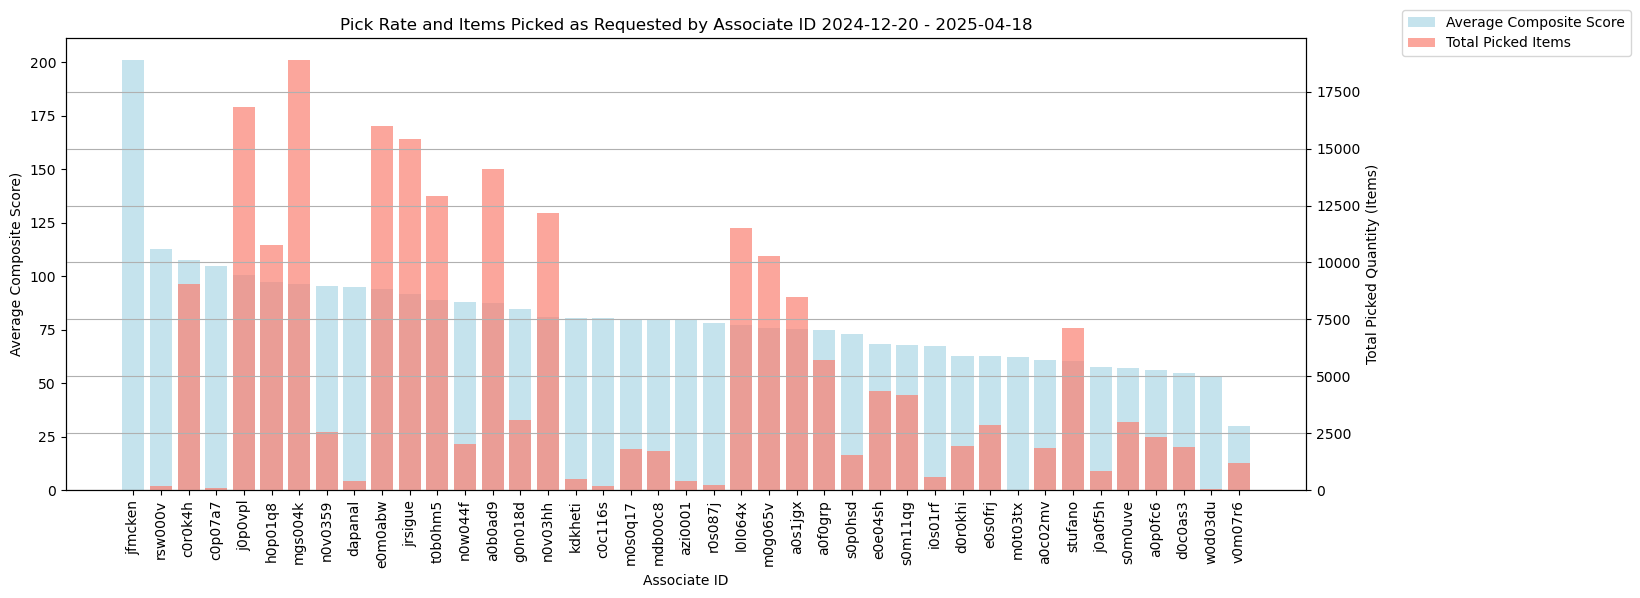

In [361]:

# Plotting side-by-side bar plot for average Composite Score and total Picked As Req Qty
# Ensure columns like 'Picked As Req Qty' are numeric and handle any missing data
df['Picked As Req Qty'] = pd.to_numeric(df['Picked As Req Qty'], errors='coerce')  # Convert to numeric, coerce errors to NaN
df['Composite Score'] = pd.to_numeric(df['Composite Score'], errors='coerce')  # Convert to numeric, coerce errors to NaN
df_3266['Picked As Req Qty'] = pd.to_numeric(df_3266['Picked As Req Qty'], errors='coerce')  # Convert to numeric, coerce errors to NaN
df_3266['Composite Score'] = pd.to_numeric(df_3266['Composite Score'], errors='coerce')  # Convert to numeric, coerce errors to NaN

# Drop rows where the 'Picked As Req Qty' is NaN since we can't sum them
#df_clean = df.dropna(subset=['Picked As Req Qty', 'Composite Score'])
df_clean = df_3266.dropna(subset=['Picked As Req Qty', 'Composite Score'])

# Grouping by Associate ID and calculating the average Pick Rate and total Picked As Req Qty
avg_composite_score = df_clean.groupby('Associate ID')['Composite Score'].mean().sort_values(ascending=False)
total_picked_qty = df_clean.groupby('Associate ID')['Picked As Req Qty'].sum()

# Plotting side-by-side bar plot for average Pick Rate and total Picked As Req Qty
fig, ax1 = plt.subplots(figsize=(14, 6))

# Convert Associate ID index to string for plotting
avg_composite_score.index = avg_composite_score.index.astype(str)
total_picked_qty.index = total_picked_qty.index.astype(str)

# Bar plot for average Pick Rate (items per hour)
ax1.bar(avg_composite_score.index, avg_composite_score, color='lightblue', alpha=0.7, label='Average Composite Score')
ax1.set_xlabel('Associate ID')
ax1.set_ylabel('Average Composite Score)')
ax1.set_title(f'Pick Rate and Items Picked as Requested by Associate ID {oldest_pick_date} - {last_pick_date}')

# Creating a second y-axis for total picked quantity (Items)
ax2 = ax1.twinx()
ax2.bar(total_picked_qty.index, total_picked_qty, color='salmon', alpha=0.7, label='Total Picked Items')
ax2.set_ylabel('Total Picked Quantity (Items)')

# Rotate x-tick labels for Associate ID on ax1
ax1.tick_params(axis='x', rotation=90)

# Adjust layout to prevent overlap
fig.tight_layout()

# Adding a legend for both bars
fig.legend(loc='upper left', bbox_to_anchor=(1, 1))

#Display grid over plot
plt.grid()
# Display the plot
plt.show()


<h2>Compare Associate Composite Score WTD to Average</h2>

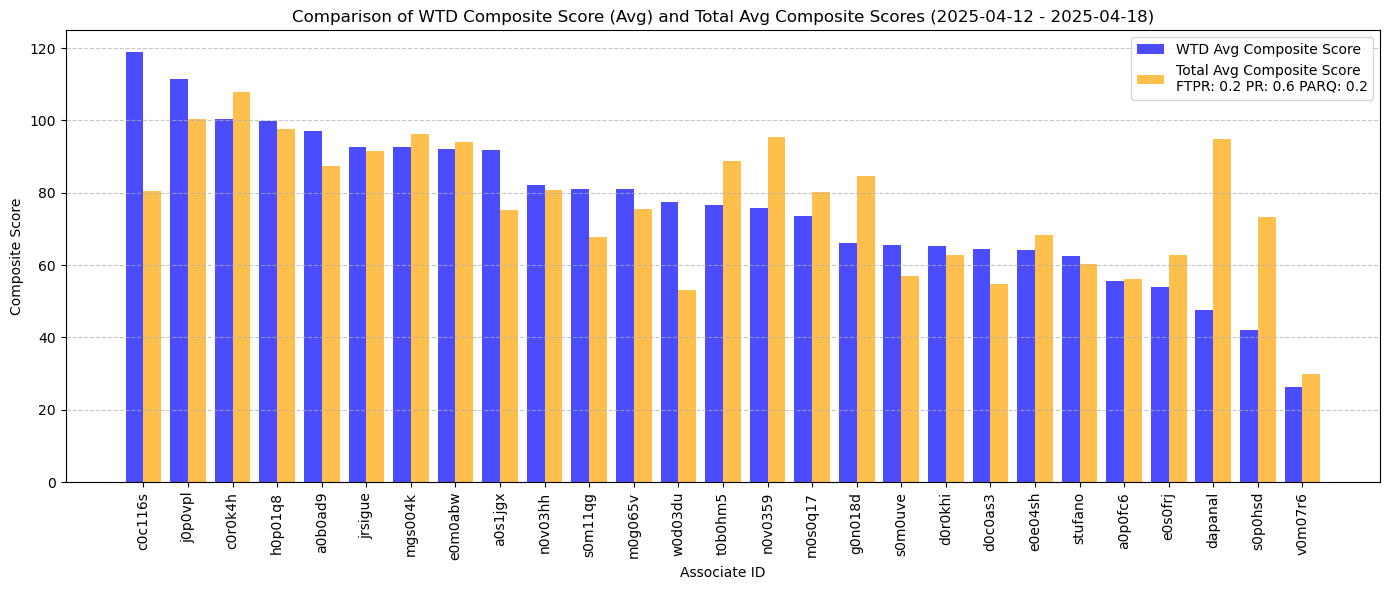

In [362]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

# Step 1: Define function to find the most recent full week
def get_last_full_week(df):
    """Returns the dataframe filtered for the most recent full week along with the week range."""
    last_full_week_start = df['Custom Week Start'].max()  # Start of the most recent full week
    last_full_week_end = df['Custom Week End'].max()  # End of the most recent full week

    # Filter for the most recent full week
    filtered_df = df[
        (df['Day of Pick Date'] >= last_full_week_start) &
        (df['Day of Pick Date'] <= last_full_week_end)
    ].copy()

    return filtered_df, last_full_week_start, last_full_week_end

# Step 2: Filter data for the most recent full week and get the week range
most_recent_week_data, last_full_week_start, last_full_week_end = get_last_full_week(df_clean)

# Fill NaN values in Composite Score and filter out associates with a score of 0
most_recent_week_data.loc[:, 'Composite Score'] = most_recent_week_data['Composite Score'].fillna(0)
most_recent_week_data = most_recent_week_data[most_recent_week_data['Composite Score'] > 0]

# Step 3: Calculate last week's and total average Composite Score (only for associates present last week)
last_week_avg_composite_score = (
    most_recent_week_data.groupby(['Associate ID'])['Composite Score']
    .mean()
)

# Filter df_clean to include only associates who had a score last week
df_clean_filtered = df_clean[df_clean['Associate ID'].isin(last_week_avg_composite_score.index)]

# Compute total average Composite Score (only for associates in last_week_avg_composite_score)
total_avg_composite_score = (
    df_clean_filtered.groupby(['Associate ID'])['Composite Score']
    .mean()
)

# Step 4: Merge both metrics into a single DataFrame for comparison
comparison_df = pd.DataFrame({
    'Last Week Avg Composite Score': last_week_avg_composite_score,
    'Total Avg Composite Score': total_avg_composite_score
})
comparison_df = comparison_df.sort_values(by="Last Week Avg Composite Score", ascending=False)

# Step 5: Plot comparison of last week's and total average Composite Scores
fig, ax = plt.subplots(figsize=(14, 6))

# Create side-by-side bar plot
width = 0.4  # Bar width
x = range(len(comparison_df.index))  # X-axis positions

ax.bar(
    [pos - width / 2 for pos in x],
    comparison_df['Last Week Avg Composite Score'],
    width=width,
    label='WTD Avg Composite Score',
    color='blue',
    alpha=0.7
)
ax.bar(
    [pos + width / 2 for pos in x],
    comparison_df['Total Avg Composite Score'],
    width=width,
    label=f'Total Avg Composite Score \nFTPR: {ftpr_modifier} PR: {pickrate_modifier} PARQ: {picked_as_req_modifier}',
    color='orange',
    alpha=0.7
)

# Add labels and title
ax.set_xlabel('Associate ID')
ax.set_ylabel('Composite Score')
ax.set_title(f'Comparison of WTD Composite Score (Avg) and Total Avg Composite Scores ({last_full_week_start.date()} - {last_full_week_end.date()})')

# Set x-ticks and labels
ax.set_xticks(x)
ax.set_xticklabels(comparison_df.index, rotation=90)

# Add a legend
ax.legend()

# Display grid and plot
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


<h2></h2>

<h2>Composite Score Comparison LW (full week) to Average</h2>

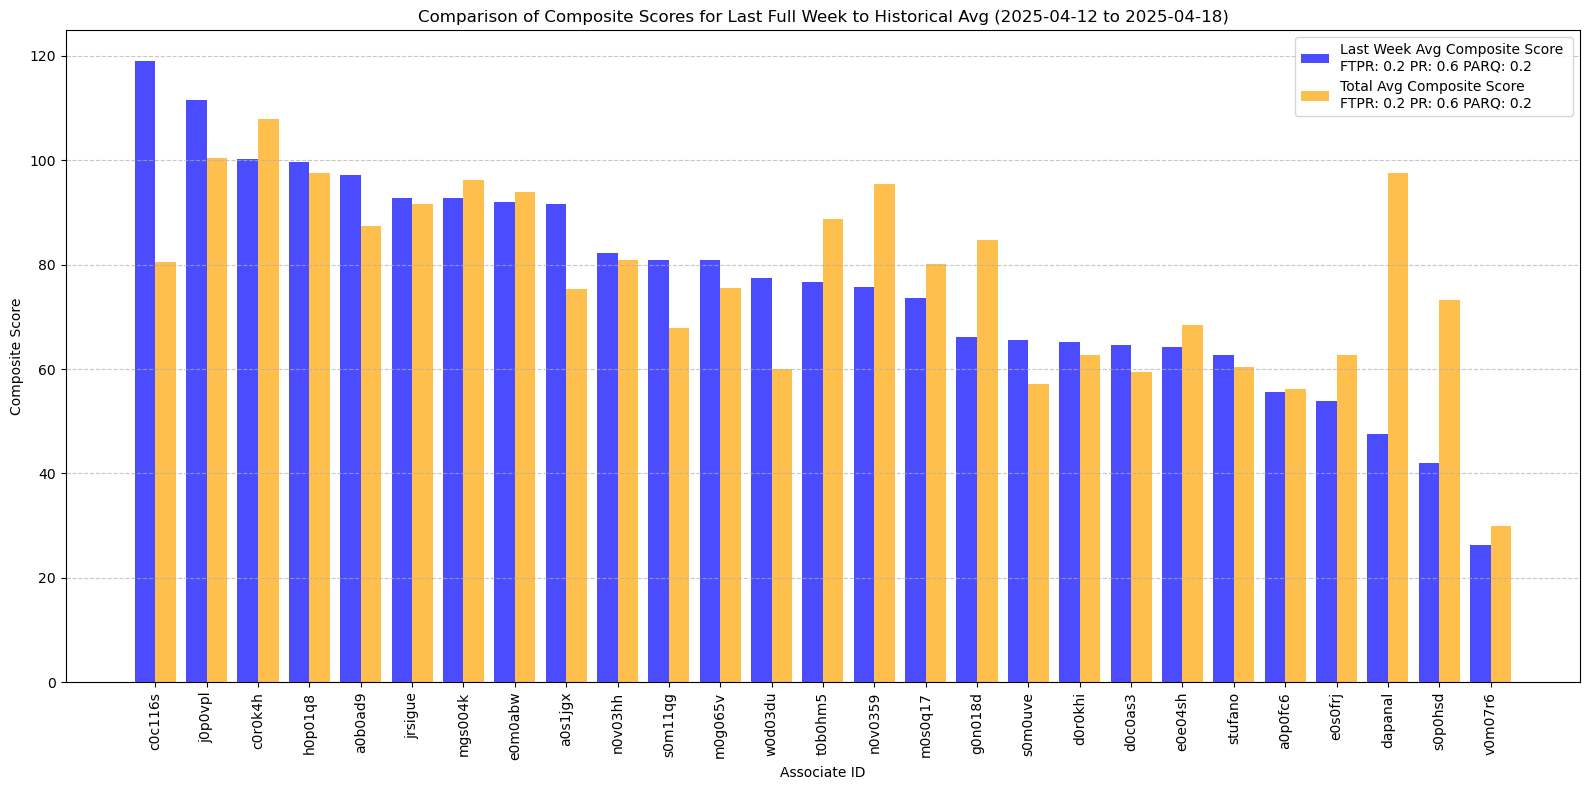

In [363]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 2: Filter for full weeks
full_weeks = df_3266.groupby('Week').filter(is_full_week)

# Step 3: Identify the last full week
last_full_week = full_weeks['Week'].max()  # Get the most recent full week

# Step 4: Extract data for the last full week
last_week_data = full_weeks[full_weeks['Week'] == last_full_week].copy()

# Step 5: Filter associates with Composite Score > 0
last_week_data = last_week_data[last_week_data['Composite Score'] > 0]

# Fill NaN values in 'Composite Score' (if any)
last_week_data['Composite Score'] = last_week_data['Composite Score'].fillna(0)

# Step 6: Group by Associate ID and calculate average Composite Score for the last week
avg_composite_score_last_week = (
    last_week_data.groupby('Associate ID')['Composite Score']
    .mean()
    .sort_values(ascending=False)
)

# Step 7: Filter total average Composite Score to include only IDs in last_week_data
associate_ids_last_week = last_week_data['Associate ID'].unique()  # Get unique Associate IDs from last_week_data
total_avg_composite_score = (
    df_3266[df_3266['Composite Score'] > 0]
    .groupby('Associate ID')['Composite Score']
    .mean()
    .loc[associate_ids_last_week]  # Filter to include only Associate IDs from last_week_data
)

# Step 8: Merge both scores into a single DataFrame for proper alignment
comparison_df = pd.DataFrame({
    'Last Week Avg Composite Score': avg_composite_score_last_week,
    'Total Avg Composite Score': total_avg_composite_score
}).fillna(0)

comparison_df = comparison_df.sort_values(by="Last Week Avg Composite Score", ascending=False)

# Step 9: Visualization - Side-by-side bar chart
fig, ax = plt.subplots(figsize=(16, 8))

width = 0.4  # Bar width
x = range(len(comparison_df.index))  # X-axis positions

ax.bar(
    [pos - width / 2 for pos in x], 
    comparison_df['Last Week Avg Composite Score'], 
    width=width, 
    label=f'Last Week Avg Composite Score \nFTPR: {ftpr_modifier} PR: {pickrate_modifier} PARQ: {picked_as_req_modifier}', 
    color='blue', 
    alpha=0.7
)

ax.bar(
    [pos + width / 2 for pos in x], 
    comparison_df['Total Avg Composite Score'], 
    width=width, 
    label=f'Total Avg Composite Score \nFTPR: {ftpr_modifier} PR: {pickrate_modifier} PARQ: {picked_as_req_modifier}', 
    color='orange', 
    alpha=0.7
)

# Set labels and title
ax.set_xlabel('Associate ID')
ax.set_ylabel(f'Composite Score')
ax.set_title(f'Comparison of Composite Scores for Last Full Week to Historical Avg ({last_full_week})')

# Set x-ticks and labels
ax.set_xticks(x)
ax.set_xticklabels(comparison_df.index, rotation=90)

# Add a legend
ax.legend()

# Display grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Show the plot
plt.show()


<h2>Comparison of Composite Score MTD compared to Last Month</h2>

/var/folders/2j/nzc_1qtn5cqfxtll2x7hdpnm0000gn/T/ipykernel_28826/2309082129.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_3266['Day of Pick Date'] = pd.to_datetime(df['Day of Pick Date'])  # Ensure Date column is in datetime format


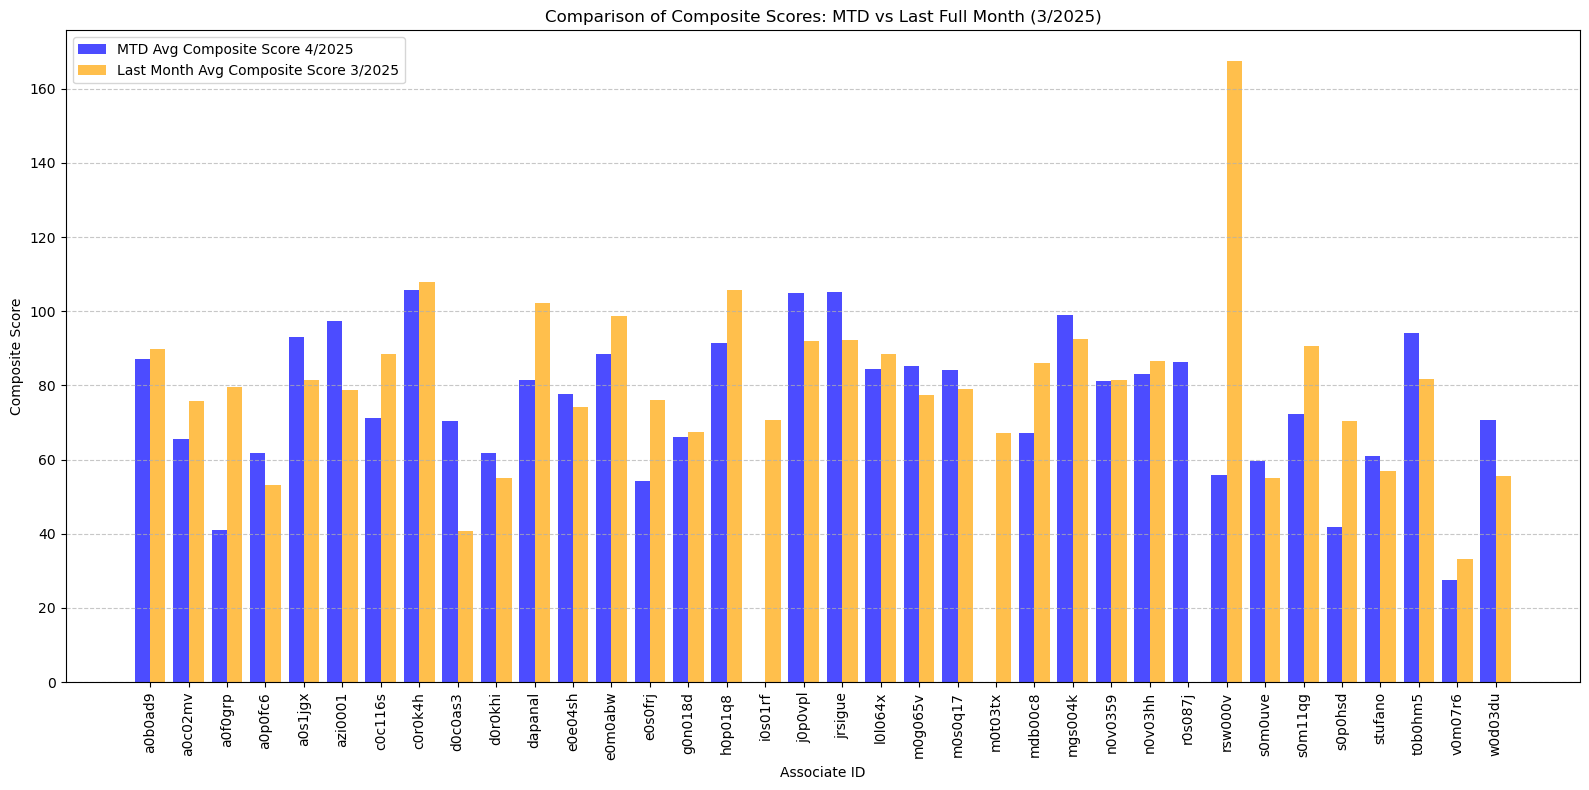

In [364]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Get the current date and define month-to-date (MTD) and last full month
#today = pd.to_datetime("2025-01-31")
today = pd.to_datetime("today")
current_month = today.month
current_year = today.year

# Define last full month
if current_month == 1:
    last_month = 12
    last_month_year = current_year - 1
else:
    last_month = current_month - 1
    last_month_year = current_year

# Step 2: Filter data for MTD and last full month
df_3266['Day of Pick Date'] = pd.to_datetime(df['Day of Pick Date'])  # Ensure Date column is in datetime format

# Month-to-Date (MTD) data
mtd_data = df_3266[
    (df_3266['Day of Pick Date'].dt.year == current_year) & 
    (df_3266['Day of Pick Date'].dt.month == current_month) & 
    (df_3266['Composite Score'] > 0)
]

# Last full month data
last_month_data = df_3266[
    (df_3266['Day of Pick Date'].dt.year == last_month_year) & 
    (df_3266['Day of Pick Date'].dt.month == last_month) & 
    (df_3266['Composite Score'] > 0)
]

# Step 3: Compute average composite scores for each Associate
avg_composite_score_mtd = mtd_data.groupby('Associate ID')['Composite Score'].mean()
avg_composite_score_last_month = last_month_data.groupby('Associate ID')['Composite Score'].mean()

is_empty = mtd_data['Composite Score'].count() == 0
# Step 4: Merge both scores into a single DataFrame for alignment
comparison_df = pd.DataFrame({
    'MTD Avg Composite Score': avg_composite_score_mtd,
    'Last Month Avg Composite Score': avg_composite_score_last_month
}).fillna(0)

if is_empty == True:
    print(f'No data for {current_month}/{current_year}')
else:
    # Step 5: Visualization - Side-by-side bar chart
    fig, ax = plt.subplots(figsize=(16, 8))
    
    width = 0.4  # Bar width
    x = range(len(comparison_df.index))  # X-axis positions
    
    ax.bar(
        [pos - width / 2 for pos in x], 
        comparison_df['MTD Avg Composite Score'], 
        width=width, 
        label=(f'MTD Avg Composite Score {current_month}/{current_year}'), 
        color='blue', 
        alpha=0.7
    )
    
    ax.bar(
        [pos + width / 2 for pos in x], 
        comparison_df['Last Month Avg Composite Score'], 
        width=width, 
        label=(f'Last Month Avg Composite Score {last_month}/{last_month_year}'), 
        color='orange', 
        alpha=0.7
    )
    
    # Set labels and title
    ax.set_xlabel('Associate ID')
    ax.set_ylabel('Composite Score')
    ax.set_title(f'Comparison of Composite Scores: MTD vs Last Full Month ({last_month}/{last_month_year})')
    
    # Set x-ticks and labels
    ax.set_xticks(x)
    ax.set_xticklabels(comparison_df.index, rotation=90)
    
    # Add a legend
    ax.legend()
    
    # Display grid for better readability
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    
    # Show the plot
    plt.show()


<h2>Total Performance By Selected Month by Associate</h2>

In [365]:
'''# Extract Year, Month
df['Year'] = df['Day of Pick Date'].dt.year
df['Month'] = df['Day of Pick Date'].dt.month

# Compute the first day of the month for each row
df['First Day of Month'] = df['Day of Pick Date'].apply(lambda x: x.replace(day=1))

# Compute the week number of the first day of the month
df['First Week of Month'] = df['First Day of Month'].dt.isocalendar().week

# Compute the actual week of the month
df['Week of Month'] = df['Day of Pick Date'].dt.isocalendar().week - df['First Week of Month'] + 1

# Define the metrics and their aggregation type
metrics_agg = {
    'FTPR': 'mean',  # Average
    'Pick Rate': 'mean',  
    'Pick Hours': 'mean',  
    'Qty Req to Pick': 'sum',  # Sum
    'Picked As Req Qty': 'sum',
    'Substitution Qty': 'sum',
    'Nil Pick Qty': 'sum',
    'Exception Qty Req to Pick': 'sum'
}

# Group by Associate ID, Year, Month, and Week of Month, applying aggregation functions
weekly_aggregated = df.groupby(['Associate ID', 'Year', 'Month', 'Week of Month'], as_index=False).agg(metrics_agg)

# Filter to ensure no previous month’s data spills over
weekly_aggregated = weekly_aggregated[weekly_aggregated['Week of Month'] > 0]

# Sort for proper plotting
weekly_aggregated = weekly_aggregated.sort_values(by=['Associate ID', 'Year', 'Month', 'Week of Month'])

# Debugging Step: Check if the grouping is correct
print(weekly_aggregated.head(10))  # Print first 10 rows to verify correctness

# Generate individual plots for each Associate
for associate in weekly_aggregated['Associate ID'].unique():
    associate_data = weekly_aggregated[weekly_aggregated['Associate ID'] == associate]

    plt.figure(figsize=(12, 6))

    # Plot each metric as a separate line
    for metric in metrics_agg.keys():
        plt.plot(associate_data['Week of Month'], associate_data[metric], marker='o', linestyle='-', label=metric)

    plt.xlabel('Week of Month')
    plt.ylabel('Value')
    plt.title(f'Weekly Metrics for Associate {associate}')
    plt.legend(loc='best', fontsize=8)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xticks(associate_data['Week of Month'].unique())  # Ensure proper x-axis labels
    plt.tight_layout()
    
    plt.show()
    '''


"# Extract Year, Month\ndf['Year'] = df['Day of Pick Date'].dt.year\ndf['Month'] = df['Day of Pick Date'].dt.month\n\n# Compute the first day of the month for each row\ndf['First Day of Month'] = df['Day of Pick Date'].apply(lambda x: x.replace(day=1))\n\n# Compute the week number of the first day of the month\ndf['First Week of Month'] = df['First Day of Month'].dt.isocalendar().week\n\n# Compute the actual week of the month\ndf['Week of Month'] = df['Day of Pick Date'].dt.isocalendar().week - df['First Week of Month'] + 1\n\n# Define the metrics and their aggregation type\nmetrics_agg = {\n    'FTPR': 'mean',  # Average\n    'Pick Rate': 'mean',  \n    'Pick Hours': 'mean',  \n    'Qty Req to Pick': 'sum',  # Sum\n    'Picked As Req Qty': 'sum',\n    'Substitution Qty': 'sum',\n    'Nil Pick Qty': 'sum',\n    'Exception Qty Req to Pick': 'sum'\n}\n\n# Group by Associate ID, Year, Month, and Week of Month, applying aggregation functions\nweekly_aggregated = df.groupby(['Associate ID',

In [366]:
run_test_models = False

<h1>disregard the models below for now as of 4/18/2025</h1>

<h2>Using PyTorch (mps) to make a model that predicts FTPR, Pick Rate, Picked As Req Qty</h2>

In [367]:
if run_test_models:
    # Load and preprocess data
    # Assuming 'df' is the provided DataFrame
    #df = df.copy()
    features = ['Pick Hours', 'Qty Req to Pick', 'Substitution Qty', 
                'Nil Pick Qty', 'Exception Qty Req to Pick', 
                'Exception Picked As Req Qty', 'Exception Substitution Qty', 'Exception Nil Pick Qty']
    targets = ['FTPR', 'Pick Rate', 'Picked As Req Qty']

    X = df[features].values
    y = df[targets].values

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Standardize features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Convert to PyTorch tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

    # Define the neural network
    class MultiOutputRegression(nn.Module):
        def __init__(self, input_dim, output_dim):
            super(MultiOutputRegression, self).__init__()
            self.fc1 = nn.Linear(input_dim, 64)
            self.fc2 = nn.Linear(64, 128)
            self.fc3 = nn.Linear(128, output_dim)
            self.relu = nn.ReLU()
        
        def forward(self, x):
            x = self.relu(self.fc1(x))
            x = self.relu(self.fc2(x))
            x = self.fc3(x)
            return x

    # Initialize the model, loss function, and optimizer
    input_dim = len(features)
    output_dim = len(targets)
    model = MultiOutputRegression(input_dim, output_dim)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Train the model
    num_epochs = 100
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        predictions = model(X_train_tensor)
        loss = criterion(predictions, y_train_tensor)
        loss.backward()
        optimizer.step()

        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

    # Evaluate the model
    model.eval()
    with torch.no_grad():
        y_pred_train = model(X_train_tensor)
        y_pred_test = model(X_test_tensor)

        train_mse = mean_squared_error(y_train, y_pred_train.numpy())
        test_mse = mean_squared_error(y_test, y_pred_test.numpy())

        train_r2 = r2_score(y_train, y_pred_train.numpy())
        test_r2 = r2_score(y_test, y_pred_test.numpy())

    print("Training Metrics:")
    print(f"MSE: {train_mse:.4f}, R2 Score: {train_r2:.4f}")
    print("Testing Metrics:")
    print(f"MSE: {test_mse:.4f}, R2 Score: {test_r2:.4f}")


In [368]:
if run_test_models:
    import torch
    import torch.nn as nn
    import torch.optim as optim
    from torch.utils.data import DataLoader, TensorDataset
    from sklearn.preprocessing import StandardScaler
    from sklearn.metrics import mean_squared_error, r2_score
    import numpy as np

    start_time = time.time()
    # Define the model architecture with dropout for regularization
    class EnhancedMultiOutputRegression(nn.Module):
        def __init__(self, input_dim, output_dim):
            super(EnhancedMultiOutputRegression, self).__init__()
            self.fc1 = nn.Linear(input_dim, 128)
            self.fc2 = nn.Linear(128, 256)
            self.fc3 = nn.Linear(256, 128)
            self.fc4 = nn.Linear(128, output_dim)
            self.relu = nn.ReLU()
            self.dropout = nn.Dropout(0.2)

        def forward(self, x):
            x = self.relu(self.fc1(x))
            x = self.dropout(self.relu(self.fc2(x)))
            x = self.relu(self.fc3(x))
            x = self.fc4(x)
            return x

    # Assume df is your dataframe and contains the necessary columns
    # Features and targets
    features = ['Pick Hours', 'Qty Req to Pick', 'Picked As Req Qty', 'Substitution Qty', 
                'Nil Pick Qty', 'Exception Qty Req to Pick', 'Exception Picked As Req Qty', 
                'Exception Substitution Qty', 'Exception Nil Pick Qty']
    targets = ['FTPR', 'Pick Rate']

    X = df[features].values
    y = df[targets].values

    # Split data into training and testing sets
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Scale features and targets
    feature_scaler = StandardScaler()
    target_scaler = StandardScaler()

    X_train = feature_scaler.fit_transform(X_train)
    X_test = feature_scaler.transform(X_test)

    y_train = target_scaler.fit_transform(y_train)
    y_test = target_scaler.transform(y_test)

    # Convert to PyTorch tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

    # Create DataLoader for mini-batch training
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    # Model, Loss Function, Optimizer
    input_dim = X_train.shape[1]
    output_dim = y_train.shape[1]

    model = EnhancedMultiOutputRegression(input_dim, output_dim)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

    # Training the model
    num_epochs = 100
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0.0
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            predictions = model(batch_X)
            loss = criterion(predictions, batch_y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        scheduler.step()
        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss / len(train_loader):.4f}")

    # Evaluating the model
    model.eval()
    with torch.no_grad():
        y_pred_train = model(X_train_tensor).numpy()
        y_pred_test = model(X_test_tensor).numpy()

    # Reverse scaling to compute metrics
    y_pred_train_rescaled = target_scaler.inverse_transform(y_pred_train)
    y_pred_test_rescaled = target_scaler.inverse_transform(y_pred_test)

    y_train_rescaled = target_scaler.inverse_transform(y_train)
    y_test_rescaled = target_scaler.inverse_transform(y_test)

    train_mse = mean_squared_error(y_train_rescaled, y_pred_train_rescaled)
    train_r2 = r2_score(y_train_rescaled, y_pred_train_rescaled)

    test_mse = mean_squared_error(y_test_rescaled, y_pred_test_rescaled)
    test_r2 = r2_score(y_test_rescaled, y_pred_test_rescaled)

    end_time = time.time()
    # Print metrics
    print(f"Training Metrics:\nMSE: {train_mse:.4f}, R2 Score: {train_r2:.4f}")
    print(f"Testing Metrics:\nMSE: {test_mse:.4f}, R2 Score: {test_r2:.4f}")
    print(f'Total time: {end_time - start_time}')


In [369]:
if run_test_models:
    # Check device
    device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
    device = 'cpu'
    print(f"Using device: {device}")
    #device = 'cpu'
    # Define the model architecture with dropout for regularization
    class EnhancedMultiOutputRegression(nn.Module):
        def __init__(self, input_dim, output_dim):
            super(EnhancedMultiOutputRegression, self).__init__()
            self.fc1 = nn.Linear(input_dim, 128)        # First hidden layer
            self.fc2 = nn.Linear(128, 256)              # Second hidden layer
            self.fc3 = nn.Linear(256, 128)              # Third hidden layer
            self.fc4 = nn.Linear(128, 64)               # Fourth hidden layer (new)
            self.fc5 = nn.Linear(64, output_dim)        # Output layer
            self.relu = nn.ReLU()                       # ReLU activation
            self.dropout = nn.Dropout(0.3)              # Dropout for regularization

        def forward(self, x):
            x = self.relu(self.fc1(x))                  # Pass through first layer
            x = self.dropout(self.relu(self.fc2(x)))    # Pass through second layer
            x = self.relu(self.fc3(x))                  # Pass through third layer
            x = self.relu(self.fc4(x))                  # Pass through fourth layer (new)
            x = self.fc5(x)                             # Output layer
            return x

    # Features and target columns
    features = ['Pick Hours', 'Qty Req to Pick', 'Picked As Req Qty', 'Substitution Qty', 
                'Nil Pick Qty', 'Exception Qty Req to Pick', 'Exception Picked As Req Qty', 
                'Exception Substitution Qty', 'Exception Nil Pick Qty']
    targets = ['FTPR', 'Pick Rate']

    # Prepare data
    X = df[features].values
    y = df[targets].values

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Scale features and targets
    feature_scaler = StandardScaler()
    target_scaler = StandardScaler()

    X_train = feature_scaler.fit_transform(X_train)
    X_test = feature_scaler.transform(X_test)

    y_train = target_scaler.fit_transform(y_train)
    y_test = target_scaler.transform(y_test)

    # Convert data to PyTorch tensors and move to the specified device
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

    # Create DataLoader for mini-batch training
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    # Model, Loss Function, Optimizer, and Scheduler
    input_dim = X_train.shape[1]
    output_dim = y_train.shape[1]

    model = EnhancedMultiOutputRegression(input_dim, output_dim).to(device)  # Move model to device
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9)  # Learning rate scheduler

    # Training the model with validation loss and early stopping
    num_epochs = 100
    patience, early_stop_counter = 10, 0  # Early stopping patience
    best_val_loss = float('inf')

    start_time = time.time()

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        epoch_loss = 0.0
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            predictions = model(batch_X)
            loss = criterion(predictions, batch_y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        
        scheduler.step()
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch_X, batch_y in test_loader:
                predictions = model(batch_X)
                loss = criterion(predictions, batch_y)
                val_loss += loss.item()
        val_loss /= len(test_loader)
        
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss / len(train_loader):.4f}, Val Loss: {val_loss:.4f}")
        
        # Early stopping logic
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pt')  # Save the best model
            early_stop_counter = 0
        else:
            early_stop_counter += 1
            if early_stop_counter >= patience:
                print("Early stopping triggered")
                break

    # Load the best model for evaluation
    model.load_state_dict(torch.load('best_model.pt', weights_only=True))
    model.eval()

    # Evaluate on training and testing sets
    with torch.no_grad():
        y_pred_train = model(X_train_tensor).cpu().numpy()
        y_pred_test = model(X_test_tensor).cpu().numpy()

    # Reverse scaling to compute metrics
    y_pred_train_rescaled = target_scaler.inverse_transform(y_pred_train)
    y_pred_test_rescaled = target_scaler.inverse_transform(y_pred_test)

    y_train_rescaled = target_scaler.inverse_transform(y_train)
    y_test_rescaled = target_scaler.inverse_transform(y_test)

    train_mse = mean_squared_error(y_train_rescaled, y_pred_train_rescaled)
    train_r2 = r2_score(y_train_rescaled, y_pred_train_rescaled)

    test_mse = mean_squared_error(y_test_rescaled, y_pred_test_rescaled)
    test_r2 = r2_score(y_test_rescaled, y_pred_test_rescaled)

    end_time = time.time()

    # Print metrics
    print(f"Training Metrics:\nMSE: {train_mse:.4f}, R2 Score: {train_r2:.4f}")
    print(f"Testing Metrics:\nMSE: {test_mse:.4f}, R2 Score: {test_r2:.4f}")
    print(f"Total time with {device}: {end_time - start_time:.2f} seconds")


In [370]:
if run_test_models:
    # Check device
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    print(f"Using device: {device}")

    # Define the model architecture with dropout for regularization
    class EnhancedMultiOutputRegression(nn.Module):
        def __init__(self, input_dim, output_dim):
            super(EnhancedMultiOutputRegression, self).__init__()
            self.fc1 = nn.Linear(input_dim, 128)        # First hidden layer
            self.fc2 = nn.Linear(128, 256)              # Second hidden layer
            self.fc3 = nn.Linear(256, 128)              # Third hidden layer
            self.fc4 = nn.Linear(128, 64)               # Fourth hidden layer (new)
            self.fc5 = nn.Linear(64, output_dim)        # Output layer
            self.relu = nn.ReLU()                       # ReLU activation
            self.dropout = nn.Dropout(0.3)              # Dropout for regularization

        def forward(self, x):
            x = self.relu(self.fc1(x))                  # Pass through first layer
            x = self.dropout(self.relu(self.fc2(x)))    # Pass through second layer
            x = self.relu(self.fc3(x))                  # Pass through third layer
            x = self.relu(self.fc4(x))                  # Pass through fourth layer (new)
            x = self.fc5(x)                             # Output layer
            return x

    # Features and target columns
    features = ['Pick Hours', 'Qty Req to Pick', 'Picked As Req Qty', 'Substitution Qty', 
                'Nil Pick Qty', 'Exception Qty Req to Pick', 'Exception Picked As Req Qty', 
                'Exception Substitution Qty', 'Exception Nil Pick Qty']
    targets = ['FTPR', 'Pick Rate']

    # Prepare data
    X = df[features].values
    y = df[targets].values

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Scale features and targets
    feature_scaler = StandardScaler()
    target_scaler = StandardScaler()

    X_train = feature_scaler.fit_transform(X_train)
    X_test = feature_scaler.transform(X_test)

    y_train = target_scaler.fit_transform(y_train)
    y_test = target_scaler.transform(y_test)

    # Convert data to PyTorch tensors and move to the specified device
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

    # Create DataLoader for mini-batch training
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    # Model, Loss Function, Optimizer, and Scheduler
    input_dim = X_train.shape[1]
    output_dim = y_train.shape[1]

    model = EnhancedMultiOutputRegression(input_dim, output_dim).to(device)  # Move model to device
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9)  # Learning rate scheduler

    # Training the model with validation loss and early stopping
    num_epochs = 100
    patience, early_stop_counter = 10, 0  # Early stopping patience
    best_val_loss = float('inf')

    start_time = time.time()

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        epoch_loss = 0.0
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            predictions = model(batch_X)
            loss = criterion(predictions, batch_y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        
        scheduler.step()
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch_X, batch_y in test_loader:
                predictions = model(batch_X)
                loss = criterion(predictions, batch_y)
                val_loss += loss.item()
        val_loss /= len(test_loader)
        
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss / len(train_loader):.4f}, Val Loss: {val_loss:.4f}")
        
        # Early stopping logic
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pt')  # Save the best model
            early_stop_counter = 0
        else:
            early_stop_counter += 1
            if early_stop_counter >= patience:
                print("Early stopping triggered")
                break

    # Load the best model for evaluation
    model.load_state_dict(torch.load('best_model.pt', weights_only=True))
    model.eval()

    # Evaluate on training and testing sets
    with torch.no_grad():
        y_pred_train = model(X_train_tensor).cpu().numpy()
        y_pred_test = model(X_test_tensor).cpu().numpy()

    # Reverse scaling to compute metrics
    y_pred_train_rescaled = target_scaler.inverse_transform(y_pred_train)
    y_pred_test_rescaled = target_scaler.inverse_transform(y_pred_test)

    y_train_rescaled = target_scaler.inverse_transform(y_train)
    y_test_rescaled = target_scaler.inverse_transform(y_test)

    train_mse = mean_squared_error(y_train_rescaled, y_pred_train_rescaled)
    train_r2 = r2_score(y_train_rescaled, y_pred_train_rescaled)

    test_mse = mean_squared_error(y_test_rescaled, y_pred_test_rescaled)
    test_r2 = r2_score(y_test_rescaled, y_pred_test_rescaled)

    end_time = time.time()

    # Print metrics
    print(f"Training Metrics:\nMSE: {train_mse:.4f}, R2 Score: {train_r2:.4f}")
    print(f"Testing Metrics:\nMSE: {test_mse:.4f}, R2 Score: {test_r2:.4f}")
    print(f"Total time with {device}: {end_time - start_time:.2f} seconds")


<h2>Attempt to make PyTorch model better</h2>

In [371]:
if run_test_models:
    import torch
    import torch.nn as nn
    import torch.optim as optim
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import StandardScaler
    from sklearn.metrics import mean_squared_error, r2_score
    import numpy as np
    import time

    # Define Models with More Complexity
    class EnhancedModel(nn.Module):
        def __init__(self, input_size):
            super(EnhancedModel, self).__init__()
            self.model = nn.Sequential(
                nn.Linear(input_size, 256),
                nn.ReLU(),
                nn.Dropout(0.3),
                nn.Linear(256, 128),
                nn.ReLU(),
                nn.Dropout(0.3),
                nn.Linear(128, 64),
                nn.ReLU(),
                nn.Linear(64, 1)
            )
        
        def forward(self, x):
            return self.model(x)

    # Data Preparation (include interaction features or domain-specific knowledge)
    df['Pick Hours per Qty Req'] = df['Pick Hours'] / (df['Qty Req to Pick'] + 1e-5)
    df['Total Exceptions'] = (
        df['Exception Qty Req to Pick'] + df['Exception Picked As Req Qty'] +
        df['Exception Substitution Qty'] + df['Exception Nil Pick Qty']
    )

    X = df[['Pick Hours', 'Qty Req to Pick', 'Picked As Req Qty', 'Substitution Qty', 'Nil Pick Qty',
            'Exception Qty Req to Pick', 'Exception Picked As Req Qty', 'Exception Substitution Qty',
            'Exception Nil Pick Qty', 'Pick Hours per Qty Req', 'Total Exceptions']]
    y_ftpr = df['FTPR']
    y_pick_rate = df['Pick Rate']
    y_picked_as_req_qty = df['Picked As Req Qty']

    X_train, X_test, y_train_ftpr, y_test_ftpr = train_test_split(X, y_ftpr, test_size=0.2, random_state=42)
    _, _, y_train_pick_rate, y_test_pick_rate = train_test_split(X, y_pick_rate, test_size=0.2, random_state=42)
    _, _, y_train_picked_as_req_qty, y_test_picked_as_req_qty = train_test_split(X, y_picked_as_req_qty, test_size=0.2, random_state=42)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Training Function with Learning Rate Scheduling
    def train_model_with_scheduler(model, optimizer, scheduler, criterion, X_train, y_train, X_test, y_test, epochs=500):
        for epoch in range(epochs):
            model.train()
            optimizer.zero_grad()
            outputs = model(torch.tensor(X_train, dtype=torch.float32))
            loss = criterion(outputs.flatten(), torch.tensor(y_train.values, dtype=torch.float32))
            loss.backward()
            optimizer.step()
            scheduler.step(loss)  # Adjust learning rate based on validation loss
        
        # Evaluate the model
        model.eval()
        with torch.no_grad():
            predictions = model(torch.tensor(X_test, dtype=torch.float32)).flatten().numpy()
            mse = mean_squared_error(y_test, predictions)
            r2 = r2_score(y_test, predictions)
        return mse, r2, predictions

    # Train and Evaluate Models
    start_time = time.time()
    input_size = X_train_scaled.shape[1]

    # FTPR Model
    ftpr_model = EnhancedModel(input_size)
    optimizer_ftpr = optim.Adam(ftpr_model.parameters(), lr=0.01)
    scheduler_ftpr = optim.lr_scheduler.ReduceLROnPlateau(optimizer_ftpr, patience=10, factor=0.5, verbose=True)
    criterion = nn.MSELoss()
    ftpr_mse, ftpr_r2, ftpr_preds = train_model_with_scheduler(ftpr_model, optimizer_ftpr, scheduler_ftpr, criterion, X_train_scaled, y_train_ftpr, X_test_scaled, y_test_ftpr)

    # Pick Rate Model
    pick_rate_model = EnhancedModel(input_size)
    optimizer_pick_rate = optim.Adam(pick_rate_model.parameters(), lr=0.01)
    scheduler_pick_rate = optim.lr_scheduler.ReduceLROnPlateau(optimizer_pick_rate, patience=10, factor=0.5, verbose=True)
    pick_rate_mse, pick_rate_r2, pick_rate_preds = train_model_with_scheduler(pick_rate_model, optimizer_pick_rate, scheduler_pick_rate, criterion, X_train_scaled, y_train_pick_rate, X_test_scaled, y_test_pick_rate)

    # Picked As Req Qty Model
    picked_as_req_qty_model = EnhancedModel(input_size)
    optimizer_picked_as_req_qty = optim.Adam(picked_as_req_qty_model.parameters(), lr=0.01)
    scheduler_picked_as_req_qty = optim.lr_scheduler.ReduceLROnPlateau(optimizer_picked_as_req_qty, patience=10, factor=0.5, verbose=True)
    picked_as_req_qty_mse, picked_as_req_qty_r2, picked_as_req_qty_preds = train_model_with_scheduler(
        picked_as_req_qty_model, optimizer_picked_as_req_qty, scheduler_picked_as_req_qty, criterion, X_train_scaled, y_train_picked_as_req_qty, X_test_scaled, y_test_picked_as_req_qty
    )

    end_time = time.time()

    # Results
    print(f"FTPR Prediction Metrics:\nMSE: {ftpr_mse:.4f}, R2 Score: {ftpr_r2:.4f}")
    print(f"Pick Rate Prediction Metrics:\nMSE: {pick_rate_mse:.4f}, R2 Score: {pick_rate_r2:.4f}")
    print(f"Picked As Req Qty Prediction Metrics:\nMSE: {picked_as_req_qty_mse:.4f}, R2 Score: {picked_as_req_qty_r2:.4f}")
    print(f"Total time: {end_time - start_time:.2f} seconds")


In [372]:
if run_test_models:
    # Feature importance using Random Forest for FTPR
    from sklearn.ensemble import RandomForestRegressor

    # Train a Random Forest model on FTPR to find important features
    rf = RandomForestRegressor(random_state=42)
    rf.fit(X_train_scaled, y_train_ftpr)
    importances = rf.feature_importances_

    # Display feature importance
    feature_importance = sorted(zip(importances, X.columns), reverse=True)
    print("Feature Importance for FTPR:")
    for importance, feature in feature_importance:
        print(f"{feature}: {importance:.4f}")

    # Select top features based on importance
    top_features = [feature for importance, feature in feature_importance if importance > 0.05]
    X_train_ftpr = X_train_scaled[:, [X.columns.get_loc(f) for f in top_features]]
    X_test_ftpr = X_test_scaled[:, [X.columns.get_loc(f) for f in top_features]]

    # Use only these features in the FTPR model
    ftpr_model = EnhancedModel(len(top_features))


In [373]:
if run_test_models:
    import torch
    import torch.nn as nn
    import torch.optim as optim
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import StandardScaler
    from sklearn.metrics import mean_squared_error, r2_score
    import numpy as np
    import time

    # Define Models with More Complexity
    class EnhancedModel(nn.Module):
        def __init__(self, input_size):
            super(EnhancedModel, self).__init__()
            self.model = nn.Sequential(
                nn.Linear(input_size, 256),
                nn.ReLU(),
                nn.Dropout(0.3),
                nn.Linear(256, 128),
                nn.ReLU(),
                nn.Dropout(0.3),
                nn.Linear(128, 64),
                nn.ReLU(),
                nn.Linear(64, 1)
            )
        
        def forward(self, x):
            return self.model(x)

    # Data Preparation based on Feature Importance
    df['Pick Hours per Qty Req'] = df['Pick Hours'] / (df['Qty Req to Pick'] + 1e-5)
    df['Total Exceptions'] = (
        df['Exception Qty Req to Pick'] + df['Exception Picked As Req Qty'] +
        df['Exception Substitution Qty'] + df['Exception Nil Pick Qty']
    )

    # Selecting features based on importance
    X = df[['Picked As Req Qty', 'Pick Hours per Qty Req', 'Nil Pick Qty', 'Qty Req to Pick', 
            'Substitution Qty', 'Pick Hours', 'Total Exceptions']]  # Focus on important features

    y_ftpr = df['FTPR']
    y_pick_rate = df['Pick Rate']
    y_picked_as_req_qty = df['Picked As Req Qty']

    X_train, X_test, y_train_ftpr, y_test_ftpr = train_test_split(X, y_ftpr, test_size=0.2, random_state=42)
    _, _, y_train_pick_rate, y_test_pick_rate = train_test_split(X, y_pick_rate, test_size=0.2, random_state=42)
    _, _, y_train_picked_as_req_qty, y_test_picked_as_req_qty = train_test_split(X, y_picked_as_req_qty, test_size=0.2, random_state=42)

    # Scaling the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Training Function with Learning Rate Scheduling
    def train_model_with_scheduler(model, optimizer, scheduler, criterion, X_train, y_train, X_test, y_test, epochs=500):
        for epoch in range(epochs):
            model.train()
            optimizer.zero_grad()
            outputs = model(torch.tensor(X_train, dtype=torch.float32))
            loss = criterion(outputs.flatten(), torch.tensor(y_train.values, dtype=torch.float32))
            loss.backward()
            optimizer.step()
            scheduler.step(loss)  # Adjust learning rate based on validation loss
        
        # Evaluate the model
        model.eval()
        with torch.no_grad():
            predictions = model(torch.tensor(X_test, dtype=torch.float32)).flatten().numpy()
            mse = mean_squared_error(y_test, predictions)
            r2 = r2_score(y_test, predictions)
        return mse, r2, predictions

    # Train and Evaluate Models
    start_time = time.time()
    input_size = X_train_scaled.shape[1]

    # FTPR Model
    ftpr_model = EnhancedModel(input_size)
    optimizer_ftpr = optim.Adam(ftpr_model.parameters(), lr=0.01)
    scheduler_ftpr = optim.lr_scheduler.ReduceLROnPlateau(optimizer_ftpr, patience=10, factor=0.5, verbose=True)
    criterion = nn.MSELoss()
    ftpr_mse, ftpr_r2, ftpr_preds = train_model_with_scheduler(ftpr_model, optimizer_ftpr, scheduler_ftpr, criterion, X_train_scaled, y_train_ftpr, X_test_scaled, y_test_ftpr)

    # Pick Rate Model
    pick_rate_model = EnhancedModel(input_size)
    optimizer_pick_rate = optim.Adam(pick_rate_model.parameters(), lr=0.01)
    scheduler_pick_rate = optim.lr_scheduler.ReduceLROnPlateau(optimizer_pick_rate, patience=10, factor=0.5, verbose=True)
    pick_rate_mse, pick_rate_r2, pick_rate_preds = train_model_with_scheduler(pick_rate_model, optimizer_pick_rate, scheduler_pick_rate, criterion, X_train_scaled, y_train_pick_rate, X_test_scaled, y_test_pick_rate)

    # Picked As Req Qty Model
    picked_as_req_qty_model = EnhancedModel(input_size)
    optimizer_picked_as_req_qty = optim.Adam(picked_as_req_qty_model.parameters(), lr=0.01)
    scheduler_picked_as_req_qty = optim.lr_scheduler.ReduceLROnPlateau(optimizer_picked_as_req_qty, patience=10, factor=0.5, verbose=True)
    picked_as_req_qty_mse, picked_as_req_qty_r2, picked_as_req_qty_preds = train_model_with_scheduler(
        picked_as_req_qty_model, optimizer_picked_as_req_qty, scheduler_picked_as_req_qty, criterion, X_train_scaled, y_train_picked_as_req_qty, X_test_scaled, y_test_picked_as_req_qty
    )

    end_time = time.time()

    # Results
    print(f"FTPR Prediction Metrics:\nMSE: {ftpr_mse:.4f}, R2 Score: {ftpr_r2:.4f}")
    print(f"Pick Rate Prediction Metrics:\nMSE: {pick_rate_mse:.4f}, R2 Score: {pick_rate_r2:.4f}")
    print(f"Picked As Req Qty Prediction Metrics:\nMSE: {picked_as_req_qty_mse:.4f}, R2 Score: {picked_as_req_qty_r2:.4f}")
    print(f"Total time: {end_time - start_time:.2f} seconds")

    # Feature Importance based on your provided data
    # These are the feature importance scores for FTPR as an example
    feature_importance = {
        'Picked As Req Qty': 0.2553,
        'Pick Hours per Qty Req': 0.1751,
        'Nil Pick Qty': 0.1545,
        'Qty Req to Pick': 0.1504,
        'Substitution Qty': 0.1096,
        'Pick Hours': 0.0977,
        'Exception Nil Pick Qty': 0.0210,
        'Total Exceptions': 0.0146,
        'Exception Substitution Qty': 0.0128,
        'Exception Qty Req to Pick': 0.0079,
        'Exception Picked As Req Qty': 0.0010
    }

    print("\nFeature Importance for FTPR:")
    for feature, importance in sorted(feature_importance.items(), key=lambda x: x[1], reverse=True):
        print(f"{feature}: {importance:.4f}")


In [374]:
if run_test_models:
    import pandas as pd
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import StandardScaler
    from sklearn.linear_model import LinearRegression
    from sklearn.metrics import mean_squared_error, r2_score
    import matplotlib.pyplot as plt
    from sklearn.ensemble import RandomForestRegressor

    # Data Preprocessing
    X = df[['Day of Pick Date', 'Qty Req to Pick', 'Pick Hours']]
    y_ftpr = df['FTPR']
    y_pick_rate = df['Pick Rate']

    # Convert date column to datetime format and extract day, month, year features
    df['Day of Pick Date'] = pd.to_datetime(df['Day of Pick Date'])
    df['day_of_month'] = df['Day of Pick Date'].dt.day
    df['month'] = df['Day of Pick Date'].dt.month

    X = df[['Qty Req to Pick', 'Pick Hours', 'day_of_month', 'month']]
    y_ftpr = df['FTPR']
    y_pick_rate = df['Pick Rate']

    # Split data into training and testing sets
    X_train, X_test, y_ftpr_train, y_ftpr_test = train_test_split(X, y_ftpr, test_size=0.2, random_state=42)
    _, _, y_pick_rate_train, y_pick_rate_test = train_test_split(X, y_pick_rate, test_size=0.2, random_state=42)

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train models
    model_ftpr = RandomForestRegressor(n_estimators=100)
    model_ftpr.fit(X_train_scaled, y_ftpr_train)

    y_ftpr_pred = model_ftpr.predict(X_test_scaled)
    print("FTPR Model Evaluation:")
    print(f"MSE: {mean_squared_error(y_ftpr_test, y_ftpr_pred)}")
    print(f"R2 Score: {r2_score(y_ftpr_test, y_ftpr_pred)}")

    model_pick_rate = RandomForestRegressor(n_estimators=100)
    model_pick_rate.fit(X_train_scaled, y_pick_rate_train)

    y_pick_rate_pred = model_pick_rate.predict(X_test_scaled)
    print("Pick Rate Model Evaluation:")
    print(f"MSE: {mean_squared_error(y_pick_rate_test, y_pick_rate_pred)}")
    print(f"R2 Score: {r2_score(y_pick_rate_test, y_pick_rate_pred)}")

    # Plot predictions vs actual values
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.scatter(y_ftpr_test, y_ftpr_pred)
    plt.xlabel("Actual FTPR")
    plt.ylabel("Predicted FTPR")
    plt.title("FTPR Model Predictions")

    plt.subplot(1, 2, 2)
    plt.scatter(y_pick_rate_test, y_pick_rate_pred)
    plt.xlabel("Actual Pick Rate")
    plt.ylabel("Predicted Pick Rate")
    plt.title("Pick Rate Model Predictions")

    plt.tight_layout()
    plt.show()


<h2>Attempt to try different models to improve accuracy</h2>

In [375]:
if run_test_models:
    from sklearn.model_selection import GridSearchCV

    # Define hyperparameter grids for FTPR and Pick Rate models
    ftpr_param_grid = {
        'n_estimators': [10, 50, 100, 200, 300],
        'max_depth': [None, 5, 10, 15, 20]
    }

    pick_rate_param_grid = {
        'n_estimators': [10, 50, 100, 200, 300],
        'max_depth': [None, 5, 10, 15, 20]
    }

    # Perform grid search for FTPR model
    ftpr_gs = GridSearchCV(RandomForestRegressor(), ftpr_param_grid, cv=5, n_jobs=-1)
    ftpr_gs.fit(X_train_scaled, y_ftpr_train)

    print("FTPR Model Best Parameters:", ftpr_gs.best_params_)
    print("FTPR Model Best Score:", ftpr_gs.best_score_)

    # Perform grid search for Pick Rate model
    pick_rate_gs = GridSearchCV(RandomForestRegressor(), pick_rate_param_grid, cv=5, n_jobs=-1)
    pick_rate_gs.fit(X_train_scaled, y_pick_rate_train)

    print("Pick Rate Model Best Parameters:", pick_rate_gs.best_params_)
    print("Pick Rate Model Best Score:", pick_rate_gs.best_score_)

    # Train models with best parameters and evaluate
    ftpr_best_model = ftpr_gs.best_estimator_
    pick_rate_best_model = pick_rate_gs.best_estimator_

    y_ftpr_pred = ftpr_best_model.predict(X_test_scaled)
    y_pick_rate_pred = pick_rate_best_model.predict(X_test_scaled)

    print("FTPR Model Evaluation (Best Parameters):")
    print("MSE:", mean_squared_error(y_ftpr_test, y_ftpr_pred))
    print("R2 Score:", r2_score(y_ftpr_test, y_ftpr_pred))

    print("Pick Rate Model Evaluation (Best Parameters):")
    print("MSE:", mean_squared_error(y_pick_rate_test, y_pick_rate_pred))
    print("R2 Score:", r2_score(y_pick_rate_test, y_pick_rate_pred))

In [376]:
df.head()

,Associate ID,Associate Name,Store #,Day of Pick Date,FTPR,FTP Expected,FTP Actual,Pick Rate,Pick Hours,Picked As Req Qty,...,Handled_Exceptions,Composite Score,Day of Week,IsWeekend,Log Pick Rate,Log FTPR,ExceptionRate,Predicted FTPR,Predicted Pick Rate,Predicted Picked As Req Qty
718,s0m11qg,SHUBHADA MENGLE,3266.0,2024-12-20,89.26,129,108,30.0,3.88,108,...,1,57.452,4,0,3.433987,4.502694,0.000000,89.099174,30.572918,107.575562
463,jrsigue,JULIA SIGUENCIA,3266.0,2024-12-20,92.02,347,336,68.0,4.99,336,...,1,126.404,4,0,4.234107,4.532815,0.005764,91.993118,68.284927,336.094208
332,e0s0frj,ERICKA SUIN,3266.0,2024-12-20,90.91,55,50,45.0,1.11,50,...,1,55.182,4,0,3.828641,4.520810,0.000000,90.894142,46.245056,50.451927
71,a0f0grp,ANDREA FIGUEROA,3266.0,2024-12-20,98.63,147,144,55.0,2.62,144,...,1,81.526,4,0,4.025352,4.601463,0.013605,98.659729,54.762615,143.570541
559,m0s0q17,MIROLLA SAID,3266.0,2024-12-20,99.06,105,105,64.0,1.64,105,...,1,79.212,4,0,4.174387,4.605770,0.000000,99.140991,64.207214,105.366928


In [377]:
if run_test_models:
    import xgboost as xgb
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import StandardScaler
    from sklearn.metrics import mean_squared_error, r2_score
    import numpy as np

    # Data Preparation
    df['Pick Hours per Qty Req'] = df['Pick Hours'] / (df['Qty Req to Pick'] + 1e-5)
    df['Total Exceptions'] = (
        df['Exception Qty Req to Pick'] + df['Exception Picked As Req Qty'] +
        df['Exception Substitution Qty'] + df['Exception Nil Pick Qty']
    )

    X = df[['Pick Hours', 'Qty Req to Pick', 'Picked As Req Qty', 'Substitution Qty', 'Nil Pick Qty',
            'Exception Qty Req to Pick', 'Exception Picked As Req Qty', 'Exception Substitution Qty',
            'Exception Nil Pick Qty', 'Pick Hours per Qty Req', 'Total Exceptions']]
    y_ftpr = df['FTPR']
    y_pick_rate = df['Pick Rate']
    y_picked_as_req_qty = df['Picked As Req Qty']

    # Train-Test Split
    X_train, X_test, y_train_ftpr, y_test_ftpr = train_test_split(X, y_ftpr, test_size=0.2, random_state=42)
    _, _, y_train_pick_rate, y_test_pick_rate = train_test_split(X, y_pick_rate, test_size=0.2, random_state=42)
    _, _, y_train_picked_as_req_qty, y_test_picked_as_req_qty = train_test_split(X, y_picked_as_req_qty, test_size=0.2, random_state=42)

    # Scaling the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Model Training for FTPR
    ftpr_model = xgb.XGBRegressor(tree_method="hist", n_estimators=1000, learning_rate=0.05, max_depth=6)
    ftpr_model.fit(X_train_scaled, y_train_ftpr)

    # Model Training for Pick Rate
    pick_rate_model = xgb.XGBRegressor(tree_method="hist", n_estimators=1000, learning_rate=0.05, max_depth=6)
    pick_rate_model.fit(X_train_scaled, y_train_pick_rate)

    # Model Training for Picked As Req Qty
    picked_as_req_qty_model = xgb.XGBRegressor(tree_method="hist", n_estimators=1000, learning_rate=0.05, max_depth=6)
    picked_as_req_qty_model.fit(X_train_scaled, y_train_picked_as_req_qty)

    # Predictions
    ftpr_preds = ftpr_model.predict(X_test_scaled)
    pick_rate_preds = pick_rate_model.predict(X_test_scaled)
    picked_as_req_qty_preds = picked_as_req_qty_model.predict(X_test_scaled)

    # Evaluation
    print("FTPR Metrics")
    print(f"MSE: {mean_squared_error(y_test_ftpr, ftpr_preds):.4f}")
    print(f"R2: {r2_score(y_test_ftpr, ftpr_preds):.4f}")

    print("\nPick Rate Metrics")
    print(f"MSE: {mean_squared_error(y_test_pick_rate, pick_rate_preds):.4f}")
    print(f"R2: {r2_score(y_test_pick_rate, pick_rate_preds):.4f}")

    print("\nPicked As Req Qty Metrics")
    print(f"MSE: {mean_squared_error(y_test_picked_as_req_qty, picked_as_req_qty_preds):.4f}")
    print(f"R2: {r2_score(y_test_picked_as_req_qty, picked_as_req_qty_preds):.4f}")


In [378]:
if run_test_models:
    import pandas as pd
    import numpy as np
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import StandardScaler
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.metrics import mean_squared_error, r2_score

    # ===========================================
    # Load and Preprocess Data
    # ===========================================

    # Example DataFrame (replace with actual data loading)
    # df = pd.read_csv('your_dataset.csv')

    # Convert 'Day of Pick Date' and other datetime columns to numeric features (e.g., day of the week)
    if "Day of Pick Date" in df.columns:
        df["Day_of_Week"] = pd.to_datetime(df["Day of Pick Date"]).dt.dayofweek
        df["Day_of_Month"] = pd.to_datetime(df["Day of Pick Date"]).dt.day
        df["Month"] = pd.to_datetime(df["Day of Pick Date"]).dt.month

    # Drop irrelevant columns
    X = df.drop(columns=[
        "FTPR", "Pick Rate", "Predicted FTPR", "Predicted Pick Rate",
        "Predicted Picked As Req Qty", "Day of Pick Date", "Week",
        "Composite Score", "Associate ID"
    ])

    # Target variables
    y_ftpr = df["FTPR"]
    y_pick_rate = df["Pick Rate"]

    # Convert categorical features to numeric using one-hot encoding
    X_numeric = pd.get_dummies(X, drop_first=True)

    # Ensure all columns are numeric
    X_numeric = X_numeric.apply(pd.to_numeric, errors="coerce").fillna(0)

    # Split data into training and testing sets
    X_train, X_test, y_train_ftpr, y_test_ftpr = train_test_split(X_numeric, y_ftpr, test_size=0.2, random_state=42)
    _, _, y_train_pick_rate, y_test_pick_rate = train_test_split(X_numeric, y_pick_rate, test_size=0.2, random_state=42)

    # Scale numeric features for better performance
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # ===========================================
    # Train and Evaluate Models
    # ===========================================

    # Define a function to train and evaluate models
    def train_and_evaluate(model, X_train, X_test, y_train, y_test, label):
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        mse = mean_squared_error(y_test, predictions)
        r2 = r2_score(y_test, predictions)
        print(f"{label} Metrics:")
        print(f"MSE: {mse:.4f}")
        print(f"R2: {r2:.4f}")
        return model

    # Train Random Forest Regressor for FTPR
    ftpr_model = RandomForestRegressor(n_estimators=500, random_state=42)
    ftpr_model = train_and_evaluate(ftpr_model, X_train_scaled, X_test_scaled, y_train_ftpr, y_test_ftpr, "FTPR")

    # Train Random Forest Regressor for Pick Rate
    pick_rate_model = RandomForestRegressor(n_estimators=500, random_state=42)
    pick_rate_model = train_and_evaluate(pick_rate_model, X_train_scaled, X_test_scaled, y_train_pick_rate, y_test_pick_rate, "Pick Rate")

    # ===========================================
    # Notes
    # ===========================================
    # - Handled datetime columns by extracting numeric features.
    # - Dropped irrelevant columns to avoid data leakage.
    # - Converted categorical features to numeric using `pd.get_dummies`.
    # - Ensured all columns are numeric with `pd.to_numeric` and replaced NaN values with 0.
    # - Scaled features using `StandardScaler` for improved model performance.


In [379]:
if run_test_models:
    import pandas as pd
    import numpy as np
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import StandardScaler
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

    # Define constants
    TEST_SIZE = 0.2
    RANDOM_STATE = 42
    N_ESTIMATORS = 500

    def load_data(file_path):
        try:
            df = pd.read_csv(file_path)
            return df
        except FileNotFoundError:
            print("File not found.")
            return None

    def preprocess_data(df):
        if "Day of Pick Date" in df.columns:
            df["Day_of_Week"] = pd.to_datetime(df["Day of Pick Date"]).dt.dayofweek
            df["Day_of_Month"] = pd.to_datetime(df["Day of Pick Date"]).dt.day
            df["Month"] = pd.to_datetime(df["Day of Pick Date"]).dt.month
        
        X = df.drop(columns=[
            "FTPR", "Pick Rate", "Predicted FTPR", "Predicted Pick Rate",
            "Predicted Picked As Req Qty", "Day of Pick Date", "Week",
            "Composite Score", "Associate ID"
        ])
        
        y_ftpr = df["FTPR"]
        y_pick_rate = df["Pick Rate"]
        
        X_numeric = pd.get_dummies(X, drop_first=True)
        X_numeric = X_numeric.apply(pd.to_numeric, errors="coerce").fillna(0)
        
        return X_numeric, y_ftpr, y_pick_rate

    def split_data(X, y):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)
        return X_train, X_test, y_train, y_test

    def scale_features(X_train, X_test):
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        return X_train_scaled, X_test_scaled

    def train_and_evaluate(model, X_train, X_test, y_train, y_test, label):
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        
        mse = mean_squared_error(y_test, predictions)
        r2 = r2_score(y_test, predictions)
        mae = mean_absolute_error(y_test, predictions)
        
        print(f"{label} Metrics:")
        print(f"MSE: {mse:.4f}")
        print(f"R2: {r2:.4f}")
        print(f"MAE: {mae:.4f}")
        
        return model

    # Preprocess data
    X, y_ftpr, y_pick_rate = preprocess_data(df)

    # Split data
    X_train, X_test, y_train_ftpr, y_test_ftpr = split_data(X, y_ftpr)
    _, _, y_train_pick_rate, y_test_pick_rate = split_data(X, y_pick_rate)

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train and evaluate models
    ftpr_model = RandomForestRegressor(n_estimators=N_ESTIMATORS, random_state=RANDOM_STATE)
    ftpr_model = train_and_evaluate(ftpr_model, X_train_scaled, X_test_scaled, y_train_ftpr, y_test_ftpr, "FTPR")

    pick_rate_model = RandomForestRegressor(n_estimators=N_ESTIMATORS, random_state=RANDOM_STATE)
    pick_rate_model = train_and_evaluate(pick_rate_model, X_train_scaled, X_test_scaled, y_train_pick_rate, y_test_pick_rate, "Pick Rate")

In [380]:
if run_test_models:
    import pandas as pd
    import numpy as np
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import StandardScaler
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

    # Define constants
    TEST_SIZE = 0.2
    RANDOM_STATE = 42
    N_ESTIMATORS = 500

    def load_data(file_path):
        try:
            df = pd.read_csv(file_path)
            return df
        except FileNotFoundError:
            print("File not found.")
            return None

    def preprocess_data(df):
        if "Day of Pick Date" in df.columns:
            df["Day_of_Week"] = pd.to_datetime(df["Day of Pick Date"]).dt.dayofweek
            df["Day_of_Month"] = pd.to_datetime(df["Day of Pick Date"]).dt.day
            df["Month"] = pd.to_datetime(df["Day of Pick Date"]).dt.month
        
        X = df.drop(columns=[
            "FTPR", "Pick Rate", "Predicted FTPR", "Predicted Pick Rate",
            "Predicted Picked As Req Qty", "Day of Pick Date", "Week",
            "Composite Score", "Associate ID"
        ])
        
        y_ftpr = df["FTPR"]
        y_pick_rate = df["Pick Rate"]
        
        X_numeric = pd.get_dummies(X, drop_first=True)
        X_numeric = X_numeric.apply(pd.to_numeric, errors="coerce").fillna(0)
        
        return X_numeric, y_ftpr, y_pick_rate

    def split_data(X, y):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)
        return X_train, X_test, y_train, y_test

    def scale_features(X_train, X_test):
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        return X_train_scaled, X_test_scaled

    def train_and_evaluate(model, X_train, X_test, y_train, y_test, label):
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        
        mse = mean_squared_error(y_test, predictions)
        r2 = r2_score(y_test, predictions)
        mae = mean_absolute_error(y_test, predictions)
        
        print(f"{label} Metrics:")
        print(f"MSE: {mse:.4f}")
        print(f"R2: {r2:.4f}")
        print(f"MAE: {mae:.4f}")
        
        return model


    # Preprocess data
    X, y_ftpr, y_pick_rate = preprocess_data(df)

    # Split data
    X_train, X_test, y_train_ftpr, y_test_ftpr = split_data(X, y_ftpr)
    _, _, y_train_pick_rate, y_test_pick_rate = split_data(X, y_pick_rate)

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train and evaluate models
    ftpr_model = RandomForestRegressor(n_estimators=N_ESTIMATORS, random_state=RANDOM_STATE, n_jobs=-1)
    ftpr_model = train_and_evaluate(ftpr_model, X_train_scaled, X_test_scaled, y_train_ftpr, y_test_ftpr, "FTPR")

    pick_rate_model = RandomForestRegressor(n_estimators=N_ESTIMATORS, random_state=RANDOM_STATE, n_jobs=-1)
    pick_rate_model = train_and_evaluate(pick_rate_model, X_train_scaled, X_test_scaled, y_train_pick_rate, y_test_pick_rate, "Pick Rate")

In [381]:
combine_data_to_csv()

Directory 'Data/Comnined/' already exists.


In [382]:

notebook_end_time = time.time()
print(f"Total time taken: {notebook_end_time - notebook_start_time:.2f} seconds. Last run date: {datetime.now().date()}")

Total time taken: 27.61 seconds. Last run date: 2025-04-19
